# Проект 5. Выбираем авто выгодно (SF DST-60)
## (Георгий Виногродский)

<img align=center src="https://wroom.ru/i/news/8780img4.jpg" width="800" />

Цель проекта - создать модель, которая будет предсказывать стоимость автомобиля c пробегом в Москве по его характеристикам.

По условию соревнования, нужно самостоятельно собрать обучающий датасет. Сбор данных был произведен с auto.ru по фильтрам: с пробегом, город Москва, радиус 1000, марки автомобилей и признаки на основе тестового датасета.  
Ссылка на код, который использовался для парсинга: https://github.com/Chedered/SkillFactory/blob/main/DS/module-5/autoru_parser.py

Так как, по-видимому, продажи на вторичном рынке автомобилей сильно упали, не удалось собрать достаточно данных для модели. Поэтому совместим собранные данные с данными из шаблона.

---

# Импорт библиотек и настройки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import missingno as msno
from IPython.display import Markdown, display

import sys
from tqdm import tqdm
from datetime import datetime
import re
import warnings

from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor, BaggingRegressor
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression

In [2]:
params = {'axes.facecolor': 'gainsboro',
          'axes.grid': True,
          'grid.linestyle': '--',
          'font.size': 10,
          'axes.labelsize': 10,
          'axes.titlesize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
plt.rcParams.update(params)
%matplotlib inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
VERSION    = 85
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_PARSED = '../input/autoru-used-moskow-cars-102021/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

In [7]:
tqdm.pandas()

---

<a id="0"></a>
# [СОДЕРЖАНИЕ](#0)
1. [1. Предобработка](#1)
2. [2. Импорт данных и первичный осмотр и подготовка к анализу](#2)
    * [2.1 Импорт данных](#2.1)
    * [2.2 Первичный осмотр](#2.2)
    * [2.3 Подготовка к анализу](#2.3)
3. [3. Анализ и обработка признаков](#3)
    * [3.1 Числовые признаки](#3.1)
    * [3.2 Категориальные признаки](#3.2)
    * [3.3 Бинарные признаки](#3.3)
    * [3.4 Временные признаки](#3.4)
4. [4. Проверочная модель](#4)
5. [5. Создание новых признаков](#5)
6. [6. Обучение](#6)
    * [6.1 RandomForestRegressor](#6.1)
    * [6.2 CatBoostRegressor](#6.2)
    * [6.3 ExtraTreesRegressor](#6.3)
    * [6.4 LGBMRegressor](#6.4)
    * [6.5 StackingRegressor](#6.5)
    * [6.6 BaggingRegressor](#6.6)
    * [6.7 Выбор модели и submission](#6.7)
7. [7. Итоги](#7)

---

<a id="1"></a>
# [1. Предобработка](#1)

<img align=center src="https://files.realpython.com/media/Defining-Your-Own-Python-Function_Watermarked.d5b07e88ece4.jpg" width="800" />

Напишем здесь все функции, которые будут использоваться в дальнейшем:

- Вспомогательные

In [8]:
def my_describe(df):
    '''Отображение описательных статистик датафрейма'''
    temp = {}
    temp['Имя признака'] = list(df.columns)
    temp['Тип'] = df.dtypes
    temp['Всего значений'] = df.describe(include='all').loc['count']
    temp['Число пропусков'] = df.isnull().sum().values
    temp['Кол-во уникальных'] = df.nunique().values
    temp['Уникальные значения (до 10)'] = df.agg(lambda s: s.unique()[:10])
    temp['Минимум'] = df.describe(include='all').loc['min']
    temp['Максимум'] = df.describe(include='all').loc['max']
    temp['Среднее'] = df.describe(include='all').loc['mean']
    temp['Медиана'] = df.describe(include='all').loc['50%']
    temp = pd.DataFrame.from_dict(temp, orient='index')
    display(temp.T.set_index('Имя признака'))
    return



def mape(y_true, y_pred):
    '''Ключевая метрика'''
    return np.mean(np.abs((y_pred-y_true)/y_true))



def printmd(string):
    '''Продвинутый вывод строк'''
    display(Markdown(string))
    
def irq_analyze(df, col):
    '''
    Фильтр по формуле интерквартильного расстояния

    Возвращает значения границ и количество выборосов за ними
    '''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    left_border = perc25 - 1.5*IQR
    right_border = perc75 + 1.5*IQR
    left_values_sum = (df[col] < left_border).sum()
    right_values_sum = (df[col] > right_border).sum()
    return left_border, right_border, left_values_sum, right_values_sum

- Обработка признаков

In [9]:
def feature_to_float(value):
    """Достает числа из строк"""
    float_value = re.findall(r'\d*\.\d+|\d+', str(value))
    if float_value:
        return float(float_value[0])
    return 0



def start_date_to_dt(value):
    '''Конвертирует строку в дату из собранных данных по дате объявления'''
    value = str(value)
    
    if 'nan' in value:
        return None
    
    years_lst = ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012']
    if value[-4:] not in years_lst:
        value = value + ' 2021'
    
    if 'января' in value:
        value = value.replace('января', '01')
    elif 'февраля' in value:
        value = value.replace('февраля', '02')
    elif 'марта' in value:
        value = value.replace('марта', '03')
    elif 'апреля' in value:
        value = value.replace('апреля', '04')
    elif 'мая' in value:
        value = value.replace('мая', '05')
    elif 'июня' in value:
        value = value.replace('июня', '06')
    elif 'июля' in value:
        value = value.replace('июля', '07')
    elif 'августа' in value:
        value = value.replace('августа', '08')
    elif 'сентября' in value:
        value = value.replace('сентября', '09')
    elif 'октября' in value:
        value = value.replace('октября', '10')
    elif 'ноября' in value:
        value = value.replace('ноября', '11')
    elif 'декабря' in value:
        value = value.replace('декабря', '12')
        
    value = datetime.strptime(value, '%d %m %Y')
    return str(value)



def inflation(x):
    '''Учет инфляции'''
    if x[2] != 'parsed':
        return int(x[1])
    else:
        return int(x[1]/(x[0]+1))


    
def fill_missing(df, col_x, col_y):
    '''
    Функция для заполнения пропусков.
    
    Группирует столбец y по количеству значений. 
    Затем заменяет пропуски  в столбце x на максимальное 
    значение из сгруппированного датафрейма.
    '''
    y_counts = df.groupby([col_y])[col_x].value_counts().unstack().T
    filled_col = df[[col_x, col_y]].apply(lambda x: y_counts[x[1]].idxmax() if 
                                          pd.isna(x[0]) else x[0], axis=1)
    print(f'Пропуски в столбце {col_x} заполнены')
    return filled_col



def body_processing(value):
    '''Сокращает количество значений в body/bodyType'''
    bodies = ['пикап',
             'купе',
             'хэтчбек',
             'компактвэн',
             'внедорожник',
             'тарга',
             'универсал',
             'родстер',
             'лифтбек',
             'седан',
             'фастбек',
             'минивэн',
             'микровэн',
             'кабриолет',
             'фургон',
             'лимузин']
    for body in bodies:
        if body in value:
            return body
        
        
        
def owners_processing(x):
    '''
    Заполнение пропусков в столбце owners.
    
    Заполняет по среднему пробегу по отношению к количеству владельцев.
    Словарь со средним пробегом был сгруппирован заранее, так как его 
    формирование на каждой итерации сильно замедляло работу функции.
    '''
#     mileage_dict = data[data['owners'] != 0].groupby('owners')['mileage'].mean().to_dict()
    mileage_dict = {1.0: 98406.6845168801, 2.0: 147692.44603794365, 3.0: 212004.7051790707}
    
    owners_cnt = 0
    min_miles = 98724
    if x[0] != 0:
        return x[0]
    elif x[1] == 0:
        return 0
    elif 0 < x[1] < min_miles:
        return 1.0
    else:
        for k, v in mileage_dict.items():
            if x[1] > v:
                owners_cnt = k
        return owners_cnt
    
    
    
def cat_fill_missing(df, col_lst):
    '''
    Заполнение пропусков категориальных переменных

    Заполняет случайными значениями переменной в зависимости
    от веса значения.
    '''
    if type(col_lst) != list:
        col_lst = [col_lst]

    for col in col_lst:
        if df[col].isnull().sum() != 0:
            col_name = df[col].value_counts().index.to_list()
            col_distr = df[col].value_counts(normalize=True).values
            missing = df[col].isnull()
            df.loc[missing, [col]] = np.random.choice(col_name,
                                                      size=len(df[missing]),
                                                      p=col_distr)
            
            
            
def num_of_cols(df, col_lst, goal):
    '''Создает новые числовые признаки с помощью groupby'''
    if type(col_lst) != list:
        col_lst = [col_lst]

    num_cols_lst = []

    for col in col_lst:
        mean_col = df.groupby(col)[goal].mean().to_dict()
        std_col = df.groupby(col)[goal].std().to_dict()
        mean_name = f'mean_{goal}_{col}'
        std_name = f'std_{goal}_{col}'
        num_cols_lst += [mean_name, std_name]
        df[mean_name] = df[col].map(mean_col)
        df[std_name] = df[col].map(std_col)

    print(f'Созданы {num_cols_lst}')
    return num_cols_lst

- Визуализация

In [10]:
def display_outliers(df, col_lst, log=False):
    '''Создает датафрейм с границами на основе IQR и количеством выбросов'''
    if type(col_lst) != list:
        col_lst = [col_lst]

    if log:
        df, col_lst = log_col(df, col_lst)

    temp_df = df[col_lst]
    temp_dict = {}

    for col in col_lst:
        lb, rb, lvs, rvs = irq_analyze(df, col)
        temp_dict['Границы выбросов '+col] = [lb, rb]
        temp_dict['Кол-во выбросов '+col] = [lvs, rvs]

    temp_df = pd.DataFrame.from_dict(
        temp_dict, orient='index', columns=['Left', 'Right'])
    display(temp_df)
    
    
    
def log_col(df, col_lst):
    '''Создает признаки с логарифмированными значениями для графиков'''
    df = df.copy()
    temp_col_lst = []
    for col in col_lst:
        col_log = col + '_log'
        df[col_log] = df[col].apply(lambda x: np.log(x + 1))
        temp_col_lst.append(col_log)
    col_lst = col_lst + temp_col_lst
    return df, sorted(col_lst)



def num_col_boxplot(ax, df, col_lst, j):
    '''Boxplot для функции num_col_analyze_general'''
    mean = df[col_lst[j]].mean()
    median = df[col_lst[j]].median()
    sns.boxplot(data=df, x=col_lst[j], color='steelblue')
    ax.axvline(mean, color='k',
               linestyle='--', linewidth=3)
    ax.axvline(median, color='w',
               linestyle='-', linewidth=3)
    ax.set_title('Распределение признака\n' + col_lst[j])
    ax.set_xlabel('')
    return ax
    

    
def num_col_distplot(ax, df, col_lst, j):
    '''Distplot для функции num_col_analyze_general'''
    mean = df[col_lst[j]].mean()
    median = df[col_lst[j]].median()
    sns.distplot(df[col_lst[j]], bins=100, axlabel=False,
                 kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                 hist_kws={"histtype": "bar",
                           "color": 'steelblue',
                           "edgecolor": 'k',
                           "linewidth": 1, "alpha": 1})
    if j == 0:
        ax.set_ylabel('Плотность распределения')
    else:
        ax.set_ylabel('')
    ax.axvline(median, color='w',
               linestyle='-', linewidth=3, label="Median")
    ax.axvline(mean, color='k',
               linestyle='--', linewidth=3, label="Mean")
    ax.legend()
    return ax            
    
    
    
    
def num_col_qqplot(ax, df, col_lst, j):
    '''Qqplot для функции num_col_analyze_general'''
    sm.qqplot(df[col_lst[j]].dropna(), fit=True,
              line='45', ax=ax, marker='o',
              markerfacecolor='steelblue',
              markeredgecolor='steelblue', alpha=0.3)
    ax.get_lines()[1].set_color("black")
    ax.get_lines()[1].set_linewidth("3")
    if j == 0:
        ax.set_ylabel('Выборочные квантили')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Теоретические квантили\n' + col_lst[j])
    return ax


                
def num_col_analyze_general(df, col):
    '''
    Первичный осмотр числовых перменных

    Выводит boxplot, график плотности распределения
    и qqplot, а также датафрейм с границами на основе
    IQR и количеством выбросов за ними изначальных 
    и логарифмированных значений переменной
    '''
    col_lst = [col]

    df, col_lst = log_col(df, col_lst)

    printmd(f'### {col_lst[0]}')
    i = 0
    j = 0
    fig = plt.figure(figsize=(16, 10))
    widths = [2, 2]
    heights = [1, 3, 3]
    gs = fig.add_gridspec(3, 2, width_ratios=widths, height_ratios=heights)
    for col in range(2):
        for row in range(3):
            ax = fig.add_subplot(gs[row, col])
            if i == 0:
                num_col_boxplot(ax, df, col_lst, j)
                i = 1
            elif i == 1:
                num_col_distplot(ax, df, col_lst, j)
                i = 2
            else:
                num_col_qqplot(ax, df, col_lst, j)
                i = 0
                j = 1
    plt.show()
    display_outliers(df, col_lst)
    printmd('---')
    
    
    
def f_classifier(df, col_lst, class_col):
    '''Оценка значимости числовых переменных'''
    col_cnt = len(col_lst)
    if col_cnt > 10:
        col_cnt = 10
    plt.rcParams['figure.figsize'] = (8,col_cnt)
    imp_num = pd.Series(f_classif(df[col_lst],
                                  df[class_col])[0],
                        index=col_lst)[:col_cnt]
    imp_num.sort_values(inplace=True)
    imp_num.plot(kind='barh',
                 edgecolor='k',
                 linewidth=1,
                 color=sns.color_palette('Blues', col_cnt))
    

    
def magnify():
    '''Настройки стиля для матрицы корреляций'''
    return [dict(selector="caption",
                 props=[('color', 'black'),
                        ('font-size', '15px')]),
            dict(selector="th",
                 props=[("font-size", "9pt"),
                        ("border", "1px solid steelblue")]),
            dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"),
                        ('transform', 'rotateZ(180deg)'),
                        ('vertical-align', 'top')]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '400px'),
                        ('font-size', '20pt'),
                        ('font-weight', 'bold')])]



def corr_matrix(df, col_lst, add_col=None, matrix_name=None):
    '''Вывод матрицы корреляций'''
    if add_col != None:
        if type(add_col) != list:
            add_col = [add_col]
        col_lst = col_lst+add_col

    if matrix_name == None:
        matrix_name = ', '.join(col_lst)

    corr = df[col_lst].corr().abs()
    matrix = corr.style.background_gradient(cmap='Blues', axis=1)\
                 .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
                 .set_caption(f'Матрица корреляций: ' + matrix_name)\
                 .set_precision(2)\
                 .set_table_styles(magnify())
    return matrix



def get_countplot(df, col_lst, rotation='horizontal', hue=None):
    '''Первичный осмотр категориальных перменных'''
    
    if type(col_lst) != list:
        col_lst = [col_lst]

    fig = plt.figure(figsize=(16 if len(col_lst) > 1 else 10,
                              6*((len(col_lst)//2)+1)))
    gs = fig.add_gridspec((len(col_lst)//2)+1,
                          len(col_lst) if len(col_lst) <= 2 else 2)
    for i in range(len(col_lst)):
        ax = fig.add_subplot(gs[i//2, i % 2])
        
        if hue != None:
            col = df.groupby([col_lst[i]])[hue].value_counts()
        else:    
            col = df[col_lst[i]].value_counts().sort_values(ascending=False)
        index = df[col_lst[i]].value_counts().sort_values(ascending=False).index    
        max_value = col.max()
        pct_missing = round(np.mean(df[col_lst[i]].isnull())*100, 2)
        
        sns.countplot(df[col_lst[i]], data=df,
                      hue=hue, order=index,
                      palette='Blues_r',
                      edgecolor='k',
                      linewidth=2)
        xlabels = ax.get_xticklabels()
        ax.set_xticklabels(xlabels, rotation=rotation)
        ax.set_title('Распределение признака\n' + col_lst[i])
        ax.set_xlabel(None)
        ax.set_ylabel('')
        ax.set_ylim(0, max_value*1.2)
        ax.text(0, max_value*1.1,
                f'Процент пропусков: {pct_missing}%', 
                bbox={'facecolor': 'w'})
        
        
        
def get_jointplot(df, col_x, col_y):
    '''Вывод графика регрессии и корреляции'''
    corr = round(df[[col_x, col_y]].corr().values[0][1], 2)
    sns.jointplot(x=col_x, y=col_y, 
                  data=df, 
                  kind='reg', 
                  color='xkcd:darkish blue')
    print('----------------')
    print(f'Корреляция: {corr}')
    print('----------------')
    
    
    
def mutual_classifier(df, col_lst, class_col):
    '''Оценка значимости категориальных и бинарных переменных'''
    col_cnt = len(col_lst)
    if col_cnt > 10:
        col_cnt = 10
    plt.rcParams['figure.figsize'] = (8, col_cnt)
    imp_cat = pd.Series(mutual_info_classif(df[col_lst],
                                            df[class_col].dropna(),
                                            discrete_features=True),
                        index=col_lst)[:col_cnt]
    imp_cat.sort_values(inplace=True)
    imp_cat.plot(kind='barh',
                 edgecolor='k',
                 linewidth=1,
                 color=sns.color_palette('Blues', col_cnt))
    
    
    
def get_boxplot(df, col_x, col_lst, hue=None):
    '''Вывод боксплота'''
    if type(col_lst) != list:
        col_lst = [col_lst]

    fig = plt.figure(figsize=(16 if len(col_lst) > 1 else 8,
                              8*((len(col_lst)//2)+1)))
    gs = fig.add_gridspec((len(col_lst)//2)+1,
                          len(col_lst) if len(col_lst) <= 2 else 2)
    for i in range(len(col_lst)):
        ax = fig.add_subplot(gs[i//2, i % 2])

        sns.boxplot(x=col_lst[i], y=col_x, hue=hue,
                    data=df, palette='Blues_r')
        ax.set_title(f'Формы распределения для\n{col_lst[i]} по {col_x}')

* Обучение

In [11]:
def kfold_validation(model, X, y, cv=4, log_target=False): 
    '''Кросс-валидация для обучающей модели'''
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    mape_values = []
    
    for train_index, test_index in tqdm(kf.split(X, y), leave=False, desc='cv'):
        X_train = X.filter(items=train_index, axis=0)
        X_test = X.filter(items=test_index, axis=0)
        y_train = y[train_index]
        y_test = y[test_index]
        
        if log_target:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if log_target:
            y_pred = np.exp(y_pred)
        
        mape_value = mape(y_test, y_pred)
        mape_values.append(mape_value)
    
    return np.mean(mape_values), model



def strkfold_validation(model, X, y, cv=4, log_target=False): 
    '''Кросс-валидация для обучающей модели'''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    mape_values = []
    
    for train_index, test_index in tqdm(skf.split(X, y), leave=False, desc='cv'):
        X_train = X.filter(items=train_index, axis=0)
        X_test = X.filter(items=test_index, axis=0)
        y_train = y[train_index]
        y_test = y[test_index]
        
        if log_target:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if log_target:
            y_pred = np.exp(y_pred)
        
        mape_value = mape(y_test, y_pred)
        mape_values.append(mape_value)
    
    return np.mean(mape_values), model

[К содержанию](#0)

---

<a id="2"></a>
# [2. Импорт данных и первичный осмотр и подготовка к анлаизу](#2)

<img align=center src="http://pavelvoloshin.com/wp-content/uploads/2019/02/%D0%9B%D1%83%D0%BF%D0%B0.jpg" width="800" />

Посмотрим на собранные данные, приведем в единый вид и соберем в один датасет для дальнейшего анализа.

---

<a id="2.1"></a>
# [2.1 Импорт данных](#2.1)

In [12]:
!ls '../input'

autoru-used-moskow-cars-102021	       sf-dst-car-price-prediction
parsing-all-moscow-auto-ru-09-09-2020


In [13]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv')
parsed = pd.read_csv(DIR_PARSED+'autoru-all-data.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

---

<a id="2.2"></a>
# [2.2 Первичный осмотр](#2.2)

In [14]:
sample_submission.head()

sell_id  price
0  1100575026      0
1  1100549428      0
2  1100658222      0
3  1100937408      0
4  1101037972      0

In [15]:
train.head(5)

bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission engineDisplacement  enginePower  \
0          MECHANICAL                2.8        174.0   
1          MECHANICAL                1.8         90.0   
2          MECHANICAL                2.3        136.0   
3          MECHANICAL                1.8         90.0   
4          MECHANICAL                2.0        101.0   

                                         description  mileage Комплектация  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  {'id': '0'}   
1  Машина в оригинале не гнилая все вопросы по те...   173424  {'id': '0'}   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо рез...   230000  {'id': '0'}   
3                                                NaN   240000  {'id': '0'}   
4  Машина не гнилая, дыр нет, днище целое, даже в...   300000  {'id': '0'}   

     Привод  Руль  Состояние  Владельцы        ПТС  Таможня Владение  \
0    полный  LEFT        NaN        3.0   ORIGINAL     True      NaN   
1  передний  LEFT        NaN        3.0   ORIGINAL     True      NaN   
2    полный  LEFT        NaN        3.0   ORIGINAL     True      NaN   
3  передний  LEFT        NaN        3.0   ORIGINAL     True      NaN   
4  передний  LEFT        NaN        3.0  DUPLICATE     True      NaN   

      price            start_date  hidden model  
0  200000.0  2019-10-03T08:09:11Z     NaN   100  
1   60000.0  2020-09-06T06:49:40Z     NaN   100  
2   99000.0  2020-09-02T14:04:21Z     NaN   100  
3   65000.0  2020-08-23T17:40:09Z     NaN   100  
4  100000.0  2020-09-08T09:22:07Z     NaN   100

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [17]:
my_describe(train)

Тип Всего значений Число пропусков  \
Имя признака                                                   
bodyType               object          89377               1   
brand                  object          89378               0   
color                  object          89378               0   
fuelType               object          89378               0   
modelDate             float64          89377               1   
name                   object          89377               1   
numberOfDoors         float64          89377               1   
productionDate          int64          89378               0   
vehicleConfiguration   object          89377               1   
vehicleTransmission    object          89377               1   
engineDisplacement     object          89377               1   
enginePower           float64          89377               1   
description            object          86124            3254   
mileage                 int64          89378               0   
Комплектация           object          89378               0   
Привод                 object          89377               1   
Руль                   object          89378               0   
Состояние             float64              0           89378   
Владельцы             float64          75790           13588   
ПТС                    object          89017             361   
Таможня                  bool          89378               0   
Владение               object          29201           60177   
price                 float64          88968             410   
start_date             object          89378               0   
hidden                float64              0           89378   
model                  object          89378               0   

                     Кол-во уникальных  \
Имя признака                             
bodyType                           168   
brand                               36   
color                               16   
fuelType                             6   
modelDate                           78   
name                              4484   
numberOfDoors                        5   
productionDate                      80   
vehicleConfiguration              1860   
vehicleTransmission                  4   
engineDisplacement                 534   
enginePower                        396   
description                      77568   
mileage                          17403   
Комплектация                      5839   
Привод                               3   
Руль                                 2   
Состояние                            0   
Владельцы                            3   
ПТС                                  2   
Таможня                              1   
Владение                           290   
price                             8168   
start_date                       75680   
hidden                               0   
model                             1086   

                                            Уникальные значения (до 10)  \
Имя признака                                                              
bodyType              [Седан, Универсал 5 дв., Хэтчбек 5 дв. Sportba...   
brand                 [AUDI, BMW, CADILLAC, CHERY, CHEVROLET, CHRYSL...   
color                 [040001, EE1D19, 0000CC, CACECB, 007F00, FAFBF...   
fuelType              [бензин, дизель, электро, гибрид, универсал, газ]   
modelDate             [1990.0, 1982.0, 1988.0, 1976.0, 1983.0, 1979....   
name                  [2.8 MT (174 л.с.) 4WD, 1.8 MT (90 л.с.), 2.3 ...   
numberOfDoors                            [4.0, 5.0, 3.0, 2.0, nan, 0.0]   
productionDate        [1991, 1986, 1989, 1993, 1992, 1994, 1987, 198...   
vehicleConfiguration  [SEDAN MECHANICAL 2.8, SEDAN MECHANICAL 1.8, W...   
vehicleTransmission       [MECHANICAL, AUTOMATIC, ROBOT, VARIATOR, nan]   
engineDisplacement    [2.8, 1.8, 2.3, 2.0, 2.6, 2.2, S4, 2.0d, 2.5d,...   
enginePower           [174.0, 90.0, 136.0, 101.0, 133.0, 150.0, 115....   
descri

В датасете за 20й год 89378 машин и 26 признаков. Из них 16 строковых, 9 числовых, 1 булевый. Многие признаки требуют серьезной обработки. В данных присутствуют пропуски. Особено много пропусков в признаке <code>Владение</code>. Также есть пропуски в целевой переменной <code>price</code>. Признаки <code>Состояние</code> и <code>hidden</code> пустые. Проверим, возмжно одиночные пропуски в большинстве признаков находятся в одно наблюдении: 

In [18]:
train[train['bodyType'].isnull()]

bodyType  brand   color   fuelType  modelDate name  numberOfDoors  \
24624      NaN  HONDA  CACECB  универсал        NaN  NaN            NaN   

       productionDate vehicleConfiguration vehicleTransmission  \
24624            1989                  NaN                 NaN   

      engineDisplacement  enginePower  \
24624                NaN          NaN   

                                             description  mileage  \
24624  Продаю Honda Civic Suttle 1989 г. выпуска, неу...   400000   

                  Комплектация Привод  Руль  Состояние  Владельцы       ПТС  \
24624  {'id': '0', 'name': ''}    NaN  LEFT        NaN        3.0  ORIGINAL   

       Таможня Владение     price            start_date  hidden  model  
24624     True      NaN  120000.0  2020-04-10T16:07:57Z     NaN  CIVIC

Удалим его, чтобы не мешалось:

In [19]:
train.drop([24624], inplace=True)

In [20]:
parsed.head(5)

bodyType  brand                                            car_url  \
0        лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1        лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2        лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
3  хэтчбек 5 дв.  SKODA  https://auto.ru/cars/used/sale/skoda/fabia/110...   
4        лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   

         color                                 complectation_dict  \
0        белый  {'id': '21151162', 'name': 'Style', 'available...   
1  серебристый                                        {'id': '0'}   
2        синий  {'id': '21151162', 'name': 'Style', 'available...   
3        синий  {'id': '7815311', 'name': 'Ambition', 'availab...   
4   коричневый                                        {'id': '0'}   

                                         description engineDisplacement  \
0  Продаю лучший авто в своём классе! Отличное со...            1.8 LTR   
1  Машина в отличном тех состоянии для своего год...            1.6 LTR   
2  До конца недели цена на цена 1280.\n\nОригинал...            1.8 LTR   
3  \nHaдежный, городской автoмобиль c маленьким p...            1.6 LTR   
4  С 28 октября по 7 ноября 2021 года дилерский ц...            2.0 LTR   

  enginePower                                     equipment_dict fuelType  \
0     180 N12  {'cruise-control': True, 'tinted-glass': True,...   бензин   
1     102 N12  {'engine-proof': True, 'tinted-glass': True, '...   бензин   
2     180 N12  {'cruise-control': True, 'esp': True, 'usb': T...   бензин   
3     105 N12  {'esp': True, 'airbag-driver': True, 'isofix':...   бензин   
4     200 N12  {'cruise-control': True, 'engine-proof': True,...   бензин   

                                               image  mileage  modelDate  \
0  https://avatars.mds.yandex.net/get-autoru-vos/...   107000       2013   
1  https://avatars.mds.yandex.net/get-autoru-vos/...   197257       2000   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    89150       2013   
3  https://avatars.mds.yandex.net/get-autoru-vos/...   155000       2010   
4  https://avatars.mds.yandex.net/get-autoru-vos/...   156543       2008   

                                          model_info model_name  \
0  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   
1  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   
2  {'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...    OCTAVIA   
3  {'code': 'FABIA', 'name': 'Fabia', 'ru_name': ...      FABIA   
4  {'code': 'SUPERB', 'name': 'Superb', 'ru_name'...     SUPERB   

                 name  numberOfDoors  parsing_unixtime priceCurrency  \
0  1.8 AMT (180 л.с.)              5        1635427411           RUB   
1   1.6 MT (102 л.с.)              5        1635427410           RUB   
2  1.8 AMT (180 л.с.)              5        1635427410           RUB   
3   1.6 MT (105 л.с.)              5        1635427410           RUB   
4  2.0 AMT (200 л.с.)              5        1635427410           RUB   

   productionDate     sell_id  \
0            2017  1105727258   
1            2004  1104651942   
2            2014  1105644497   
3            2012  1105572090   
4            2012  1105776009   

                                           super_gen  \
0  {'id': '9338208', 'name': 'III (A7)', 'ru_name...   
1  {'id': '2309186', 'name': 'I (A4) Рестайлинг',...   
2  {'id': '9338208', 'name': 'III (A7)', 'ru_name...   
3  {'id': '6223380', 'name': 'II Рестайлинг', 'ru...   
4  {'id': '2309235', 'name': 'II', 'ru_name': '2'...   

               vehicleConfiguration vehicleTransmission    vendor  \
0                LIFTBACK ROBOT 1.8    роботизированная  EUROPEAN   
1           LIFTBACK MECHANICAL 1.6        механическая  EUROPEAN   
2                LIFTBACK ROBOT 1.8    роботизированная  EUROPEAN   
3  HATCHBACK_5_DOORS MECHANICAL 1.6        механическая  EUROPEAN   
4                LIFTBACK ROBOT 2.0 

In [21]:
parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85213 entries, 0 to 85212
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              85213 non-null  object
 1   brand                 85213 non-null  object
 2   car_url               85213 non-null  object
 3   color                 85213 non-null  object
 4   complectation_dict    85213 non-null  object
 5   description           82871 non-null  object
 6   engineDisplacement    85213 non-null  object
 7   enginePower           85213 non-null  object
 8   equipment_dict        85213 non-null  object
 9   fuelType              84963 non-null  object
 10  image                 85213 non-null  object
 11  mileage               85213 non-null  int64 
 12  modelDate             85213 non-null  int64 
 13  model_info            85213 non-null  object
 14  model_name            85213 non-null  object
 15  name                  85213 non-null

In [22]:
my_describe(parsed)

Тип Всего значений Число пропусков Кол-во уникальных  \
Имя признака                                                                    
bodyType              object          85213               0               205   
brand                 object          85213               0                12   
car_url               object          85213               0             85213   
color                 object          85213               0                16   
complectation_dict    object          85213               0              4198   
description           object          82871            2342             75690   
engineDisplacement    object          85213               0                55   
enginePower           object          85213               0               338   
equipment_dict        object          85213               0             56482   
fuelType              object          84963             250                15   
image                 object          85213               0             80874   
mileage                int64          85213               0             27637   
modelDate              int64          85213               0                68   
model_info            object          85213               0              1134   
model_name            object          85213               0               627   
name                  object          85213               0              3779   
numberOfDoors          int64          85213               0                 4   
parsing_unixtime       int64          85213               0             13632   
priceCurrency         object          85213               0                 1   
productionDate         int64          85213               0                72   
sell_id                int64          85213               0             84662   
super_gen             object          85213               0              1740   
vehicleConfiguration  object          85213               0               732   
vehicleTransmission   object          85213               0                 4   
vendor                object          85213               0                 4   
Владельцы             object          85208               5                 3   
Владение              object          24426           60787               335   
ПТС                   object          85208               5                 2   
Привод                object          85213               0                 3   
Руль                  object          85213               0                 2   
Состояние             object          85213               0                 1   
Таможня               object          85213               0                 1   
price                  int64          85213               0              7269   
start_date            object          85213               0              1433   

                                            Уникальные значения (до 10)  \
Имя признака                                                              
bodyType              [лифтбек, хэтчбек 5 дв., внедорожник 5 дв., ун...   
brand                 [SKODA, AUDI, HONDA, VOLVO, BMW, NISSAN, INFIN...   
car_url               [https://auto.ru/cars/used/sale/skoda/octavia/...   
color                 [белый, серебристый, синий, коричневый, серый,...   
complectation_dict    [{'id': '21151162', 'name': 'Style', 'availabl...   
description           [Продаю лучший авто в своём классе! Отличное с...   
engineDisplacement    [1.8 LTR, 1.6 LTR, 2.0 LTR, 1.4 LTR, 1.2 LTR, ...   
enginePower           [180 N12, 102 N12, 105 N12, 200 N12, 110 N12, ...   
equipment_dict        [{'cruise-control': True, 'tinted-glass': True...   
fuelType              [бензин, дизель, бензин, газобаллонное оборудо...   
image                 [https://avatars.mds.yandex.net/get-autoru-vos...   
mileage               [107000, 197257, 89150, 155000, 156543, 36112,...   
modelDate             [2013, 2000, 2010, 2008, 2017, 2015,

В датасете за 21й год 85213 машины и З4 признака. Из них 27 строковых, 7 числовых. Многие признаки также требуют серьезной обработки. Минимальное количество пропусков с признаках <code>description</code>, <code>fuelType</code>, <code>Владельцы</code> и значительное в признаке <code>Владение</code>. Сущтвенные различия в данных с датасетом за 20й год. Посмотрим на разницу по признакам:

In [23]:
print(f'Присутствуют в train, отсутствуют в parsed - {set(train.columns).difference(parsed.columns)}')

Присутствуют в train, отсутствуют в parsed - {'hidden', 'model', 'Комплектация'}


Признаки <code>Комплектация</code> и <code>model</code> из датасета за 20й год аналогичны признакам <code>complectation_dict</code> и <code>model_name</code> из датасета за 21й год. Переименуем их, чтобы не путаться в дальнейшем:

In [24]:
train.rename(columns={'Комплектация': 'complectation_dict', 'model': 'model_name'}, inplace=True)

Признак <code>hidden</code>из датасета за 20й год отсутствует в датасете за 21й год. Так как признак <code>hidden</code> пустой, можно его удалить.

In [25]:
test.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    88000       2013   
3  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    95000       2013   
4  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    58536       2008   

                                          model_info model_name  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
2  {"code":"SUPERB","name":"Superb","ru_name":"Су...     SUPERB   
3  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
4  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   

                     name  numberOfDoors  parsing_unixtime priceCurrency  \
0      1.2 AMT (105 л.с.)              5        1603226273           RUB   
1       1.6 MT (110 л.с.)              5        1603226277           RUB   
2  DSG 1.8 AMT (152 л.с.)              5        1603226280           RUB   
3       1.6 AT (110 л.с.)              5        1603226284           RUB   
4       1.8 AT (152 л.с.)              5        1603226288           RUB   

   productionDate     sell_id  \
0            2014  1100575026   
1            2017  1100549428   
2            2014  1100658222   
3            2014  1100937408   
4            2012  1101037972   

                                           super_gen     vehicleConfiguration  \
0  {"id":"10373605","displacement":1197,"engine_t...       LIFTBACK ROBOT 1.2   
1  {"id":"20913311","displacement":1598,"engine_t...  LIFTBACK MECHANICAL 1.6   
2  {"id":"20026323","nameplate":"DSG","displaceme...       LIFTBACK ROBOT 1.8   
3  {"id":"20105521","displacement":1598,"engine_t...   LIFTBACK AUTOMATIC 1.6   
4  {"id":"4561004","displacement":1798,"engine_ty...   LIFTBACK AUTOMATIC 1.8   

  vehicleTransmission    vendor    Владельцы Владение       ПТС    Привод  \
0    роботизированная  EUROPEAN  3 или более      NaN  Оригинал  передний   
1        механическая  EUROPEAN   1 владелец      NaN  Оригинал  передний   
2    роботиз

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [27]:
my_describe(test)

Тип Всего значений Число пропусков Кол-во уникальных  \
Имя признака                                                                    
bodyType              object          34686               0                24   
brand                 object          34686               0                12   
car_url               object          34686               0             34686   
color                 object          34686               0                16   
complectation_dict    object           6418           28268              2364   
description           object          34686               0             31732   
engineDisplacement    object          34686               0                55   
enginePower           object          34686               0               315   
equipment_dict        object          24690            9996             23705   
fuelType              object          34686               0                 5   
image                 object          34686               0             34557   
mileage                int64          34686               0             11268   
modelDate              int64          34686               0                66   
model_info            object          34686               0               954   
model_name            object          34686               0               544   
name                  object          34686               0              2780   
numberOfDoors          int64          34686               0                 5   
parsing_unixtime       int64          34686               0             34686   
priceCurrency         object          34686               0                 1   
productionDate         int64          34686               0                69   
sell_id                int64          34686               0             34686   
super_gen             object          34686               0              5890   
vehicleConfiguration  object          34686               0               634   
vehicleTransmission   object          34686               0                 4   
vendor                object          34686               0                 2   
Владельцы             object          34686               0                 3   
Владение              object          11995           22691               275   
ПТС                   object          34685               1                 2   
Привод                object          34686               0                 3   
Руль                  object          34686               0                 2   
Состояние             object          34686               0                 1   
Таможня               object          34686               0                 1   

                                            Уникальные значения (до 10)  \
Имя признака                                                              
bodyType              [лифтбек, внедорожник 5 дв., хэтчбек 5 дв., се...   
brand                 [SKODA, AUDI, HONDA, VOLVO, BMW, NISSAN, INFIN...   
car_url               [https://auto.ru/cars/used/sale/skoda/octavia/...   
color                 [синий, чёрный, серый, коричневый, белый, пурп...   
complectation_dict    [nan, {"id":"20026336","name":"Ambition","avai...   
description           [Все автомобили, представленные в продаже, про...   
engineDisplacement    [1.2 LTR, 1.6 LTR, 1.8 LTR, 2.0 LTR, 1.4 LTR, ...   
enginePower           [105 N12, 110 N12, 152 N12, 200 N12, 102 N12, ...   
equipment_dict        [{"engine-proof":true,"tinted-glass":true,"air...   
fuelType                         [бензин, дизель, гибрид, электро, газ]   
image                 [https://autoru.naydex.net/o9DBXQ270/5ac010hAY...   
mileage               [74000, 60563, 88000, 95000, 58536, 172000, 10...   
modelDate             [2013, 2017, 2008, 2009, 2016, 2012, 2015, 201...   
model_info            [{"code":"OCTAVIA","name":"Octavia","ru_name":...   
model_name            [OCTAVIA, SUPERB, OCTAVIA_RS, YETI, KODIAQ, RA..

В тестовом датасете 34686 машин и З2 признака. Из них 26 строковых, 6 числовых. Здесь также многие признаки требуют серьезной обработки. Значительное количество пропусков в признаках <code>complectation_dict</code>, <code>equipment_dict</code> и <code>Владение</code>. Также сущтвенные различия с датасетом за 20й год и незначительные в данных с датасетом за 21й год, так как он собирался на основе тестового.

Также наблюдаются отличия между марками машин в тестовом датасете и в датасете за 20й год.

In [28]:
train['brand'].unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [29]:
test['brand'].unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [30]:
parsed['brand'].unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI', 'MERCEDES'],
      dtype=object)

Имеет смысл отфильтровать датасет за 20й год по маркам, чтобы обучить модель на данных, приближенных к тестовым.  

Посмотрим, какие признаки из теста отсутсвуют в датасете за 20й год:

In [31]:
print(f'Присутствуют в test, отсутствуют в train - {set(test.columns).difference(train.columns)}')

Присутствуют в test, отсутствуют в train - {'sell_id', 'car_url', 'super_gen', 'priceCurrency', 'vendor', 'image', 'parsing_unixtime', 'model_info', 'equipment_dict'}


Из описательных таблиц можно понять, что значат некоторые признаки:

- в <code>image</code> хранятся ссылки на фото машины. Пока эту информацию не представляется возможным применить в модели. К удалению.
- в <code>priceCurrency</code> хранится наименование валюты, в которой представленая цена. Так как там только одно значение - пользы для модели эта информация не несет. К удалению.
- в <code>sell_id</code> хранится уникальный номер объявления на auro.ru. Данная информация не имеет смысла для модели. К удалению.
- в <code>vendor</code> указаны страны-производители марки. Есть возможность добавить эти данные в датасет за 20й год. Оставляем.
- в <code>parsing_unixtime</code> указана дата, когда данные были выгружены. Есть возможность добавить эти данные в датасет за 20й год. Оставляем.
- в <code>car_url</code> указана ссылка на объявление. Можно будет спарсить недостающие данные. Затем удалить.

In [32]:
print(f'Присутствуют в train, отсутствуют в test - {set(train.columns).difference(test.columns)}')

Присутствуют в train, отсутствуют в test - {'price', 'start_date', 'hidden'}


Похоже в <code>start_date</code> хринится информация о том, когда было вывешено объявление. Эта информация может влиять на цену на момент парсинга. Возможно получится достать эту информацию для тестового.  

Посмотрим на <code>model_info</code>:

In [33]:
print(test['model_info'][1])

{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}


Похоже в <code>model_info</code> хранятся различные варианты названия модели. У нас уже есть признаки <code>model</code> в датасете за 20й год и <code>model_name</code> в остальных датасетах, которые хранят лаконичную форму названия модели. Можно удалить.  

Посмотрим на <code>super_gen</code>:

In [34]:
print(test['super_gen'][1])

{"id":"20913311","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":110,"power_kvt":81,"human_name":"1.6 MT (110 л.с.)","acceleration":10.8,"clearance_min":156,"fuel_rate":6.4}


В <code>super_gen</code> хранится сводная информация о характеристиках автомобиля. Есть данные, которые можно будет достать для дальнейшего анализа. Пока оставляем.

Сравним <code>equipment_dict</code> с <code>complectation_dict</code>:

In [35]:
print(test['equipment_dict'][2])
print('----------------------')
print(test['complectation_dict'][2])

{"cruise-control":true,"tinted-glass":true,"esp":true,"adaptive-light":true,"multi-wheel":true,"xenon":true,"heated-wash-system":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"front-centre-armrest":true,"lock":true,"door-sill-panel":true,"electro-mirrors":true,"electro-window-back":true,"16-inch-wheels":true,"mirrors-heat":true,"body-mouldings":true,"dark-interior":true,"combo-interior":true,"rear-seats-heat":true,"cooling-box":true,"park-assist-r":true,"knee-airbag":true,"engine-proof":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"light-sensor":true,"hcc":true,"airbag-curtain":true,"computer":true,"seat-transformation":true,"wheel-power":true,"alarm":true,"light-cleaner":true,"alloy-wheel-disks":true,"ptf":true,"leather-gear-stick":true,"rain-sensor":true,"airbag-side":true,"tyre-pressure":true,"audiosystem-cd":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-leather":true,"wheel-configuration2":tr

Видно, что в <code>equipment_dict</code> хранится расширенная информация о комплектации автомобиля. Это может пригодится. Пока оставляем.

В признаках <code>Состояние</code> и <code>Таможня</code> во всех датасетах присутствует только либо одно значение (__True/Растаможен__ для признака <code>Таможня</code>), либо одно значение и пропуски (__NaN/Не требует ремонта__ признака <code>Состояние</code>). Эти данные не принесут пользы при обучении модели. К удалению.

В признаке <code>Владение</code> много пропусков во всех датасетах. Нужно создать признак, который покажет, есть ли информация о владении.

В признаке <code>vehicleConfiguration</code> сводная информация о типе кузова, подвеске и объеме двигателя. В датасетах уже есть эта информация в отдельных признаках. К удалению.

В признаке <code>name</code> также соделажится сводная информация о конфигурации автомобиля, которая уже есть в отдельных признаках. К удалению.

В признаках <code>bodyType</code>, <code>brand</code>, <code>color</code>, <code>engineDisplacement</code>, <code>enginePower</code>, <code>fuelType</code>, <code>vehicleTransmission</code>, <code>ПТС</code>, <code>Руль</code> различается написание значений. Нужно будет привести к одному виду.

Информацию о владельцах в признаке <code>Владельцы</code> можно сдлеать числовым.

Признаки <code>modelDate</code>, <code>parsing_unixtime</code>, <code>productionDate</code> и <code>start_date</code> перевести в формат __datetime__, чтобы в дальнейшем создать на их основе новые признаки.

В признаках <code>super_gen</code>, <code>equipment_dict</code>, <code>complectation_dict</code> хранятся словари из хоторым можно попробовать достать информацию для новых признаков.

### Итого по первичному осмотру:

- Данные грязные, с пропусками и признаками, требующими обработки.
- Датасеты различаются между собой по признакам. Нужно подготовить их к объеденению для дальнейшего анализа.
- Наблюдаются отличия между марками машин в тестовом датасете и в датасете за 20й год. Нужно будет отфильтровать.
- В датасете за 20й год наблюдаются пропуски в целевой переменной. Их нужно будет удалить.
- Признаки <code>Комплектация</code> и <code>model</code> из датасета за 20й год аналогичны признакам <code>complectation_dict</code> и <code>model_name</code> из остальных датасетов.
- Признак <code>hidden</code>  из датасета за 20й год отсутствует в остальных датасетах.
- Признак <code>start_date</code> отсутствует в тестовом датасете.
- Признаки <code>sell_id</code>, <code>parsing_unixtime</code>, <code>car_url</code>, <code>super_gen</code>, <code>vendor</code>, <code>image</code>, <code>priceCurrency</code>, <code>model_info</code>, <code>equipment_dict</code> отсутсвуют в датасете за 20й год.
- Признаки на удлаение: <code>hidden</code>, <code>sell_id</code>, <code>image</code>, <code>priceCurrency</code>, <code>model_info</code>, <code>Состояние</code>, <code>Таможня</code>, <code>vehicleConfiguration</code>, <code>name</code>
- Большинство оставшихся признаков нужно будет обработать перед объединением датасетов.

[К содержанию](#0)

---

<a id="2.3"></a>
# [2.3 Подготовка к анализу](#2.3)

Для начала отфильтруем датасет за 20й год по маркам и моделям для лучшего результата при предсказании цены, а также удалим строки с пропусками в целевой переменной:

In [36]:
train = train[train['brand'].isin(test['brand'].unique())]
train = train[train['model_name'].isin(test['model_name'].unique())]
train = train[train['price'].notnull()]

Посмотрим, сколько объявлений осталось:

In [37]:
train.shape[0]

49032

Датасет уменьшился почти на треть. Надеюсь, что вместе с данными за 21й год хватит материала для обучения модели.

Удалим ненужные признаки из датасета за 20й год:

In [38]:
train.drop(['hidden', 'Состояние', 'Таможня', 'vehicleConfiguration', 'name'], axis=1, inplace=True)

Приведем значения в датасетах к одному виду:

In [39]:
train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower())
parsed['bodyType'] = parsed['bodyType'].apply(lambda x: str(x).lower())

parsed['brand'] = parsed['brand'].apply(lambda x: x.upper())
parsed['model_name'] = parsed['model_name'].apply(lambda x: x.upper())

color_dict = {'040001': 'чёрный', 
              'FAFBFB': 'белый', 
              '97948F': 'серый', 
              'CACECB': 'серебристый', 
              '0000CC': 'синий', 
              '200204': 'коричневый',
              'EE1D19': 'красный',  
              '007F00': 'зелёный', 
              'C49648': 'бежевый', 
              '22A0F8': 'голубой', 
              '660099': 'пурпурный', 
              'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 
              'FFD600': 'жёлтый', 
              'FF8649': 'оранжевый', 
              'FFC0CB': 'розовый'}

train['color'].replace(to_replace=color_dict, inplace=True)

parsed['fuelType'] = parsed['fuelType'].apply(lambda x: str(x).lower())

Добавим в тестовый датасет признак <code>start_date</code>. Данные были собраны по ссылкам из <code>car_url</code>.

Ссылка на код, с помощью которого были собраны данные: https://github.com/Chedered/SkillFactory/blob/main/DS/module-5/start_date.py

In [40]:
start_date = pd.read_csv(DIR_PARSED+'start_date.csv')
test['start_date'] = start_date

Удалим модели, которых нет в тестовом датасете из датасета за 21 й год и объеденим его с тестовым датасетом с для дальнейшей обработки. Отметим датасеты, чтобы можно было их разделить и добавим признак <code>price</code> в тестовый датасет. После объединения заполним пропуски с признаке <code>start_date</code>

In [41]:
parsed = parsed[parsed['model_name'].isin(test['model_name'].unique())]
test['price'] = 0
test['data'] = 'test'
parsed['data'] = 'parsed'
combinated = test.append(parsed, sort=False).reset_index(drop=True)
combinated['start_date'].fillna('1 июня 2020', inplace=True)

<code>car_url</code> больше не нужен. Удалим его и остальные, помеченные на удаление, признаки из датасета:

In [42]:
combinated.drop(['sell_id', 'car_url', 'image', 'priceCurrency', 'model_info', 'Состояние', 'Таможня', 'vehicleConfiguration', 'name'], axis=1, inplace=True)

Разберемся с признаком <code>vendor</code>. В датасете за 21й год появилсь американские производители, хотя в тестовом датасете, который был собран в 20м году, их не было. Посмотрим на них:

In [43]:
parsed[parsed['vendor'] == 'AMERICAN'][['brand', 'model_name', 'productionDate']]

brand model_name  productionDate
15393  VOLKSWAGEN    EUROVAN            2002
16408  VOLKSWAGEN    EUROVAN            2002
16972  VOLKSWAGEN      ATLAS            2017
21326  VOLKSWAGEN    EUROVAN            2001
67771  VOLKSWAGEN      ATLAS            2018
77856  VOLKSWAGEN      ATLAS            2020
78020  VOLKSWAGEN      ATLAS            2018

Гугл говорит, что это модели, которые выпускались для американского рынка. Посмотрим, какой производитель у этих моделей в тестовом датасете:

In [44]:
test[(test['model_name'] == 'EUROVAN')|(combinated['model_name'] == 'ATLAS')][['brand', 'model_name', 'productionDate', 'vendor']]

brand model_name  productionDate    vendor
23817  VOLKSWAGEN    EUROVAN            2002  EUROPEAN
24450  VOLKSWAGEN    EUROVAN            2001  EUROPEAN
24498  VOLKSWAGEN    EUROVAN            2001  EUROPEAN
30463  VOLKSWAGEN      ATLAS            2018  EUROPEAN

Сделаем американцев - европейцами:

In [45]:
combinated['vendor'] = combinated['vendor'].progress_apply(lambda vendor: 'EUROPEAN' if vendor == 'AMERICAN' else vendor)

100%|██████████| 119046/119046 [00:00<00:00, 988472.68it/s]


In [46]:
combinated['vendor'].unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

Добавим информацию о стране производителе в датасет за 20й год:

In [47]:
vendors_dict = {k:v for v,k in test.groupby(['vendor', 'brand']).name.count().index}
train['vendor'] = train['brand'].map(vendors_dict)

На очереди <code>parsing_unixtime</code>. Возьмем за дату сбора данных в датасете за 20й год дату в названии файла. И приведем к такому же виду этот признак в комбинированном датасете.

In [48]:
date_string = '2020-09-09'
dt = datetime.strptime(date_string, '%Y-%m-%d')
train['parsing_unixtime'] = dt
combinated['parsing_unixtime'] = pd.to_datetime(combinated['parsing_unixtime'],unit='s')

Для признаков <code>super_gen</code> и <code>equipment_dict</code> пока установим <b><span style="color:green">None</span></b> в датасете за 20й год:

In [49]:
train['super_gen'] = None
train['equipment_dict'] = None

Сравним разницу между признаками:

In [50]:
print(f'Присутствуют в combinated, отсутствуют в train - {set(combinated.columns).difference(train.columns)}')

Присутствуют в combinated, отсутствуют в train - {'data'}


Приведем оставшиеся признаки к одному виду:

In [51]:
transmission_dict = {'роботизированная': 'ROBOT', 
                     'механическая': 'MECHANICAL', 
                     'автоматическая': 'AUTOMATIC', 
                     'вариатор': 'VARIATOR'}

combinated['vehicleTransmission'].replace(to_replace=transmission_dict, inplace=True)

wheel_dict = {'Левый': 'LEFT', 
              'Правый': 'RIGHT'}

combinated['Руль'].replace(to_replace=wheel_dict, inplace=True)

pts_dict = {'Оригинал': 'ORIGINAL', 
            'Дубликат': 'DUPLICATE'}

combinated['ПТС'].replace(to_replace=pts_dict, inplace=True)

combinated['enginePower'] = combinated['enginePower'].apply(feature_to_float)

Отдельно разбереся с признаком <code>start_date</code>:

In [52]:
combinated['start_date'] = combinated['start_date'].progress_apply(start_date_to_dt)
train['start_date'] = pd.to_datetime(train['start_date']).dt.date

100%|██████████| 119046/119046 [00:01<00:00, 70054.63it/s]


Осталось только добавить маяк, отмечающий датасет и можно объединять:

In [53]:
train['data'] = 'train'
data = combinated.append(train, sort=False).reset_index(drop=True)

Еще немного обработки признаков:

In [54]:
data['start_date'] = pd.to_datetime(data['start_date'], format='%Y-%m-%d')
data['modelDate'] = pd.to_datetime(data['modelDate'], format='%Y')
data['productionDate'] = pd.to_datetime(data['productionDate'], format='%Y')
data['engineDisplacement'] = data['engineDisplacement'].apply(feature_to_float)
data['Владение'] = data['Владение'].apply(lambda x: 0 if pd.isna(x) else 1)
data['Владельцы'] = data['Владельцы'].apply(feature_to_float)

fuel_dict = {'бензин': 'GASOLINE', 
             'дизель': 'DIESEL', 
             'гибрид': 'HYBRID', 
             'электро': 'ELECTRO',
             'газ': 'GAS',
             'бензин, газобаллонное оборудование': 'HYBRID',
             'nan': None,
             'дизель, газобаллонное оборудование': 'HYBRID',
             'газ, газобаллонное оборудование': 'GAS'}

data['fuelType'].replace(to_replace=fuel_dict, inplace=True)

В <code>complectation_dict</code> на сводных таблицах можно было заметить значение '{'id': '0'}'. Данное значение не несет никакой практической пользы для нас. Заменим его пропусками:

In [55]:
data['complectation_dict'] = data['complectation_dict'].progress_apply(lambda x: np.nan if x == "{'id': '0'}" else x)

100%|██████████| 168078/168078 [00:00<00:00, 897332.24it/s]


Переименуем признаки, чтобы упростить взаимодействие с ними:

In [56]:
data.rename(columns={'bodyType': 'body', 
                     'complectation_dict': 'complectation', 
                     'engineDisplacement': 'engine_volume',
                     'enginePower': 'engine_power',
                     'equipment_dict': 'equipment',
                     'fuelType': 'fuel',
                     'modelDate': 'model_date',
                     'numberOfDoors': 'doors', 
                     'parsing_unixtime': 'parsing_date',
                     'productionDate': 'product_date',
                     'vehicleTransmission': 'transmission',
                     'Владельцы': 'owners', 
                     'Владение': 'owning',
                     'ПТС': 'licence',
                     'Привод': 'drive',
                     'Руль': 'wheel'}, inplace=True)

Описание оставшихся признаков:

* <code>body</code> - тип кузова

* <code>brand</code> - марка автомобиля

* <code>color</code> - цвет автомобиля

* <code>complectation</code> - коплектация автомобиля

* <code>description</code> - описание автомобиля

* <code>engine_volume</code> - объем двигателя

* <code>engine_power</code> - мощность двигателя

* <code>equipment</code> - дополнительные опции, частично дублирует <code>complectation</code>

* <code>fuel</code> - потребляемое топливо

* <code>mileage</code> - пробег автомобиля

* <code>model_date</code> - дата выпуска модели

* <code>model_name</code> - модель автомобиля

* <code>doors</code> - количество дверей

* <code>parsing_date</code> - дата сбора данных

* <code>product_date</code> - дата производства автомобиля

* <code>super_gen</code> - сводная информация о характеристиках автомобиля

* <code>transmission</code> - коробка передач

* <code>vendor</code> - страна-производитель автомобиля

* <code>owners</code> - количество владельцев перед продажей

* <code>owning</code> - флаг заполнения информации о владении

* <code>licence</code> - паспорт автомобиля

* <code>drive</code> - тип привода

* <code>wheel</code> - расположение руля

* <code>price</code> - цена автомобиля (целевая переменная)

* <code>data</code> - флаг датасета

* <code>start_date</code> - дата размещения объявления

Посмотрим, что получилось в итоге:

In [57]:
my_describe(data)

Тип Всего значений Число пропусков  \
Имя признака                                                   
body                   object         168078               0   
brand                  object         168078               0   
color                  object         168078               0   
complectation          object          45661          122417   
description            object         164188            3890   
engine_volume         float64         168078               0   
engine_power          float64         168078               0   
equipment              object         109050           59028   
fuel                   object         167853             225   
mileage                 int64         168078               0   
model_date     datetime64[ns]         168078               0   
model_name             object         168078               0   
doors                 float64         168078               0   
parsing_date   datetime64[ns]         168078               0   
product_date   datetime64[ns]         168078               0   
super_gen              object         119046           49032   
transmission           object         168078               0   
vendor                 object         168078               0   
owners                float64         168078               0   
owning                  int64         168078               0   
licence                object         167811             267   
drive                  object         168078               0   
wheel                  object         168078               0   
start_date     datetime64[ns]         168078               0   
price                 float64         168078               0   
data                   object         168078               0   

              Кол-во уникальных  \
Имя признака                      
body                        114   
brand                        12   
color                        16   
complectation              9424   
description              139045   
engine_volume               174   
engine_power                343   
equipment                 79979   
fuel                          6   
mileage                   40955   
model_date                   67   
model_name                  544   
doors                         5   
parsing_date              48257   
product_date                 76   
super_gen                  7508   
transmission                  4   
vendor                        2   
owners                        4   
owning                        2   
licence                       2   
drive                         3   
wheel                         2   
start_date                 1752   
price                     11035   
data                          3   

                                     Уникальные значения (до 10) Минимум  \
Имя признака                                                               
body           [лифтбек, внедорожник 5 дв., хэтчбек 5 дв., се...     NaN   
brand          [SKODA, AUDI, HONDA, VOLVO, BMW, NISSAN, INFIN...     NaN   
color          [синий, чёрный, серый, коричневый, белый, пурп...     NaN   
complectation  [nan, {"id":"20026336","name":"Ambition","avai...     NaN   
description    [Все автомобили, представленные в продаже, про...     NaN   
engine_volume  [1.2, 1.6, 1.8, 2.0, 1.4, 1.3, 1.0, 3.6, 1.5, ...       0   
engine_power   [105.0, 110.0, 152.0, 200.0, 102.0, 150.0, 90....      30   
equipment      [{"engine-proof":true,"tinted-glass":true,"air...     NaN   
fuel           [GASOLINE, DIESEL, HYBRID, ELECTRO, GAS, None,...     NaN   
mileage        [74000, 60563, 88000, 95000, 58536, 172000, 10...       0   
model_date     [2013-01-01T00:00:00.000000000, 2017-01-01T00:...     NaN   
model_name     [OCTAVIA, SUPERB, OCTAVIA_RS, YETI, KODIAQ, RA...     NaN   
doors                                  [5.0, 4.0, 2.0, 3.0, 0.0]       0   
parsing_date   [2020-10-20T20:37:53.000000000, 2020-10-20T20:...     NaN   
product_date   [2014-01-01T00:00:00.

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168078 entries, 0 to 168077
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   body           168078 non-null  object        
 1   brand          168078 non-null  object        
 2   color          168078 non-null  object        
 3   complectation  45661 non-null   object        
 4   description    164188 non-null  object        
 5   engine_volume  168078 non-null  float64       
 6   engine_power   168078 non-null  float64       
 7   equipment      109050 non-null  object        
 8   fuel           167853 non-null  object        
 9   mileage        168078 non-null  int64         
 10  model_date     168078 non-null  datetime64[ns]
 11  model_name     168078 non-null  object        
 12  doors          168078 non-null  float64       
 13  parsing_date   168078 non-null  datetime64[ns]
 14  product_date   168078 non-null  datetime64[ns]
 15  

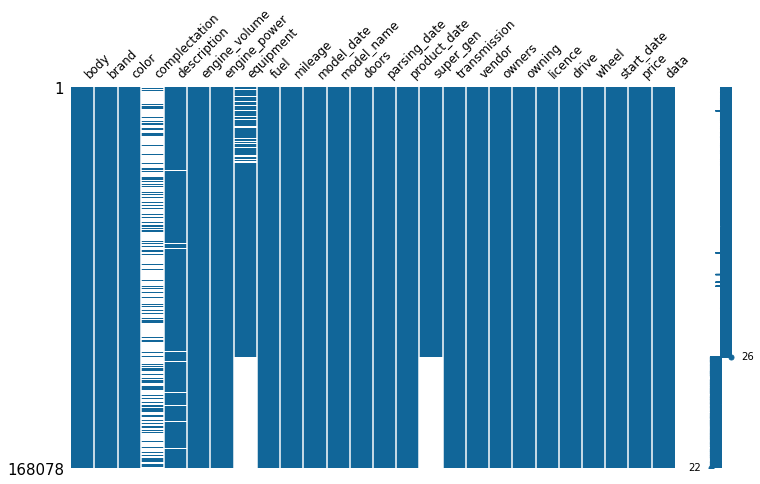

In [59]:
msno.matrix(data, figsize=(12, 7), fontsize=12, color=(0.07, 0.4, 0.6))

### Итого по датасету:

В получившемся датасете 168078 машин и 24 признака, исключая флаг датасета и целевую переменную. Из них 6 числовых, 14 строковых и 4 временных. Основная масса пропусков в столбцах со словарями.

Категории признаков:

* <code>body</code>, <code>brand</code>, <code>color</code>, <code>fuel</code>, <code>model_name</code>, <code>transmission</code>, <code>drive</code> - категориальные переменные

* <code>description</code> - текст

* <code>engine_volume</code>, <code>engine_power</code>, <code>mileage</code>, <code>doors</code>, <code>owners</code> - числовые переменные

* <code>equipment</code>, <code>complectation</code>, <code>super_gen</code> - словари

* <code>model_date</code>, <code>parsing_date</code>, <code>product_date</code>, <code>start_date</code> - временные переменные

* <code>vendor</code>, <code>owning</code>, <code>licence</code>, <code>wheel</code> - бинарные переменные

* <code>price</code> - целевая переменная  

В дальнейшем попробуем создать новые признаки на основе данных из словарей, а также попробуем достать что-нибудь из описания.

[К содержанию](#0)

---

<a id="3"></a>
# [3. Анализ и обработка признаков](#3)

<img align=center src="https://cdn.app.compendium.com/uploads/user/a7c086f7-9adb-4d2c-90fa-e26177af8317/c2dea8f7-8c26-44de-ae5f-5dc019485c8c/Image/60691dbc9e7de7390b93ea5284177459/data_analytics_banner.png" width="800" />

Разделим признаки на категории:

In [60]:
bin_lst = ['vendor', 'owning', 'licence', 'wheel']

cat_lst = ['body', 'brand', 'color', 'fuel', 'model_name', 'transmission', 'drive']

num_lst = ['engine_volume', 'engine_power', 'mileage', 'doors', 'owners']

Посмотрим на рапределение целевой переменной <code>price</code>:

### price

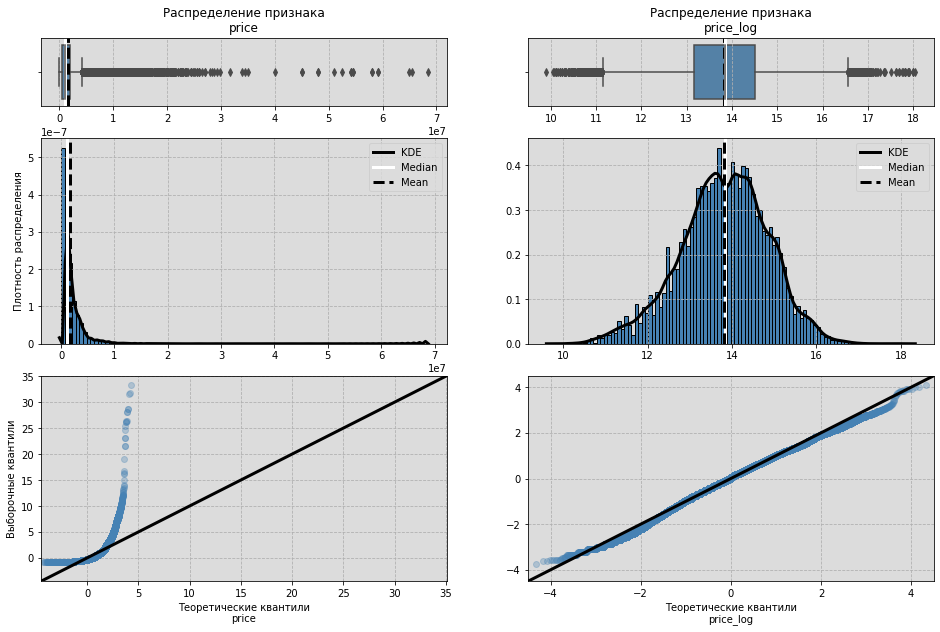

Left         Right
Границы выбросов price     -1.724000e+06  4.260000e+06
Кол-во выбросов price       0.000000e+00  9.079000e+03
Границы выбросов price_log  1.112903e+01  1.654919e+01
Кол-во выбросов price_log   1.162000e+03  2.840000e+02

---

In [61]:
num_col_analyze_general(data[data['price'] != 0], 'price')

Целевая переменная имеет тяжёлый правый хвост. Логарифмирование делает распределение близким к нормальному. Имеет смысл логорифмировать целевую переменную перед обучением модели.

<a id="3.1"></a>
# [3.1 Числовые признаки](#3.1)

Проанализируем числовые перменные в изначальном состоянии и после логорифмирования. А также проверим на выбросы.

### engine_volume

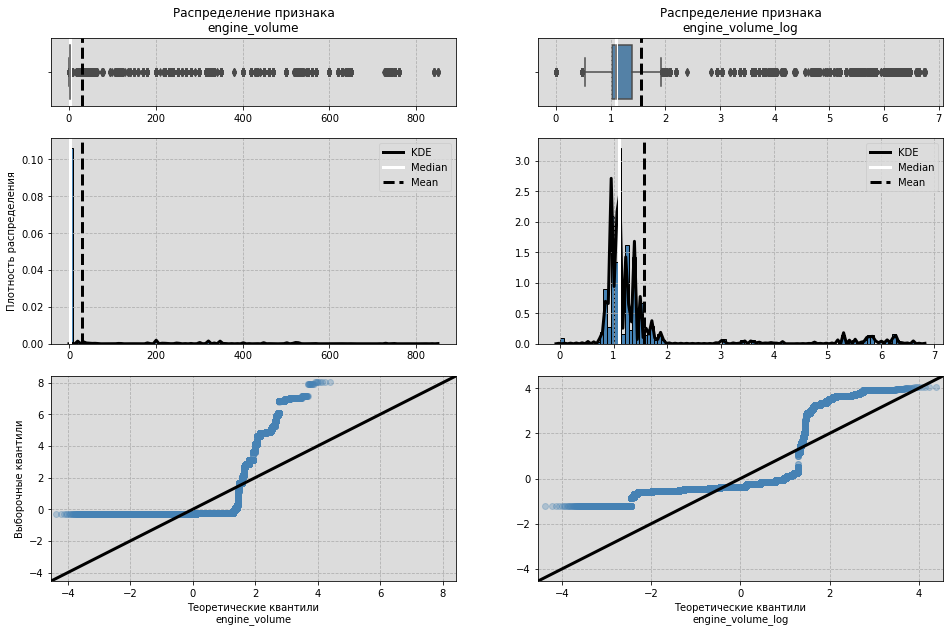

Left         Right
Границы выбросов engine_volume      2.220446e-16      4.800000
Кол-во выбросов engine_volume       1.155000e+03  19812.000000
Границы выбросов engine_volume_log  4.946070e-01      1.921307
Кол-во выбросов engine_volume_log   1.226000e+03  16857.000000

---

In [62]:
num_col_analyze_general(data, 'engine_volume')

Очевидно, что распределение ненормально и наблюдаются явные выбросы. На auto.ru нет машин от марок в нашей выборке с объемом двигателя больше 6.7: https://auto.ru/moskva/cars/used/?displacement_from=6700

In [63]:
len(data[data['engine_volume'] > 6.7])

16568

Записей со значением больше 6.7 очень много. Также наблюдается большое количество значений равных 0:

In [64]:
len(data[data['engine_volume'] == 0])

1155

На auto.ru объем не указан только у элетрокаров. Посмотрим, сколько их в выборке:

In [65]:
len(data[data['fuel'] == 'ELECTRO'])

149

Электрокаров в выборке значительно меньше, чем нулевых значений.  
Заменим все значения больше 6.7, а также все не электрокары с нулевым объемом двигателя пропусками, а пропуски заполним самыми популярными значениями по модели автомобиля:

In [66]:
data['engine_volume'] = data[['engine_volume', 'fuel']].apply(lambda x: np.nan if x[0] == 0 and 
                                                              x[1] != 'ELECTRO' else x[0], axis=1)
data['engine_volume'] = data['engine_volume'].apply(lambda x: np.nan if x >= 6.7 else x)
data['engine_volume'] = fill_missing(data, 'engine_volume', 'model_name')
# num_col_analyze_general(data, 'engine_volume')

Пропуски в столбце engine_volume заполнены


Другое дело - распределение стало близким к нормальному с длинным хвостом справа. Логарифмирование двигает распределение ближе к центру. Добавим признак в список на возможное логарифмирование:

In [67]:
psb_log_lst = ['engine_volume']

### engine_power

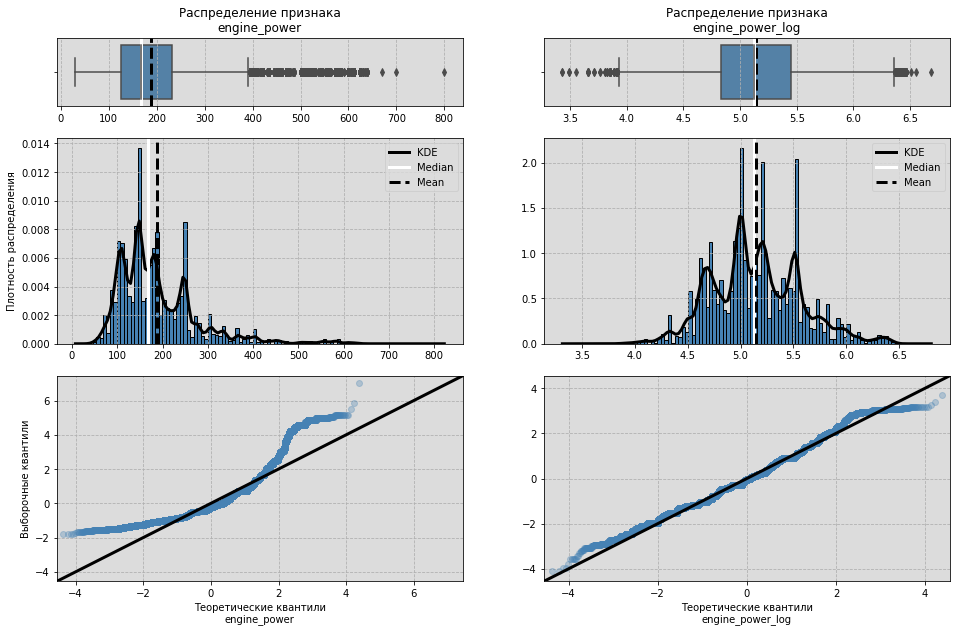

Left        Right
Границы выбросов engine_power     -34.000000   390.000000
Кол-во выбросов engine_power        0.000000  5664.000000
Границы выбросов engine_power_log   3.920599     6.362421
Кол-во выбросов engine_power_log   86.000000   884.000000

---

In [68]:
num_col_analyze_general(data, 'engine_power')

Cравним максимальные и минимальные значения в тестовой выборке и обучающей:

In [69]:
print('Максимальная мощность в тестовой выборке:', data[data['data'] == 'test']['engine_power'].max())
print('Минимальная мощность в тестовой выборке:', data[data['data'] == 'test']['engine_power'].min())
print('Максимальная мощность в обучающей выборке:', data[data['data'] != 'test']['engine_power'].max())
print('Минимальная мощность в обучающей выборке:', data[data['data'] != 'test']['engine_power'].min())

Максимальная мощность в тестовой выборке: 639.0
Минимальная мощность в тестовой выборке: 30.0
Максимальная мощность в обучающей выборке: 800.0
Минимальная мощность в обучающей выборке: 30.0


В обучающей выборе есть автомобили с большей мощностью, чем в тестовой. Посмотрим сколько их:

In [70]:
len(data[data['engine_power'] > 639])

3

Таких значений всего 3. В целях унификации удалим их из датасета:

In [71]:
data.drop(list(data[data['engine_power'] > 639].index), inplace=True)

Признак имеет распределение с длинным хвостом справа. Логарифмирование делает распределение близким к нормальному. Добавим в список логарифмирование и возможное скалирование (в дальнейшем проверим, что лучше себя покажет):

In [72]:
log_lst = ['engine_power']
psb_scal_lst = ['engine_power']

### mileage

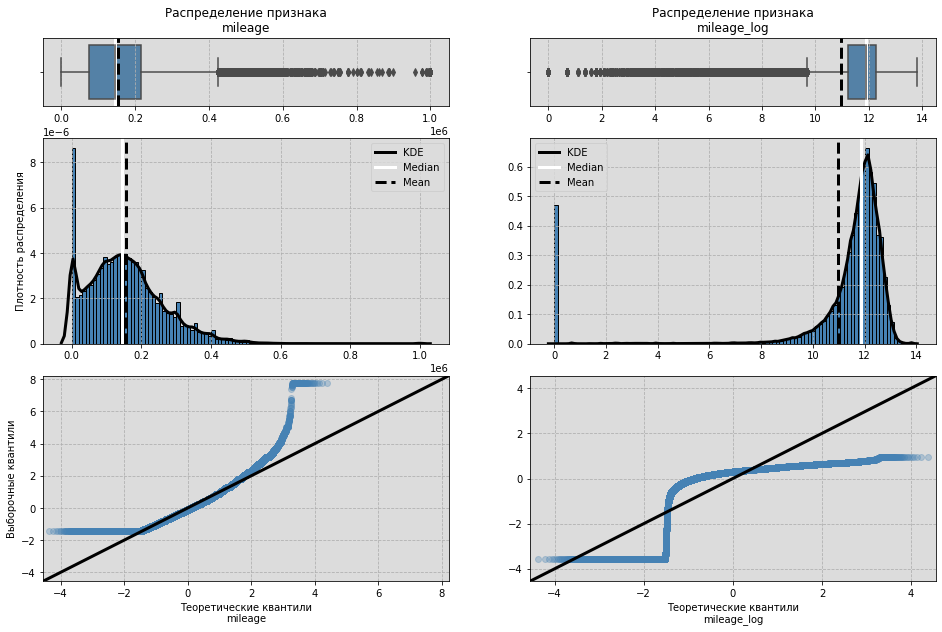

Left          Right
Границы выбросов mileage     -132981.250000  423788.750000
Кол-во выбросов mileage            0.000000    2996.000000
Границы выбросов mileage_log       9.672317      13.842046
Кол-во выбросов mileage_log    16548.000000       0.000000

---

In [73]:
num_col_analyze_general(data, 'mileage')

Очень много автомобилей с нулевым пробегом в датасете, где должны быть автомобили с пробегом. Посмотрим, сколько их всего:

In [74]:
len(data[data['mileage'] == 0])

10915

Автомобили с нулевым пробегом присутсвуют только в датасете за 20й год. Похоже в датасет попали объявления с новыми автомобилями от дилерских центров. Проверим несколько записей:

In [75]:
for value in data[data['mileage'] == 0]['description'].sample(10).values:
    print(value[:70], len(value),'\n')

Мы открыты! Купите новый BMW быстро и абсолютно безопасно.

При покупк 6149 

Фольксваген Центр Подольск готов сделать вам предложение за пределами  3270 

MAJOR - ОФИЦИАЛЬНЫЙ ДИЛЕР TOYOTA.
- 20 лет на рынке.
- Более 1000 авто 5544 

Только до 30 сентября колёса в сборе или каско в подарок при покупке A 3854 

Комплектация Premium


Предложение обновлено 09 сентября 2020г. в 10 ч 85 

Мы открыты! Купите новый BMW быстро и абсолютно безопасно.

При покупк 7937 

АВТОМИР - крупнейший дилер на российском авторынке, дилер №1 по продаж 5845 

Только в сентябре , Volvo Car АВИЛОН предлагает специальные условия на 7334 

Мы открыли свои двери для Вас!
Подробности по телефону.

Панавто – офи 4031 

———————————————————————————
ФУНКЦИОНАЛЬНОЕ ОБОРУДОВАНИЕ
—————————————— 6203 



Похоже на рекламные объявления. Нужно будет выделить подобные объявления в отдельный признак.

Распределение имеет длинный хвост справа. Логарифмирование переносит хвост влево. Так как значения в признаке довольно высокие, добавим его в список на возможное скалирование:

In [76]:
scal_lst = ['mileage']

### doors

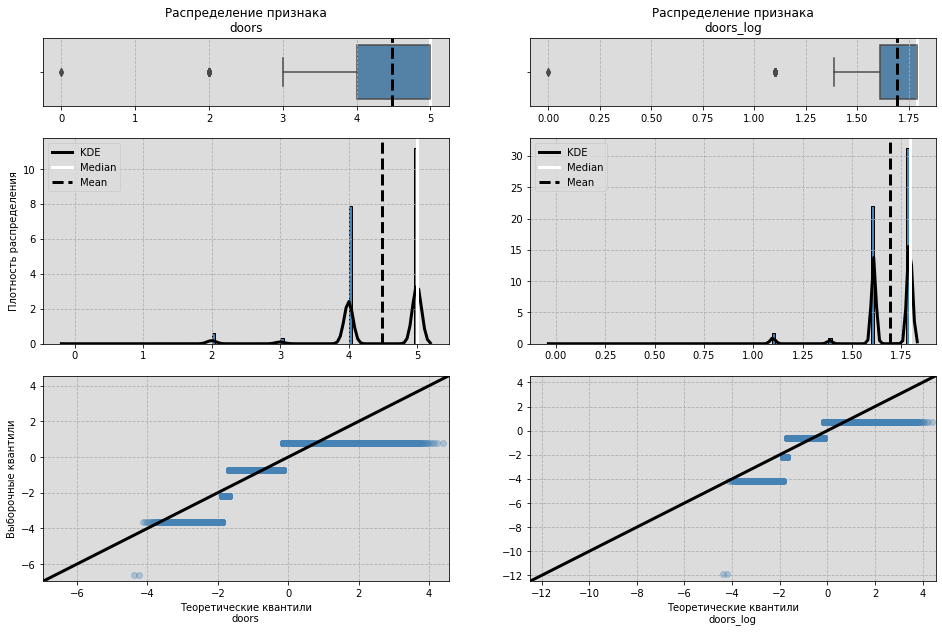

Left     Right
Границы выбросов doors         2.500000  6.500000
Кол-во выбросов doors       5024.000000  0.000000
Границы выбросов doors_log     1.335956  2.065242
Кол-во выбросов doors_log   5024.000000  0.000000

---

In [77]:
num_col_analyze_general(data, 'doors')

Cмущает нулевое значение в признаке. Что это за машина без дверей? Посмотрим:

In [78]:
data[data['doors'] == 0]

body     brand  color complectation  \
16944   кабриолет  MERCEDES  белый           NaN   
167492  кабриолет  MERCEDES  белый           NaN   

                                              description  engine_volume  \
16944   на ходу. 1904 год. стоит в гараже, пылится.Кат...            5.3   
167492  на ходу. 1904 год. стоит в гараже, пылится.Кат...            5.3   

        engine_power equipment      fuel  mileage model_date model_name  \
16944           32.0       NaN  GASOLINE    48000 1904-01-01    SIMPLEX   
167492          32.0      None  GASOLINE    48000 1904-01-01    SIMPLEX   

        doors        parsing_date product_date  \
16944     0.0 2020-10-21 02:04:03   1904-01-01   
167492    0.0 2020-09-09 00:00:00   1904-01-01   

                                                super_gen transmission  \
16944   {"id":"21743990","displacement":5322,"engine_t...   MECHANICAL   
167492                                               None   MECHANICAL   

          vendor  owners  owning   licence   drive  wheel start_date  \
16944   EUROPEAN     1.0       1  ORIGINAL  задний  RIGHT 2019-11-20   
167492  EUROPEAN     1.0       1  ORIGINAL  задний  RIGHT 2019-11-20   

             price   data  
16944          0.0   test  
167492  12000000.0  train

1904 год... Настоящий раритет:  

<img align=center src="https://autoru.naydex.net/Eh2yx5826/b20404wmbxpV/uzqbrCwMnuCi-IcKyx0aqMLosHkKxk0ZTgd6IxpKQKmstlZ8pP7J3GA-ZxZdzHM3tSHGFrCFqoPmChQt579LdZ8P6u09_Gs09kxCLt5IbikjjXQ4-lXvr4wECJEYSYYKXqdz2PFvLegWqKfjqVhkA-BlsiLXox1DYj5iKIJNu_eYm-hPyj8OYORp5HjafQqPIWpRHOpHbv6u5XrzKTkGim9GELlSyazq1-mRETpol8EgxGPRVDPucVMdkloATnvE8" width="800" />  

Нет вопросов - действительно 0 дверей. По-хорошему надо бы удалить этот автомобиль из выборки, но не поднимается рука.  

В целом в признаке немного значений. Максимальное не больше 5. Пока оставим признак, как есть.

### owners

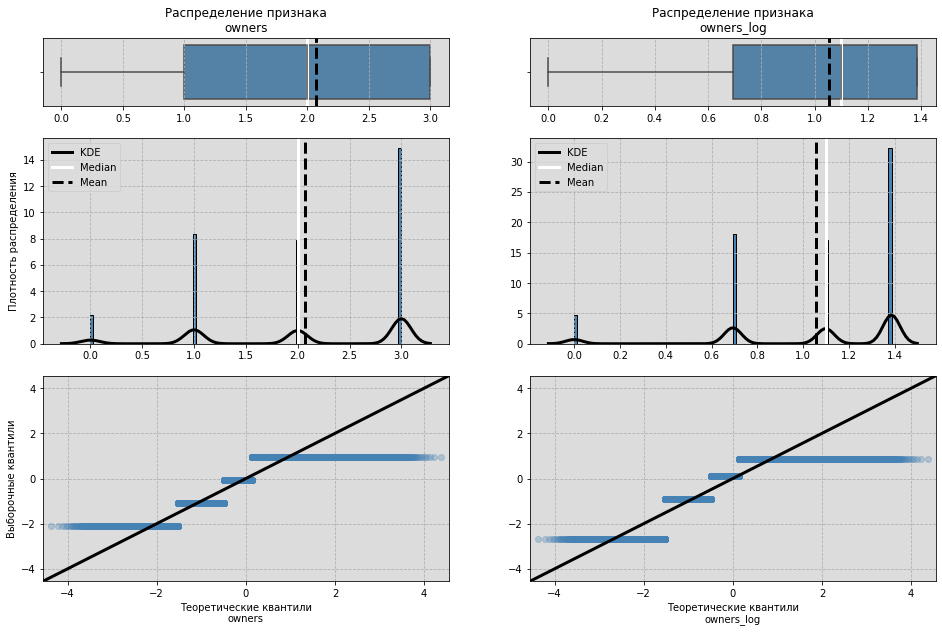

Left     Right
Границы выбросов owners     -2.000000  6.000000
Кол-во выбросов owners       0.000000  0.000000
Границы выбросов owners_log -0.346574  2.426015
Кол-во выбросов owners_log   0.000000  0.000000

---

In [79]:
num_col_analyze_general(data, 'owners')

В датасете за 20й год в этом столбце были пропуски. После обработок пропуски заменились нулями. Надо заменить на более подходящие значения. Предположим, что с количеством владельцев связан пробег:

----------------
Корреляция: 0.46
----------------


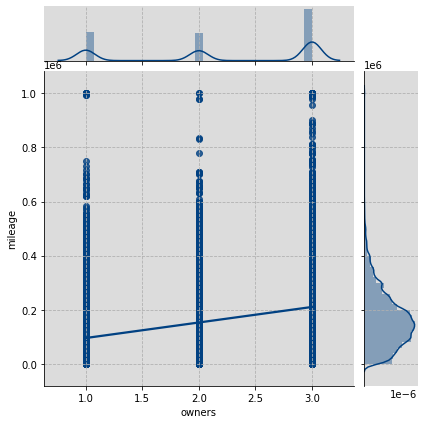

In [80]:
get_jointplot(data[data['owners'] != 0], 'owners', 'mileage')

Наблюдается достаточная положительная корреляция, которая може говорить нам: чем больше пробег, тем выше шансы, что владельцев было несколько. Попробуем заменить те нули, где не нулевой пробег, на релеватные значения на основе этой информации:

100%|██████████| 168075/168075 [00:02<00:00, 81443.85it/s]


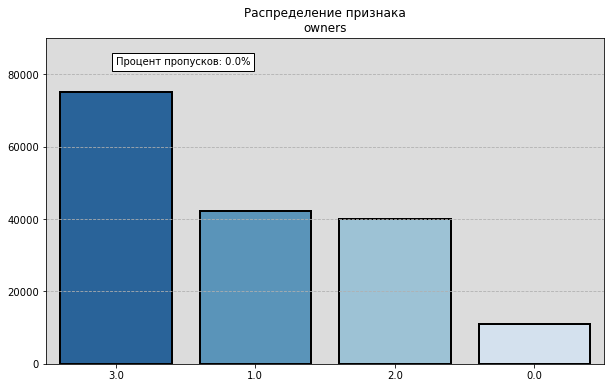

In [81]:
data['owners'] = data[['owners', 'mileage']].progress_apply(owners_processing, axis=1)
get_countplot(data, 'owners')

Машин с 3 владельцами и более в датасате примерно столько же, сколько машин с 1 и 2 владельцами в сумме.

Оценим значимость числовых признаков:

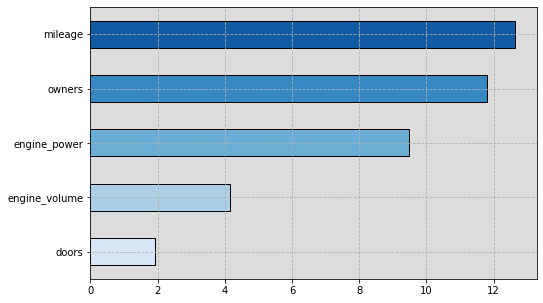

In [82]:
f_classifier(data[data['data'] != 'test'], num_lst, 'price')

Видно, что наибольшее влияние среди числовых признаков имеет пробег, а затем мощность двигателя. Выглядит достаточно логично.  

Помотрим на матрицу корреляций для числовых признаков:

In [83]:
corr_matrix(data[data['data'] != 'test'], num_lst, add_col='price', matrix_name='num_lst')

Критичных корреляций не наблюдается. Объяснимо высокая корреляция между объемом двигателя и его мощностью.

[К содержанию](#0)

---

<a id="3.2"></a>
# [3.2 Категориальные признаки](#3.2)

Посмотрим на распределения категориальных перменных:

### body

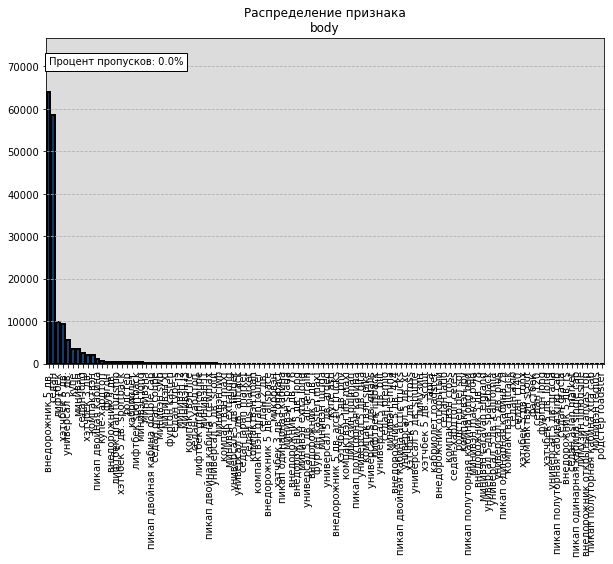

In [84]:
get_countplot(data, 'body', rotation='vertical')

Достаточно много разновидностей типов кузова:

In [85]:
print(len(data['body'].unique()))

114


Но в большинстве своем - это лишь вариации одних и тех же кузовов. Обобщим их по ключевому типу:

100%|██████████| 168075/168075 [00:00<00:00, 692592.79it/s]


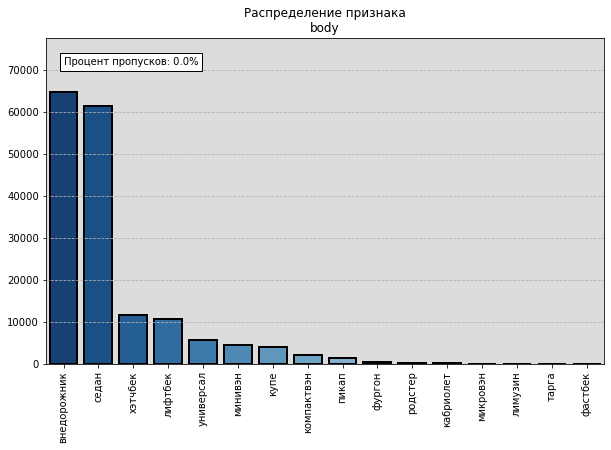

In [86]:
data['body'] = data['body'].progress_apply(body_processing)
get_countplot(data, 'body', rotation='vertical')

Есть два лидера - это внедорожники и седаны. Остальных типов в сумме меньше, чем седанов. Можно попробовать выделить эту информацию в отдельный признак.  

Посмотрим, как типы кузова отличаются по цене и мощности:

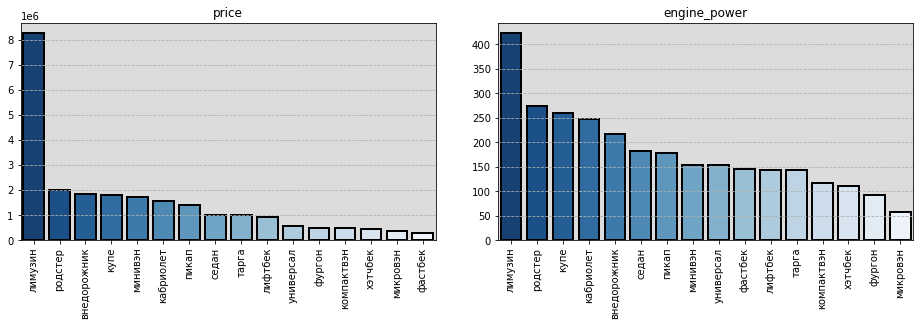

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plt.subplots_adjust(wspace=0.15)
axes = axes.flatten()

for i, func in enumerate(['price', 'engine_power']):
    col = data.groupby('body')[func].mean().sort_values(ascending=False)
    sns.barplot(x=col.index, y=col.values,
                  ax=axes[i], palette='Blues_r',
                  edgecolor='k',linewidth=2)
    axes[i].set_xticklabels(col.index, rotation='vertical')
    axes[i].set_title(func)
    axes[i].set_xlabel('')

По цене и мощности явно выделяется лимузин. Также можно заметить, что первые четыре места одинаковы.

### brand

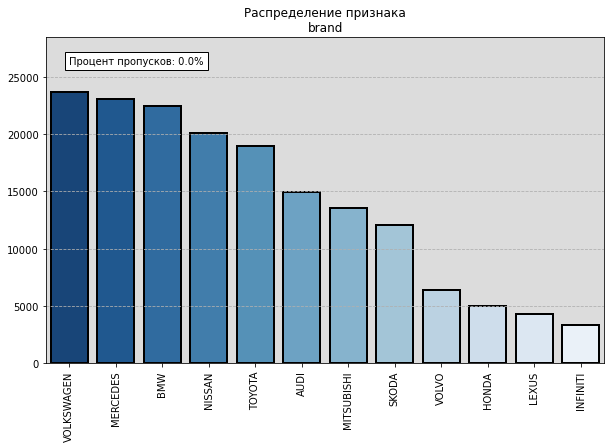

In [88]:
get_countplot(data, 'brand', rotation='vertical')

В датасете представлено 12 марок автомобилей. Марки разделяются на три примерные части по количеству. Посмотрим, как марки различаются по цене:

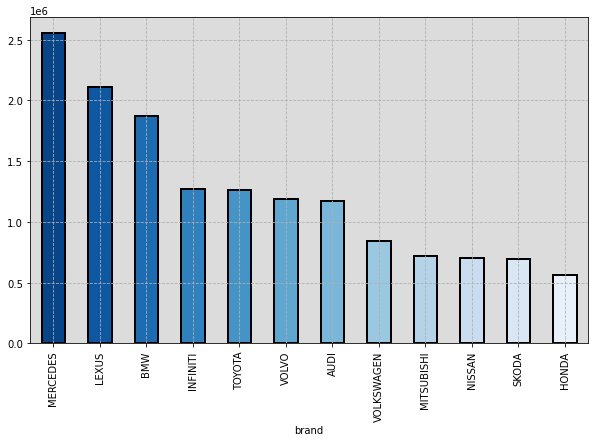

In [89]:
plt.rcParams['figure.figsize'] = (10,6)
data.groupby('brand')['price'].mean().sort_values(ascending=False).plot(kind='bar',
                                                                        edgecolor='k',
                                                                        linewidth=2,
                                                                        color=sns.color_palette('Blues_r', 12))

Лексус и Мерседес явно выделяются по средней цене. Также можно выделить 5 марок в нижнем ценовом диапазоне . Можно попробовать создать новый признак на основе этой информации.

### color

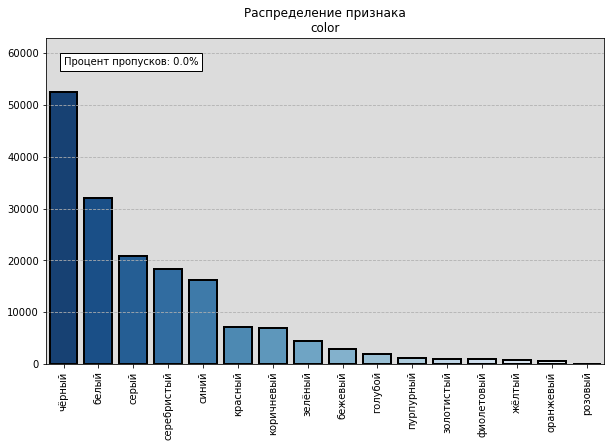

In [90]:
get_countplot(data, 'color', rotation='vertical')

Почти треть машин в датасете - черные. Можно выделить самые популярные цвета в отдельный признак.

### fuel

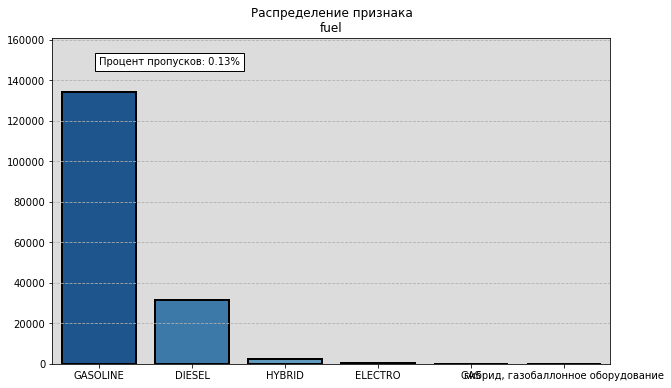

In [91]:
get_countplot(data, 'fuel')

В признаке присутствуют пропуски. Также нужно проверить, что объем двигателя всех электрокаров равен 0:

In [92]:
data[(data['fuel'] == 'ELECTRO')&(data['engine_volume'] != 0)]

body     brand   color complectation  \
127246  хэтчбек       BMW   белый           NaN   
127251  хэтчбек       BMW   серый           NaN   
160347  хэтчбек  MERCEDES  чёрный           NaN   

                                              description  engine_volume  \
127246  Автомобиль в наличии с ПТС , ГЛОНАС и ТД!!! Мо...            0.6   
127251  Состояние нового автомобиля . \nФото ИМЕННО ЭТ...            0.6   
160347  ЭЛЕКТРИЧЕСКИЙ!!! Запас хода 200 км. Уникальный...            1.6   

        engine_power equipment     fuel  mileage model_date model_name  doors  \
127246         170.0      None  ELECTRO    41000 2013-01-01         I3    5.0   
127251         170.0      None  ELECTRO    20000 2013-01-01         I3    5.0   
160347         179.0      None  ELECTRO    54100 2014-01-01   B_KLASSE    5.0   

       parsing_date product_date super_gen transmission    vendor  owners  \
127246   2020-09-09   2017-01-01      None    AUTOMATIC  EUROPEAN     1.0   
127251   2020-09-09   2017-01-01      None    AUTOMATIC  EUROPEAN     1.0   
160347   2020-09-09   2016-01-01      None    AUTOMATIC  EUROPEAN     1.0   

        owning   licence     drive wheel start_date      price   data  
127246       1  ORIGINAL    задний  LEFT 2020-07-21  2299000.0  train  
127251       1  ORIGINAL    задний  LEFT 2020-07-10  2099000.0  train  
160347       0  ORIGINAL  передний  LEFT 2020-08-28  1990000.0  train

Три электрокара в датасете за 20й год имеют объем двигателя отличный от 0. Судя по auto.ru, среди данных моделей действительно есть электрокары с подобной мощностью двигателя:  
https://auto.ru/moskva/cars/bmw/i3/all/engine-electro/  
https://auto.ru/moskva/cars/mercedes/b_klasse/all/engine-electro/  
Заменим эти значения 0, а также заполним пропуски самыми популярными значениями по модели автомобиля:

In [93]:
data['engine_volume'] = data[['engine_volume', 'fuel']].apply(lambda x: 0 if x[1] == 'ELECTRO' else x[0], axis=1)
data['fuel'] = fill_missing(data, 'fuel', 'model_name')

Пропуски в столбце fuel заполнены


### model_name

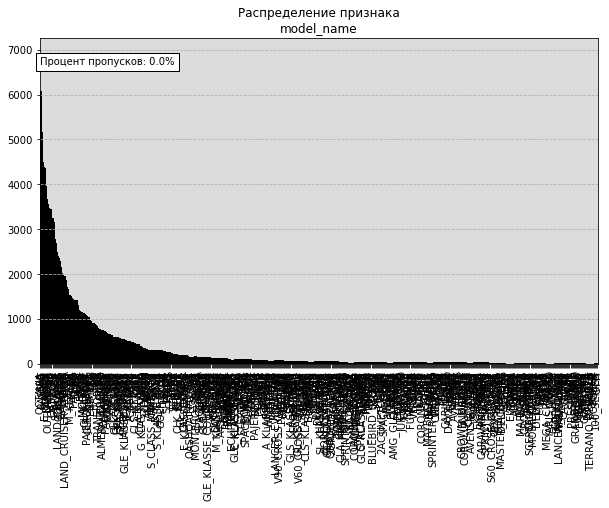

In [94]:
get_countplot(data, 'model_name', rotation='vertical')

В признаке очень много значений:

In [95]:
len(data['model_name'].unique())

544

Попробуем посмотреть на модели раздельно. Посмотрим на самые популярные и самые дорогие модели:

Text(0.5, 0, '')

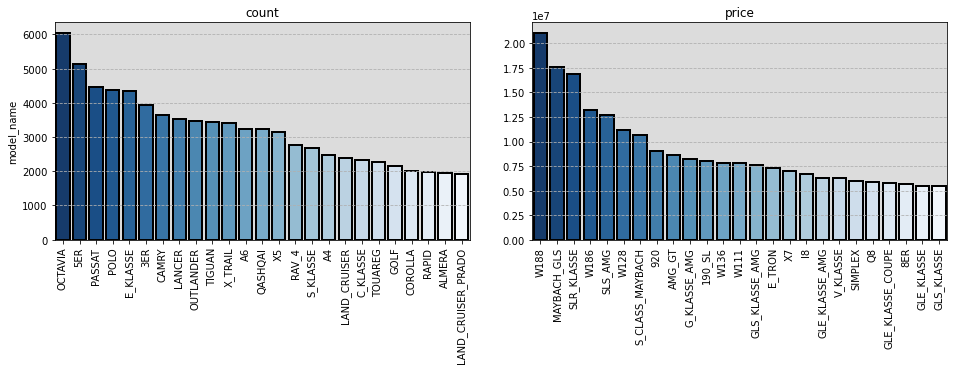

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plt.subplots_adjust(wspace=0.15)
axes = axes.flatten()

price_col = data.groupby('model_name')['price'].mean().sort_values(ascending=False)[:25]
count_col = data['model_name'].value_counts()[:25]
sns.barplot(x=price_col.index, y=price_col.values,
              ax=axes[1], palette='Blues_r',
              edgecolor='k',linewidth=2)
sns.barplot(x=count_col.index, y=count_col,
                  ax=axes[0], palette='Blues_r',
                  edgecolor='k',linewidth=2)
axes[1].set_xticklabels(price_col.index, rotation='vertical')
axes[0].set_xticklabels(count_col.index, rotation='vertical')
axes[1].set_title('price')
axes[0].set_title('count')
axes[1].set_xlabel('')
axes[0].set_xlabel('')

Явный лидер по количеству - Skoda Octavia. По цене - Mercedes W188. Можно выделить в отдельные признаи модели, которых больше среднего количества в выборке, а также модели, чья цена больше средней. 

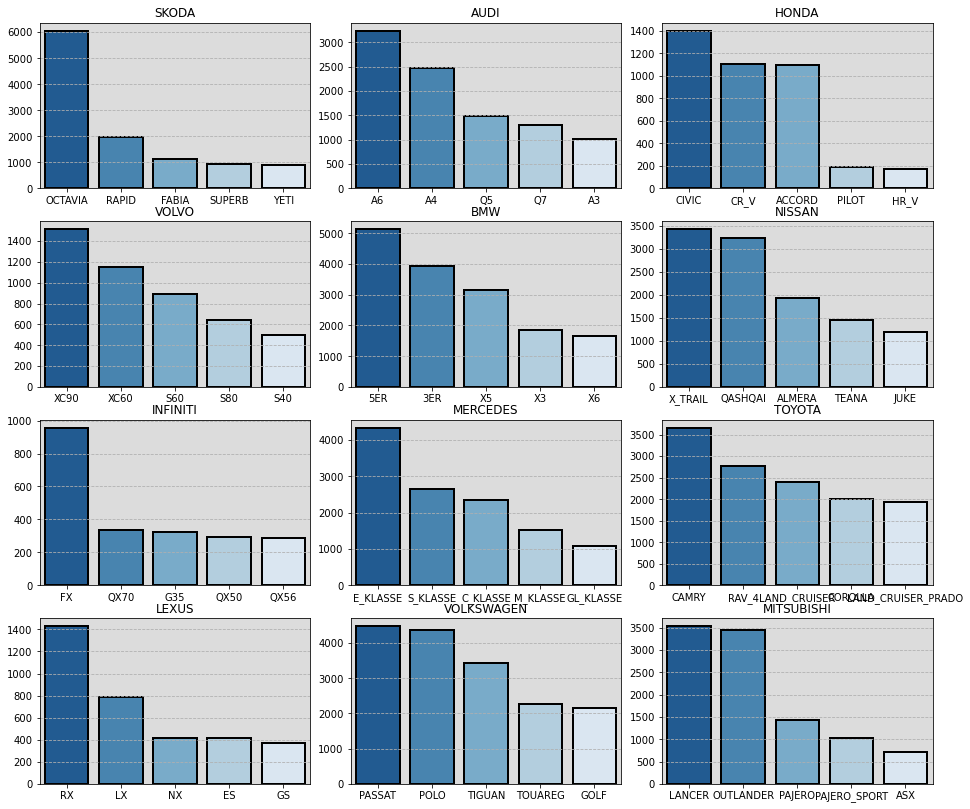

In [97]:
fig, axes = plt.subplots(4, 3, figsize=(16, 14))
plt.subplots_adjust(wspace=0.15)
axes = axes.flatten()

for i, brand in enumerate(data['brand'].unique()):
    col = data[data['brand'] == brand]['model_name'].value_counts()[:5]
    sns.barplot(x=col.index, y=col,
                  ax=axes[i], order=col.index,
                  palette='Blues_r',
                  edgecolor='k',
                  linewidth=2)
    axes[i].set_title(brand)
    axes[i].set_ylabel('')

Среди всех марок (кроме Nissan) можно определить популярную модель. Можно выделить эту информацию в отдельный признак.

### transmission

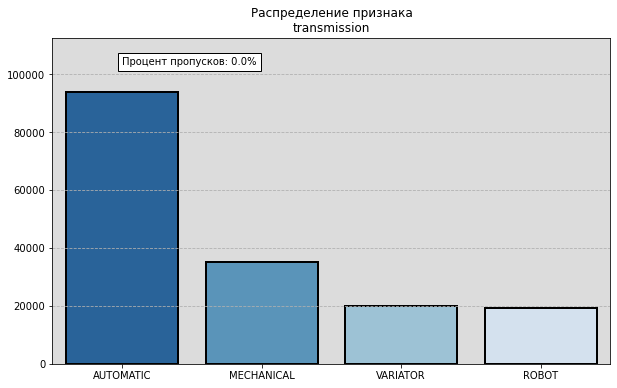

In [98]:
get_countplot(data, 'transmission')

Согласно auto.ru вариатор и робот - это разновидности автомата. Сократим количество значений до механики и автомата:

100%|██████████| 168075/168075 [00:00<00:00, 984449.85it/s]


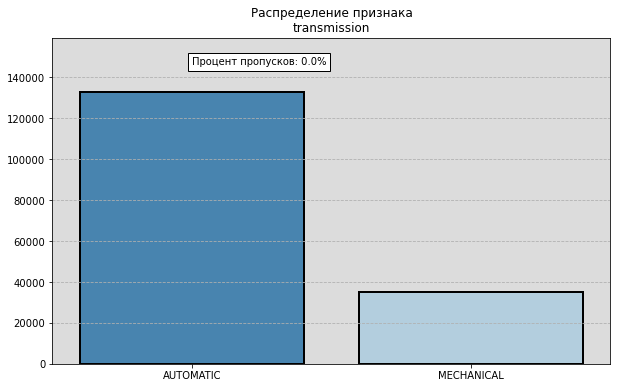

In [99]:
data['transmission'] = data['transmission'].progress_apply(lambda x: 'AUTOMATIC' if x != 'MECHANICAL' else x)
get_countplot(data, 'transmission')

### drive

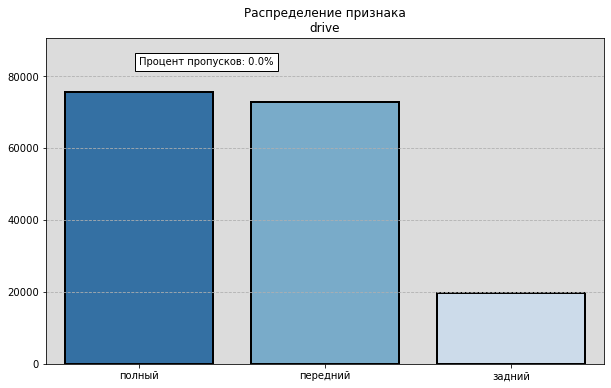

In [100]:
get_countplot(data, 'drive')

В основном автомобили в датасете либо переднеприводные, либо полноприводные.

Оценим значимость категориальных признаков для целевой переменной:

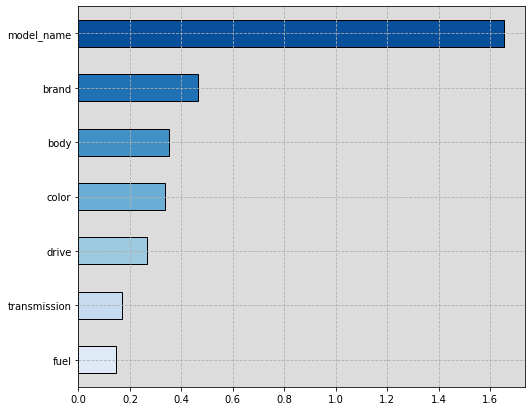

In [101]:
temp_data = data.copy()
for col in cat_lst:
    temp_data[col] = temp_data[col].astype('category').cat.codes
mutual_classifier(temp_data[temp_data['price'] != 0], cat_lst, 'price')

Модель автомобиля с существенным перевесом опережает остальные признаки в качестве значимого признака для целевой переменной.

Помотрим на матрицу корреляций для категориальных признаков:

In [102]:
corr_matrix(temp_data[temp_data['price'] != 0], cat_lst, add_col='price', matrix_name='cat_lst')

Критичных корреляций не наблюдается. По матрице есть взаимосвязь между типом кузова, моделью, и приводом. Похоже сказывается большое количество пятидверных внедорожников в выборке.

[К содержанию](#0)

---

<a id="3.3"></a>
# [3.3 Бинарные признаки](#3.3)

Посмотрим на распределения бинарных перменных:

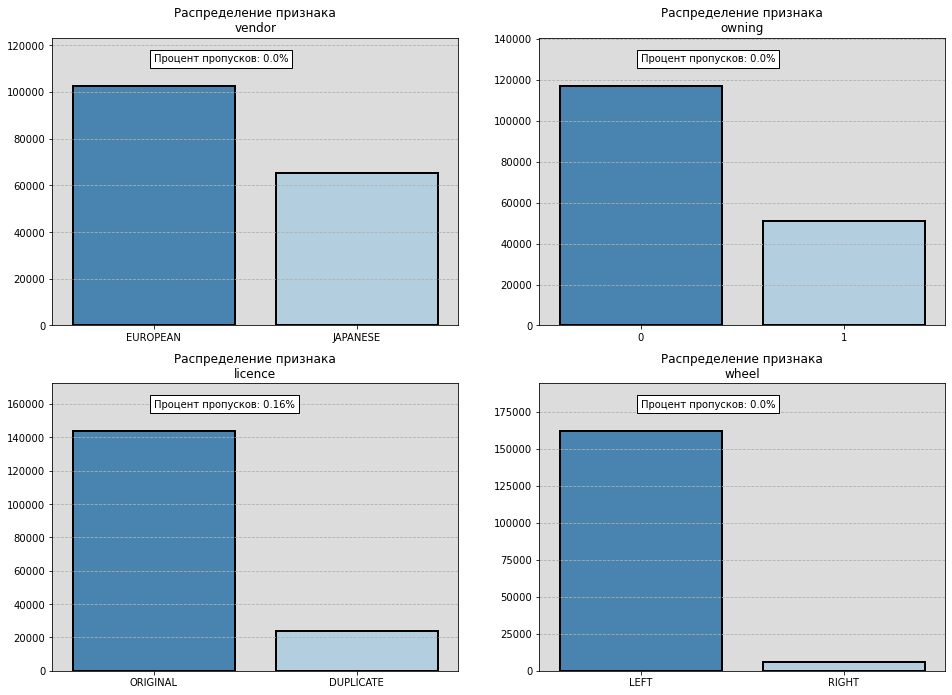

In [103]:
get_countplot(data, bin_lst)

По бинарным признакам особо сказать нечего. Подавляющее большинсто машин - леворульные, с оригинальным паспортом ТС. Европейцы в выборке превалируют на японцами. Только в 30% объявлений заполнена информация о владении.

В <code>licence</code> присутствуют пропуски. Заполним их случайными значениями признака в зависимости от веса:

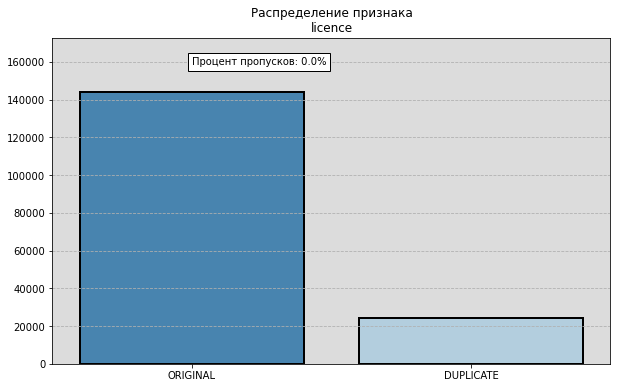

In [104]:
cat_fill_missing(data, 'licence')
get_countplot(data, 'licence')

Оценим значимость бинарных перменных вместе с категориальными:

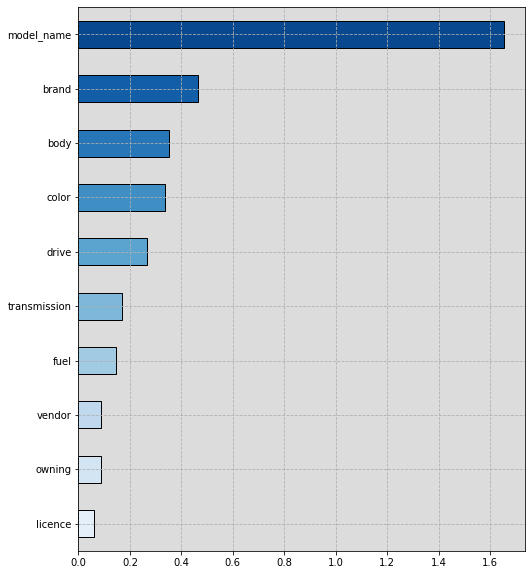

In [105]:
temp_data = data.copy()
for col in cat_lst+bin_lst:
    temp_data[col] = temp_data[col].astype('category').cat.codes
mutual_classifier(temp_data[temp_data['price'] != 0], cat_lst+bin_lst, 'price')

В целом бинарные признаки имеют меньшую значимость для целевой переменной, чем категориальные. Из бинарных признаков большую значимость имеет <code>vendor</code>. Предположу, что расположение руля и наличие паспорта показывают такие результаты из-за того, что в этих признаках одно значение сильно превалирует над другим.

Помотрим на матрицу корреляций вместе с категориальными и числовыми признаками:

In [106]:
corr_matrix(temp_data[temp_data['price'] != 0], cat_lst+bin_lst+num_lst, add_col='price', matrix_name='cat_lst+bin_lst+num_lst')

Критичные корреляции между всеми признаками отсутствуют. И интересного: корреляция между наличием оргинального паспорта и количеством владельцев, а также между пробегом и количеством владельцев.

In [107]:
display(temp_data[['licence', 'owners', 'mileage']].corr())

licence    owners   mileage
licence  1.000000 -0.330085 -0.264861
owners  -0.330085  1.000000  0.562724
mileage -0.264861  0.562724  1.000000

Можно предположить, что с каждым новым владельцем шанс сохранить оригинальный паспорт уменьшаются.

[К содержанию](#0)

---

<a id="3.4"></a>
# [3.4 Временные признаки](#3.4)

Посмотрим, автомобили каких годов самые популярные:

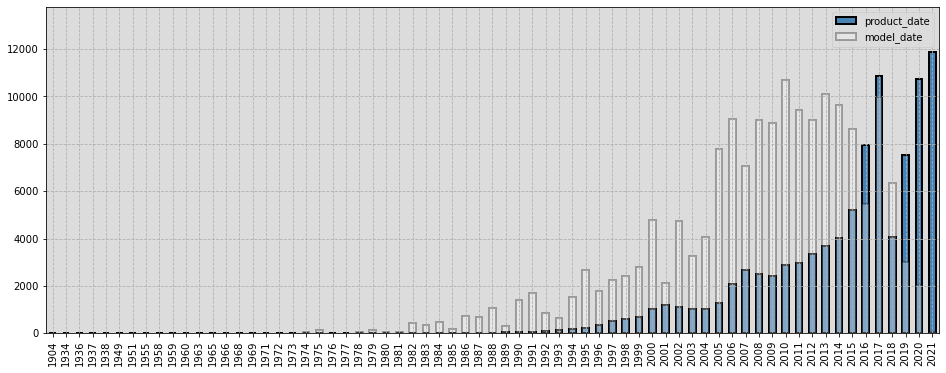

In [108]:
plt.rcParams['figure.figsize'] = (16,6)
data['product_date'].dt.year.value_counts().sort_index().plot(kind='bar',
                                                              edgecolor='k',
                                                              linewidth=2, 
                                                              color='steelblue')
data['model_date'].dt.year.value_counts().sort_index().plot(kind='bar',
                                                            edgecolor='k',
                                                            linewidth=2, 
                                                            color='w', 
                                                            alpha=0.3).legend()

3 последних года можно выделить в отдельный признак - популярные года. Также в отдельный признак можно выделить автомобили старше 30 лет.

Посмотрим на даты объявления:

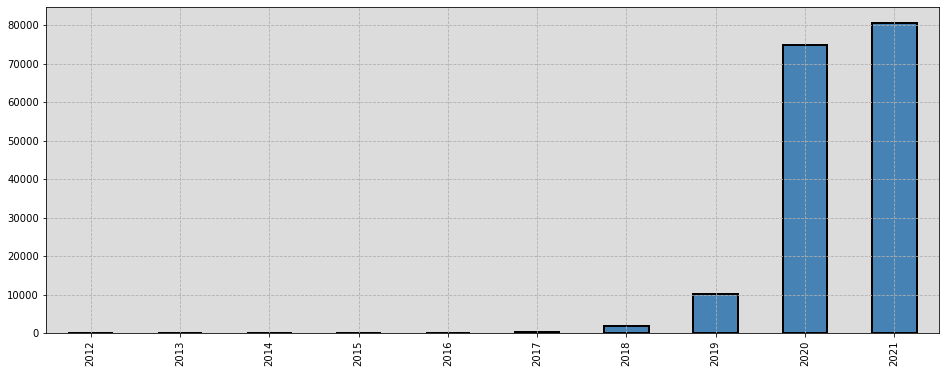

In [109]:
data['start_date'].dt.year.value_counts().sort_index().plot(kind='bar',
                                                              edgecolor='k',
                                                              linewidth=2, 
                                                              color='steelblue')

Наглядно видно, что обычно объявления висят не больше года. Можно выделить в отдельный признак объявления старше 2020 года.

### Итого по анализу признаков датасета:

* Почищен от выбросов признаки <code>engina_volume</code>, <code>mileage</code>
* Обобщены значения в признаках <code>body</code>, <code>transmission</code>
* Заменены нули в признаке <code>owners</code> в зависимости от пробега
* Заполнены пропуски в признаках <code>fuel</code> и <code>licence</code>
* Удалены несколько автомобилей из загруженного датасета, которых нет в тестовом датасете
* Европейские автомобили в выборке превалируют на японскими
* Обобощенный самый частый автомобиль в выборке - это черный полноприводный пятидверный внедорожник с автоматом
* Числовые признаки имеют большую значимость. Из нечисловых большую значимость показал признак <code>model_name</code>
* Со сменой владельца увеличивается шанс потерять оригинальный паспорт на ТС
* Найден классный старый автомобиль

Со словарями, временными переменными и описанием разберемся, когда будем создавать новые признаки, а пока построим проверочную модель.

[К содержанию](#0)

---

<a id="4"></a>
# [4. Проверочная модель](#4)

Построим проверочную модель, чтобы оценить качество начальных данных и ключевую метрику. В качестве проверочной модели используем __RandomForestRegressor__ на дефолтных настройках.

Соберем датасет для модели:

In [110]:
temp_data = temp_data[temp_data['data'] != 'test'][num_lst+cat_lst+bin_lst+['price']]

Разделим данные для обучения следующим образом:

In [111]:
X = temp_data.drop(['price'], axis=1)
y = temp_data['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

Обучим модель и посмотрим на результат:

In [112]:
test_model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)
MAPE = mape(y_test, y_pred)
printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

*Значение метрики* ***MAPE - 25.68%***

__25.68%__! Совсем неплохо для проверочной модели! Посмотрим, какие признаки оказались самыми важными для модели:

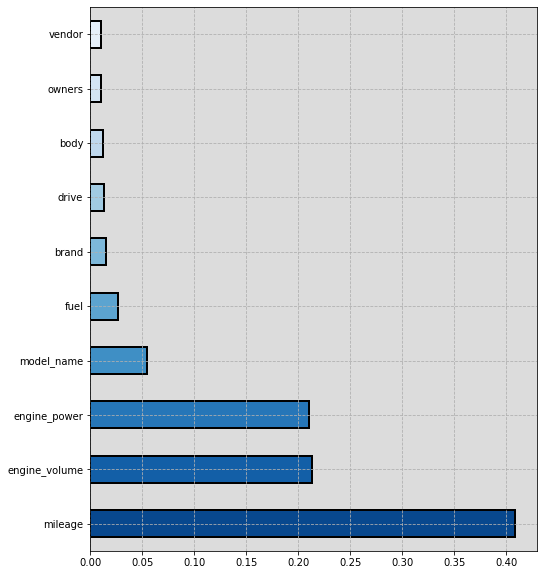

In [113]:
plt.rcParams['figure.figsize'] = (8,10)
feat_importances = pd.Series(test_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', 
                                   edgecolor='k', 
                                   linewidth=2, 
                                   color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>mileage</code>
* <code>engine_volume</code>
* <code>engine_power</code>  

Наболее важными признаками оказались числовые. Нужно будет попробовать создать больше числовых признаков.

[К содержанию](#0)

---

<a id="5"></a>
# [5. Создание новых признаков](#5)

<img align=center src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/Importance-Of-Feature-Engineering-In-DataHack-Competitions.jpg" width="800" />

Сначала разберемся со столбцами, в которых в качестве значений были словари. Их обработка была проведена отдельно. Ноутбук с пояснениями, в котором проводилась обработка: https://github.com/Chedered/SkillFactory/blob/main/DS/module-5/dict%20to%20df.ipynb  
Изначально из столбца <code>equipment_dict</code> получился с датафрейм с 266 уникальными опциями, которые затем были отфильтрованы и очищены от пропусков.  
Из столбца <code>super_gen</code> удалось вытянуть дополнительные технические характеристики: ускорение до 100, минимальный клиренс и расход топлива.  
На основе этих данных был создан датафрейм с 50 новыми признаками:

In [114]:
dict_data = pd.read_csv(DIR_PARSED+'dict_data.csv')

In [115]:
dict_data.sample(5)

airbag-driver   aux  isofix  electro-window-front  airbag-passenger  \
78256            True  True    True                  True              True   
115201           True  True    True                  True              True   
34148            True  True    True                  True              True   
65993            True  True    True                  True              True   
68109            True  True    True                  True              True   

        computer  seat-transformation  wheel-power  alarm  lock  \
78256       True                 True         True   True  True   
115201      True                 True         True   True  True   
34148       True                 True         True   True  True   
65993       True                 True         True   True  True   
68109       True                 True         True   True  True   

        electro-mirrors  electro-window-back   ptf  rain-sensor  airbag-side  \
78256              True                 True  True         True         True   
115201             True                 True  True         True         True   
34148              True                 True  True         True         True   
65993              True                 True  True         True         True   
68109              True                 True  True         True         True   

        audiosystem-cd  condition   abs  front-seats-heat  \
78256             True       True  True              True   
115201            True       True  True              True   
34148             True       True  True              True   
65993             True       True  True              True   
68109             True       True  True              True   

        wheel-configuration2  wheel-configuration1  12v-socket  park-assist-r  \
78256                   True                  True        True           True   
115201                  True                  True        True           True   
34148                   True                  True        True           True   
65993                   True                  True        True           True   
68109                   True                  True        True           True   

        cruise-control   esp   usb  light-sensor  tyre-pressure  mirrors-heat  \
78256             True  True  True          True          False          True   
115201            True  True  True          True           True          True   
34148             True  True  True          True           True          True   
65993             True  True  True          True           True          True   
68109             True  True  True          True           True          True   

        bluetooth  immo  multi-wheel  front-centre-armrest   hcc  \
78256        True  True         True                  True  True   
115201       True  True         True                  True  True   
34148        True  True         True                  True  True   
65993        True  True         True                  True  True   
68109        True  True         True                  True  True   

        airbag-curtain  light-cleaner  wheel-leather  auto-mirrors  \
78256             True           True           True          True   
115201            True           True           True          True   
34148             True           True           True          True   
65993             True           True           True          True   
68109             True           True           True          True   

        third-rear-headrest  climate-control-1  park-assist-f  leather  servo  \
78256                  True               True           True     True   True   
115201                 True               True           True     True   True   
34148                  True               True           True     True   True   
65993                  True               True           True     True   True   
68109                  True               True           True     True   

Распределим новые признаки по категориям и объеденим датафреймы:

In [116]:
new_bin_lst = list(dict_data.columns)[:-3]
new_num_lst = list(dict_data.columns)[-3:]
data = data.reset_index(drop=True).join(dict_data)

Создадим новые признаки на основе временных (<code>model_date</code>, <code>parsing_date</code>, <code>product_date</code>, <code>start_date</code>):

In [117]:
# Разница в днях между датой размещения объявления и датой сбора данных
data['start_date_to_parsing_date'] = abs((data['parsing_date'] - data['start_date']).dt.days)
# Разница в днях между датой производства автомобиля и датой размещения объявления
data['product_date_to_start_date'] = abs((data['start_date'] - data['product_date']).dt.days)
# Разница в днях между датой выпуска модели и датой производства автомобиля
data['model_date_to_product_date'] = abs((data['product_date'] - data['model_date']).dt.days)
new_num_lst += ['start_date_to_parsing_date', 'product_date_to_start_date', 'model_date_to_product_date']

Создадим новый признак на основе описаний из <code>description</code>:

In [118]:
# Кол-во слов в объявлении
data['words_count'] = data['description'].progress_apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0)
new_num_lst += ['words_count']

100%|██████████| 168075/168075 [00:01<00:00, 99160.62it/s]


Создадим новые бинарные признаки:

In [119]:
# Флаг очень старого автомобиля
data['old_car'] = data['product_date'].progress_apply(lambda x: 1 if x.year < 1992 else 0)
# Флаг относительно нового автомобиля
data['new_car'] = data['mileage'].progress_apply(lambda x: 1 if x == 0 else 0)
# Флаг машины не старше 3х лет
data['three_old'] = data['product_date'].progress_apply(lambda x: 1 if x.year > 2018 else 0)
# Флаг машины не старше 5и лет
data['five_old'] = data['product_date'].progress_apply(lambda x: 1 if x.year > 2016 else 0)
# Флаг объявления старше 2020 года
data['old_adv'] = data['start_date'].progress_apply(lambda x: 0 if x.year < 2020 else 1)
# Флаг года сбора данных
data['year'] = data['data'].progress_apply(lambda x: 1 if x == 'parsed' else 0)
# Флаг популярного цвета
popular_color = data['color'].value_counts() > data['color'].value_counts().values.mean()
popular_color_dict = popular_color.to_dict()
data['popular_color'] = data['color'].map(popular_color_dict)
# Флаг марки, чья цена выше среднего
price_brand = data.groupby('brand')['price'].mean() > np.mean(data.groupby('brand')['price'].mean())
price_brand_dict = price_brand.to_dict()
data['price_brand'] = data['brand'].map(price_brand_dict)
# Флаг популярной модели
popular_model = data['model_name'].value_counts() > data['model_name'].value_counts().values.mean()
popular_model_dict = popular_model.to_dict()
data['popular_model'] = data['model_name'].map(popular_model_dict)
# Флаг популярной модели по марке
models_lst = []
for brand in data['brand'].unique():
    models_lst.append(data[data['brand'] == brand]['model_name'].value_counts().idxmax())
data['popular_model_in_brand'] = data['model_name'].progress_apply(lambda x: 1 if x in models_lst else 0)
# Флаг модели, чья цена выше среднего
price_model = data.groupby('model_name')['price'].mean() > np.mean(data.groupby('model_name')['price'].mean())
price_model_dict = price_model.to_dict()
data['price_model'] = data['model_name'].map(price_model_dict)
new_bin_lst += ['old_car', 
                'new_car', 
                'three_old', 
                'five_old', 
                'old_adv', 
                'year',
                'popular_color',
                'price_brand', 
                'popular_model', 
                'popular_model_in_brand', 
                'price_model']

100%|██████████| 168075/168075 [00:00<00:00, 696424.36it/s]


Создадим новые числовые признаки:

In [120]:
temp_lst = ['body', 'model_name']
# Среднее и ст. отклонение пробега по типу кузова и модели:
mileage = num_of_cols(data, temp_lst, 'mileage')
# Среднее и ст. отклонение мощности по типу кузова и модели:
engine_power = num_of_cols(data, temp_lst, 'engine_power')
# Среднее и ст. отклонение возраста автомобиля по типу кузова и модели:
product_date_model = num_of_cols(data, temp_lst, 'product_date_to_start_date')
new_num_lst += mileage+engine_power+product_date_model

Созданы ['mean_mileage_body', 'std_mileage_body', 'mean_mileage_model_name', 'std_mileage_model_name']
Созданы ['mean_engine_power_body', 'std_engine_power_body', 'mean_engine_power_model_name', 'std_engine_power_model_name']
Созданы ['mean_product_date_to_start_date_body', 'std_product_date_to_start_date_body', 'mean_product_date_to_start_date_model_name', 'std_product_date_to_start_date_model_name']


In [121]:
# Различные производные из числовых признаков
data['product_volume_fuel_rate'] = (data['engine_volume']/data['fuel_rate'])*np.sqrt(data['product_date_to_start_date'])
data['mileage_age'] = data['mileage']/data['product_date_to_start_date']
new_num_lst += ['product_volume_fuel_rate']+['mileage_age']

Заполним возможные пропуски в числовых признаках:

In [122]:
for col in new_num_lst:
    data[col].fillna(0, inplace=True)

Проанализируем новые числовые признаки (под катом):

### acceleration

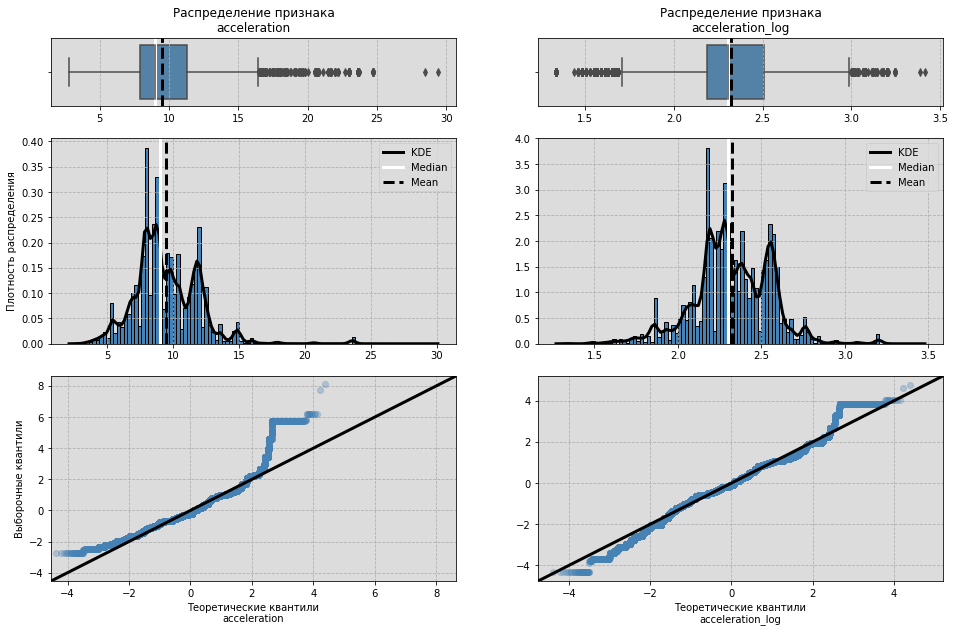

Left        Right
Границы выбросов acceleration         2.800000    16.400000
Кол-во выбросов acceleration          0.000000  1394.000000
Границы выбросов acceleration_log     1.700729     2.994921
Кол-во выбросов acceleration_log   1390.000000   948.000000

---

### clearance_min

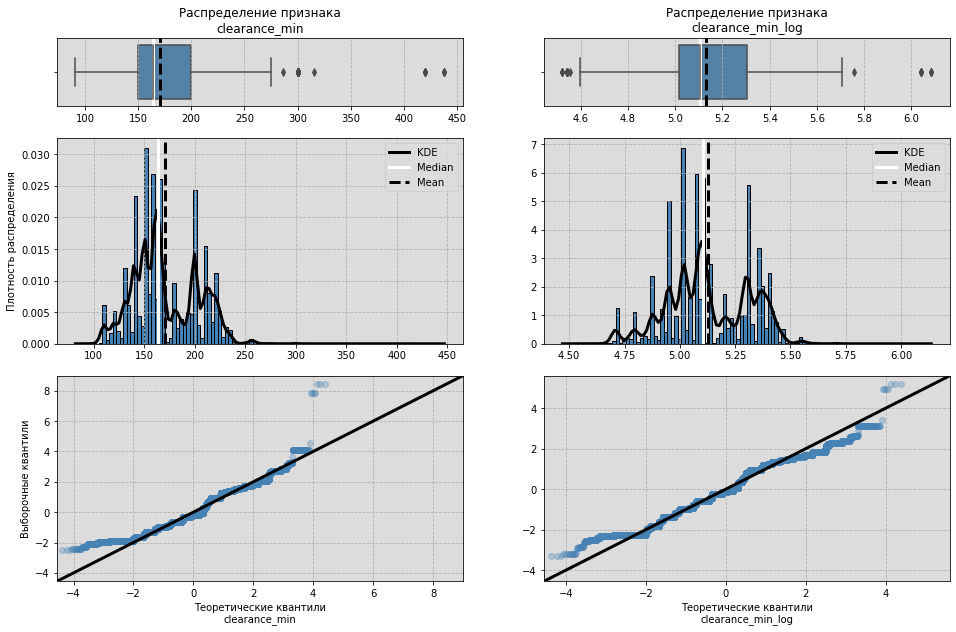

Left       Right
Границы выбросов clearance_min      75.000000  275.000000
Кол-во выбросов clearance_min        0.000000   79.000000
Границы выбросов clearance_min_log   4.588242    5.732343
Кол-во выбросов clearance_min_log   15.000000    8.000000

---

### fuel_rate

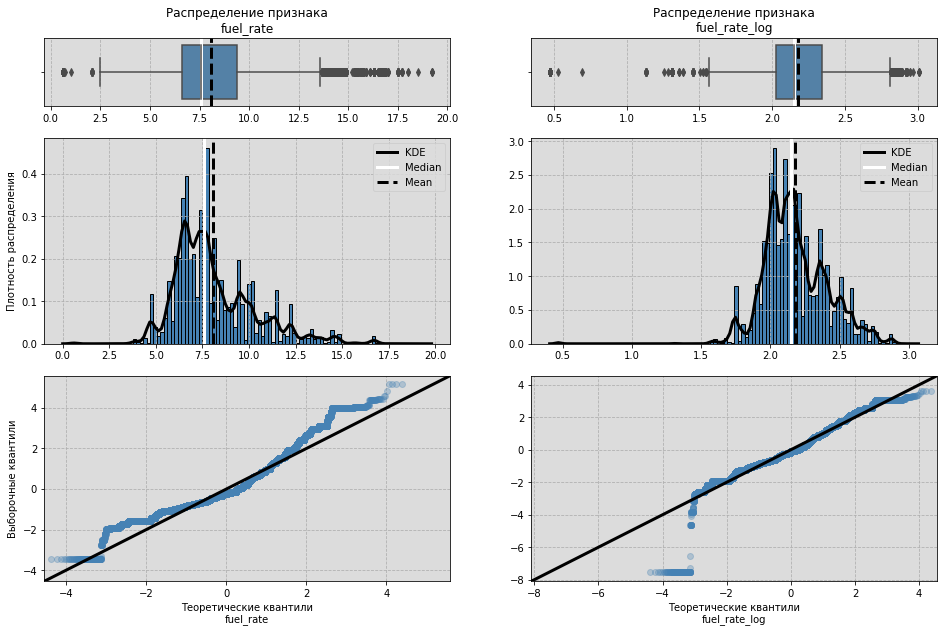

Left        Right
Границы выбросов fuel_rate        2.400000    13.600000
Кол-во выбросов fuel_rate       156.000000  4053.000000
Границы выбросов fuel_rate_log    1.557662     2.812292
Кол-во выбросов fuel_rate_log   224.000000   925.000000

---

### start_date_to_parsing_date

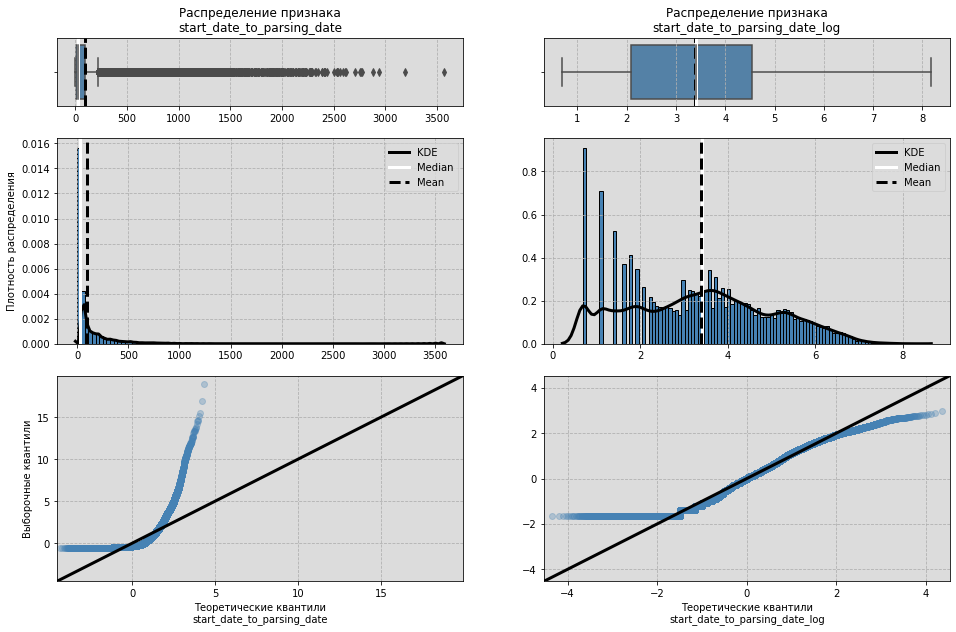

Left         Right
Границы выбросов start_date_to_parsing_date     -120.500000    219.500000
Кол-во выбросов start_date_to_parsing_date         0.000000  19420.000000
Границы выбросов start_date_to_parsing_date_log   -1.600295      8.212336
Кол-во выбросов start_date_to_parsing_date_log     0.000000      0.000000

---

### product_date_to_start_date

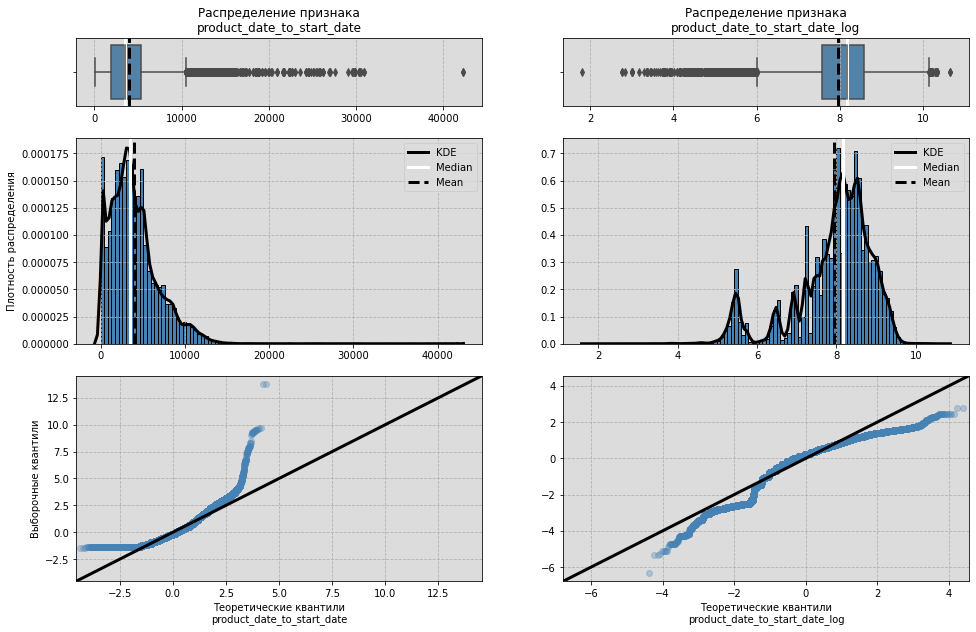

Left        Right
Границы выбросов product_date_to_start_date      -3250.500000  10529.50000
Кол-во выбросов product_date_to_start_date           0.000000   4940.00000
Границы выбросов product_date_to_start_date_log      6.016677     10.12964
Кол-во выбросов product_date_to_start_date_log   12162.000000     36.00000

---

### model_date_to_product_date

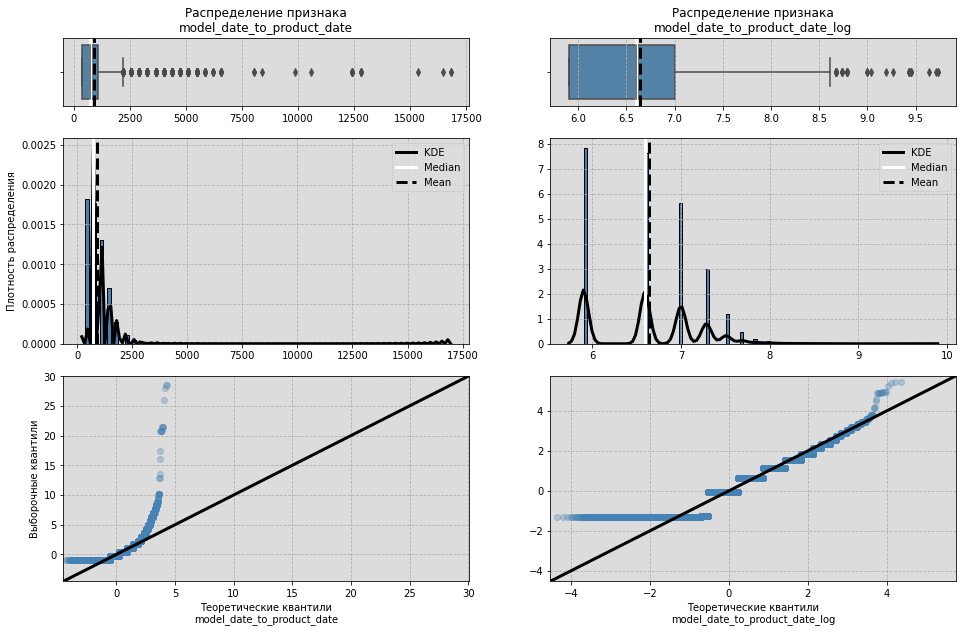

Left        Right
Границы выбросов model_date_to_product_date     -729.000000  2191.000000
Кол-во выбросов model_date_to_product_date         0.000000  3678.000000
Границы выбросов model_date_to_product_date_log    4.262903     8.642793
Кол-во выбросов model_date_to_product_date_log     0.000000    38.000000

---

### words_count

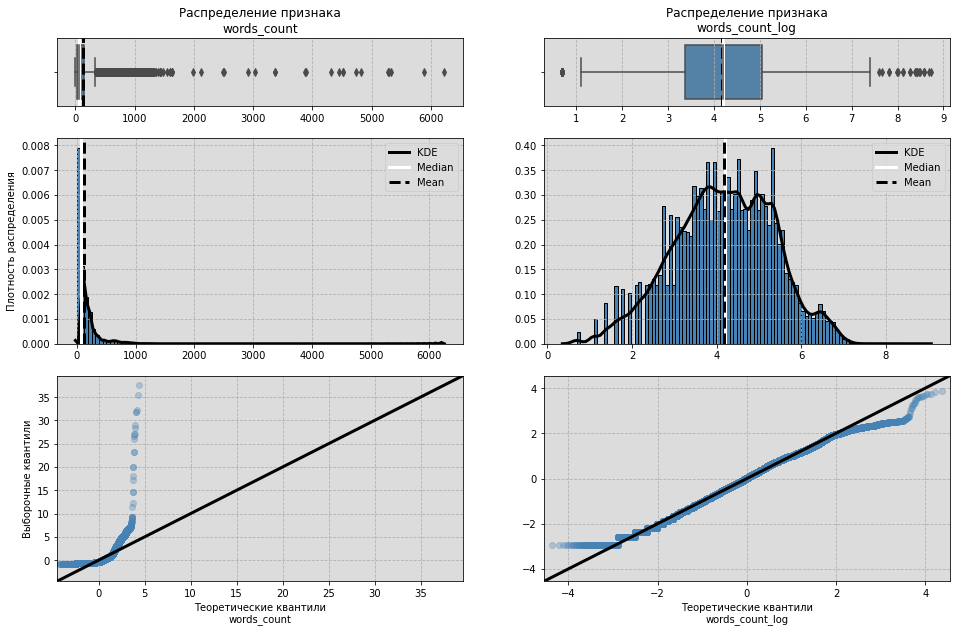

Left         Right
Границы выбросов words_count     -159.500000    340.500000
Кол-во выбросов words_count         0.000000  11335.000000
Границы выбросов words_count_log    0.862811      7.541438
Кол-во выбросов words_count_log   313.000000     21.000000

---

### mean_mileage_body

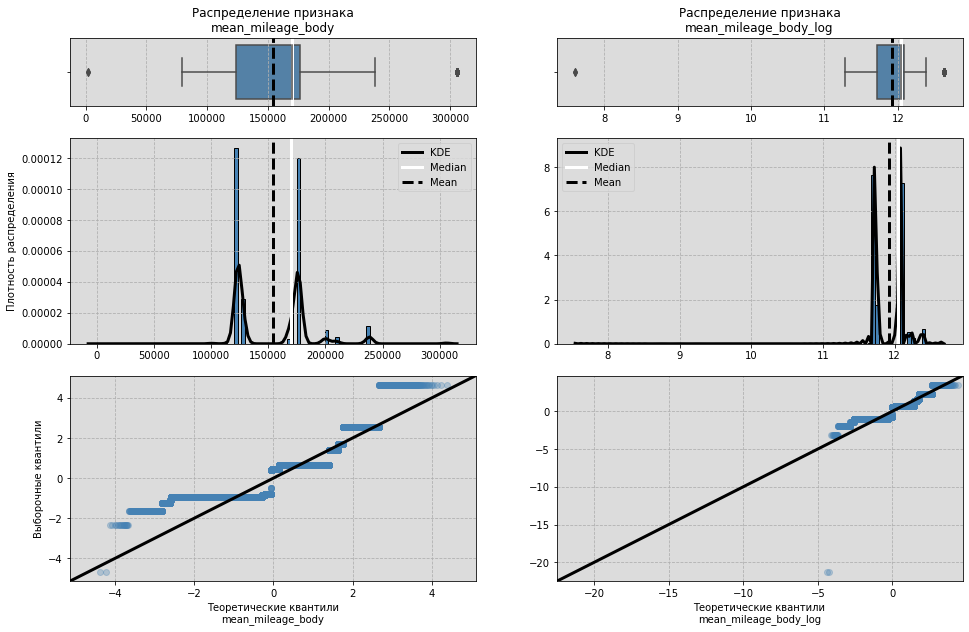

Left          Right
Границы выбросов mean_mileage_body      44052.169801  255616.168899
Кол-во выбросов mean_mileage_body           2.000000     622.000000
Границы выбросов mean_mileage_body_log     11.188008      12.614928
Кол-во выбросов mean_mileage_body_log       2.000000     622.000000

---

### std_mileage_body

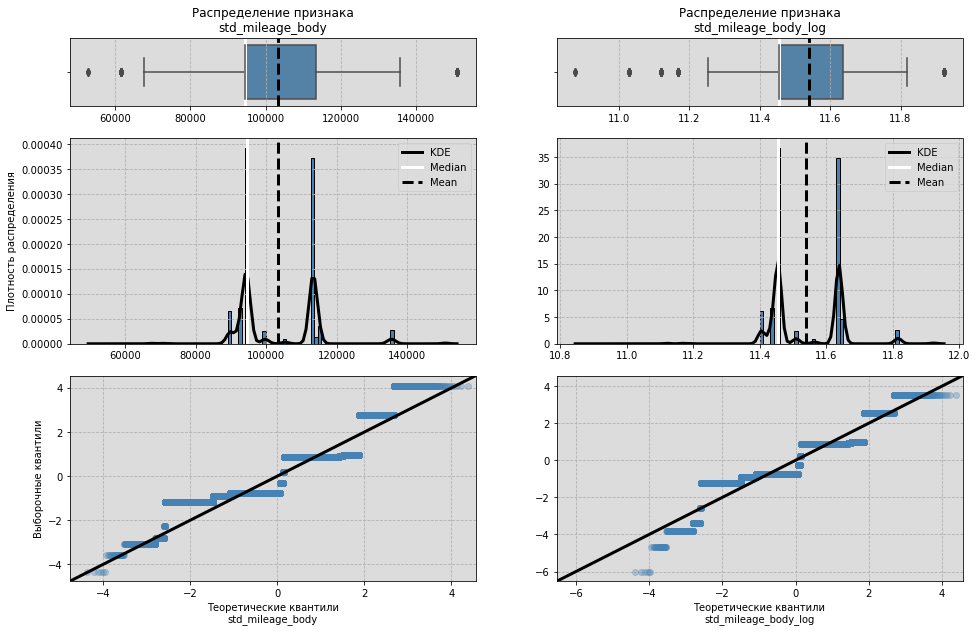

Left          Right
Границы выбросов std_mileage_body      66186.474175  141501.829580
Кол-во выбросов std_mileage_body          34.000000     622.000000
Границы выбросов std_mileage_body_log     11.182898      11.910161
Кол-во выбросов std_mileage_body_log     783.000000     622.000000

---

### mean_mileage_model_name

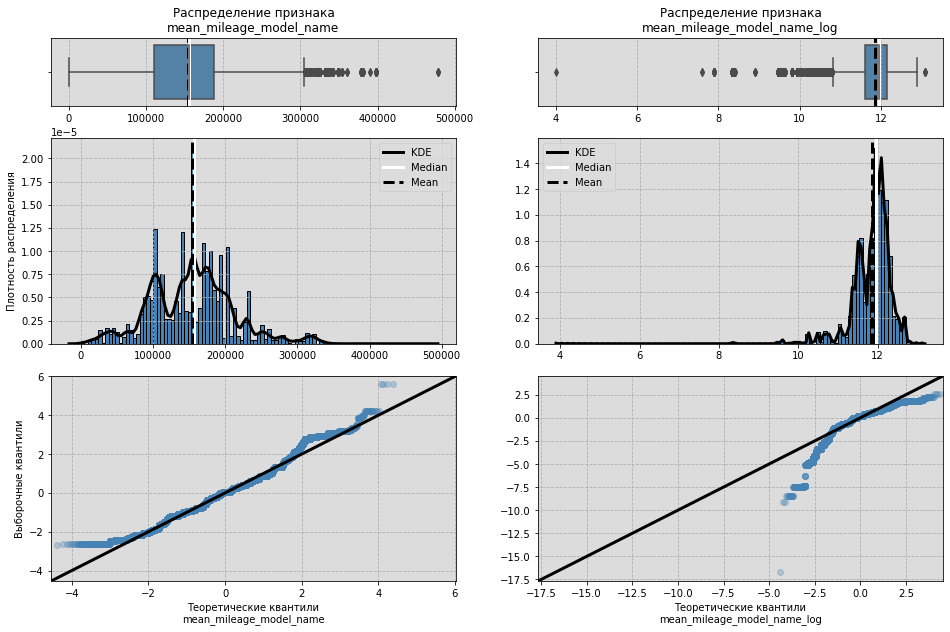

Left          Right
Границы выбросов mean_mileage_model_name     -6331.145887  305504.166417
Кол-во выбросов mean_mileage_model_name          0.000000    3388.000000
Границы выбросов mean_mileage_model_name_log    10.813559      12.947398
Кол-во выбросов mean_mileage_model_name_log   6882.000000       4.000000

---

### std_mileage_model_name

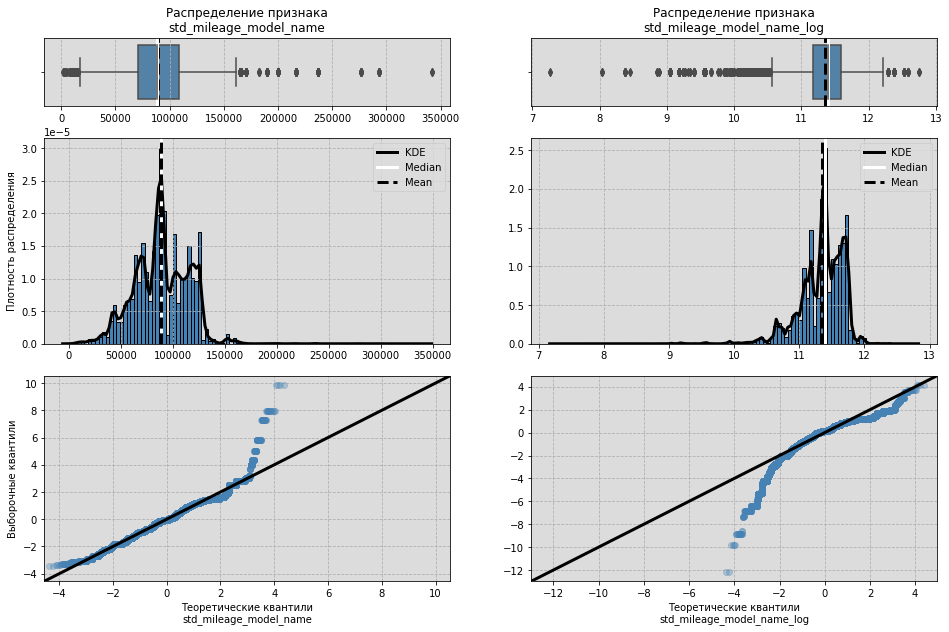

Left          Right
Границы выбросов std_mileage_model_name      15646.791397  163852.388437
Кол-во выбросов std_mileage_model_name         479.000000     315.000000
Границы выбросов std_mileage_model_name_log     10.545332      12.220707
Кол-во выбросов std_mileage_model_name_log    3439.000000      95.000000

---

### mean_engine_power_body

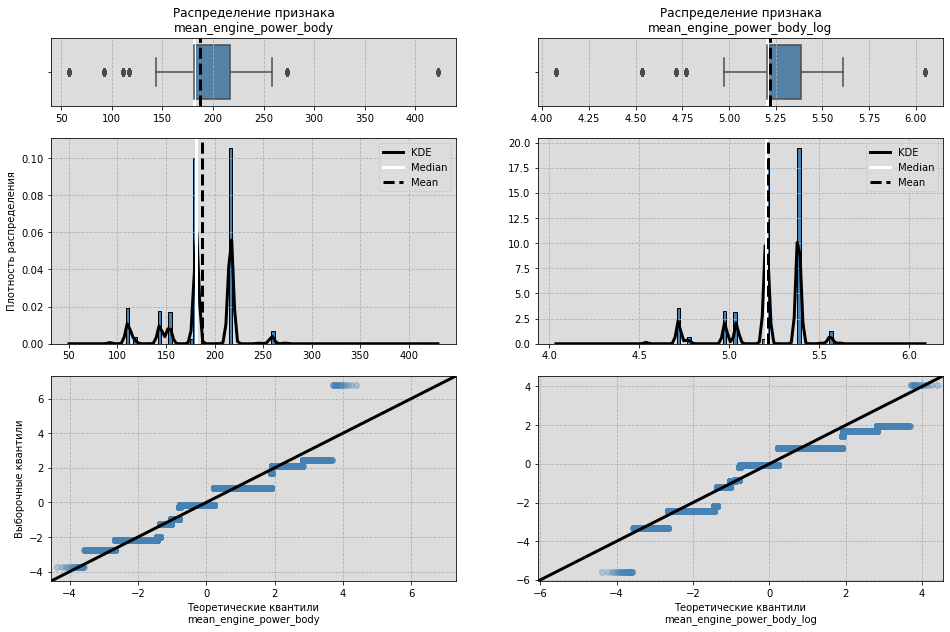

Left       Right
Границы выбросов mean_engine_power_body        128.148790  269.750097
Кол-во выбросов mean_engine_power_body       14602.000000  407.000000
Границы выбросов mean_engine_power_body_log      4.939109    5.649153
Кол-во выбросов mean_engine_power_body_log   14602.000000   18.000000

---

### std_engine_power_body

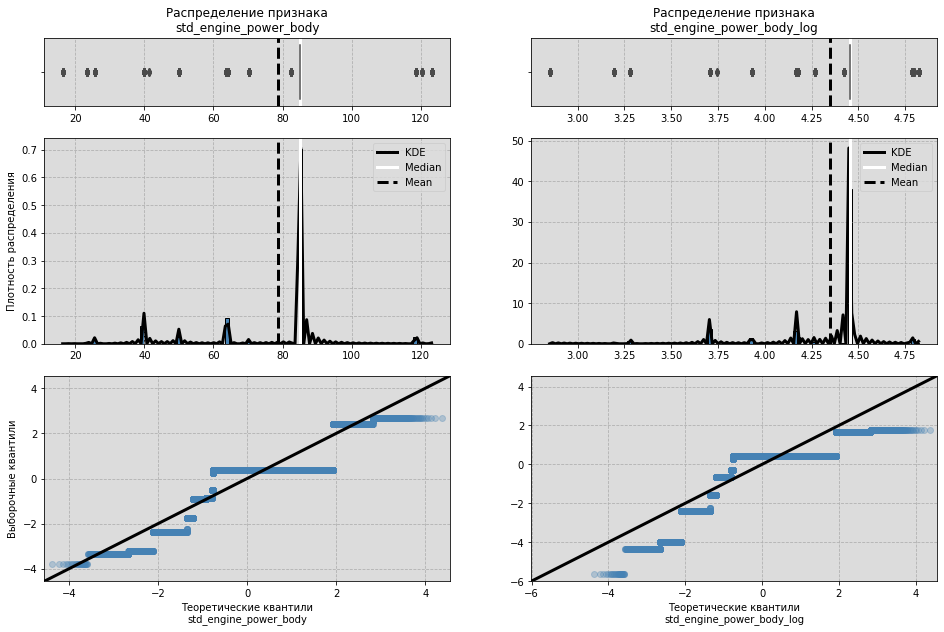

Left        Right
Границы выбросов std_engine_power_body         84.933823    85.014082
Кол-во выбросов std_engine_power_body       37448.000000  4548.000000
Границы выбросов std_engine_power_body_log      4.453578     4.454511
Кол-во выбросов std_engine_power_body_log   37448.000000  4548.000000

---

### mean_engine_power_model_name

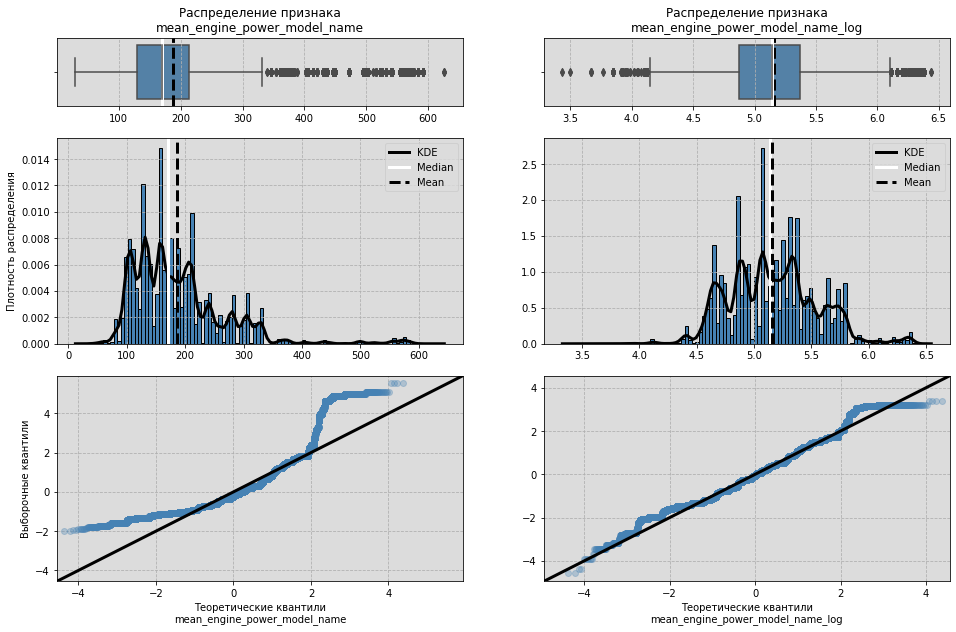

Left        Right
Границы выбросов mean_engine_power_model_name        3.974241   338.660752
Кол-во выбросов mean_engine_power_model_name         0.000000  4472.000000
Границы выбросов mean_engine_power_model_name_log    4.128044     6.109881
Кол-во выбросов mean_engine_power_model_name_log   447.000000  2438.000000

---

### std_engine_power_model_name

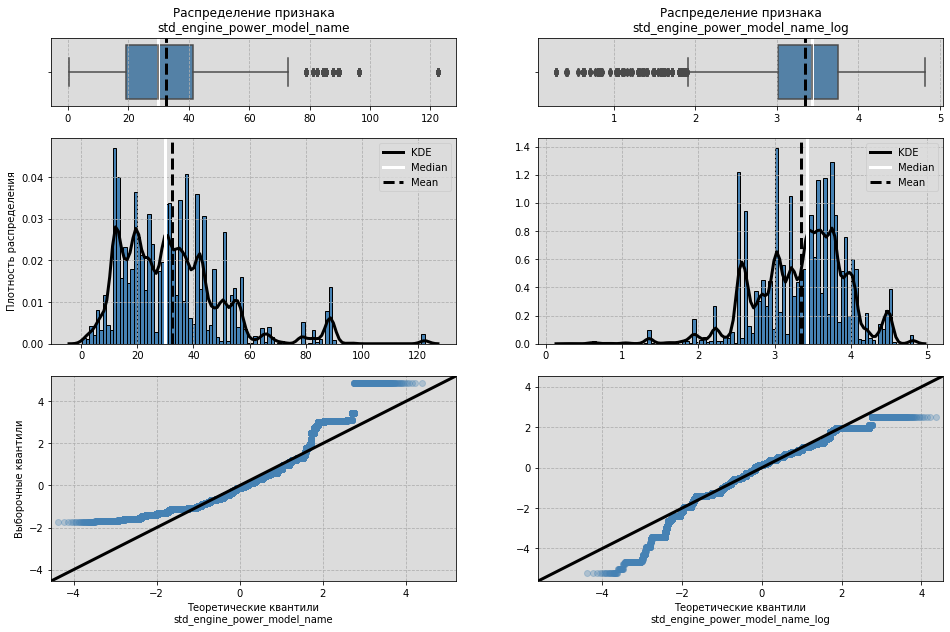

Left        Right
Границы выбросов std_engine_power_model_name       -13.910314    74.644775
Кол-во выбросов std_engine_power_model_name          0.000000  7205.000000
Границы выбросов std_engine_power_model_name_log     1.904269     4.854257
Кол-во выбросов std_engine_power_model_name_log   1987.000000     0.000000

---

### mean_product_date_to_start_date_body

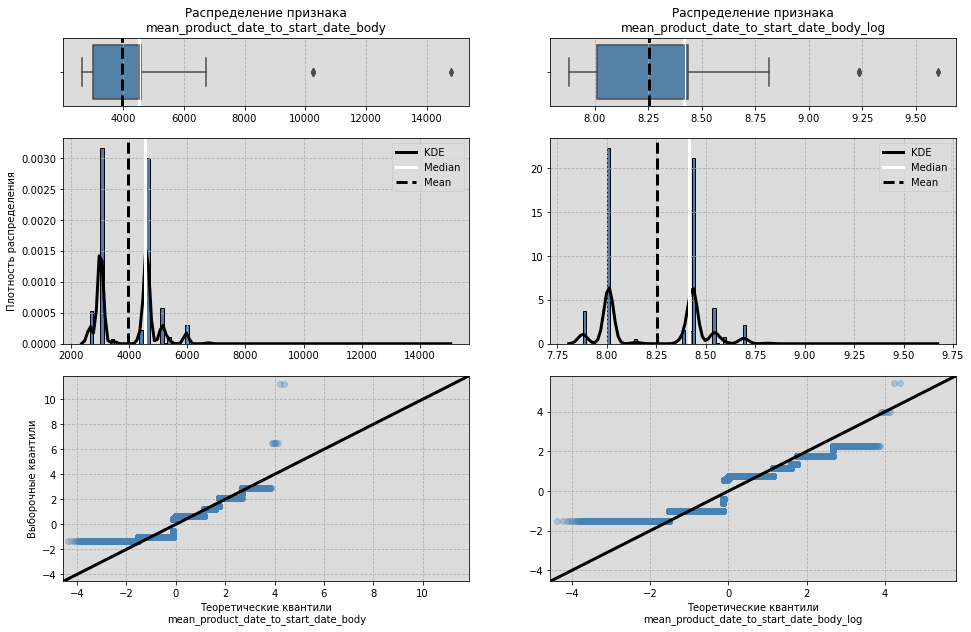

Left        Right
Границы выбросов mean_product_date_to_start_dat...  620.900630  6993.338081
Кол-во выбросов mean_product_date_to_start_date...    0.000000     8.000000
Границы выбросов mean_product_date_to_start_dat...    7.373297     9.071745
Кол-во выбросов mean_product_date_to_start_date...    0.000000     8.000000

---

### std_product_date_to_start_date_body

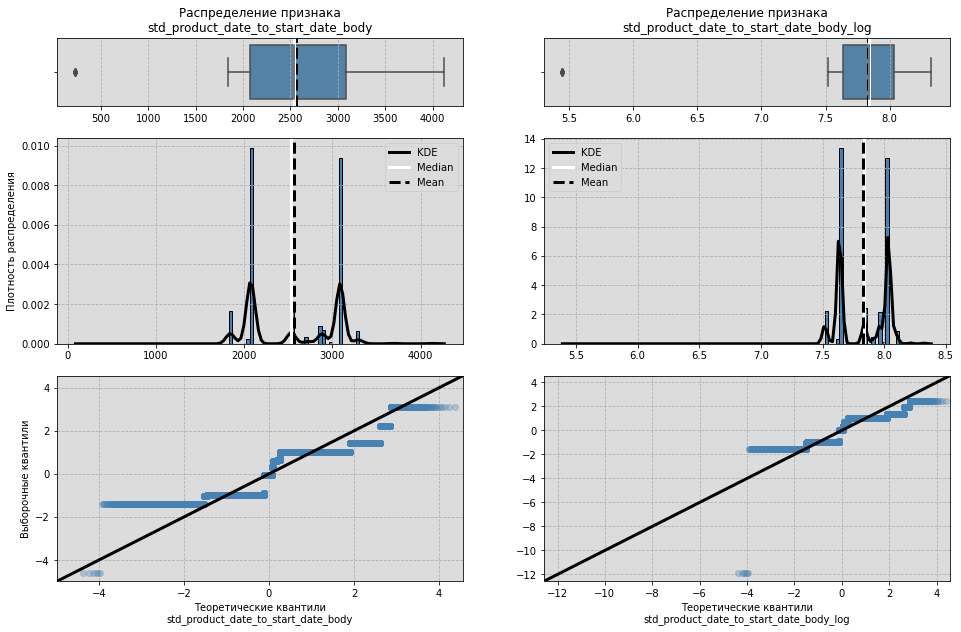

Left        Right
Границы выбросов std_product_date_to_start_date...  555.023058  4608.810969
Кол-во выбросов std_product_date_to_start_date_...    6.000000     0.000000
Границы выбросов std_product_date_to_start_date...    7.042014     8.632088
Кол-во выбросов std_product_date_to_start_date_...    6.000000     0.000000

---

### mean_product_date_to_start_date_model_name

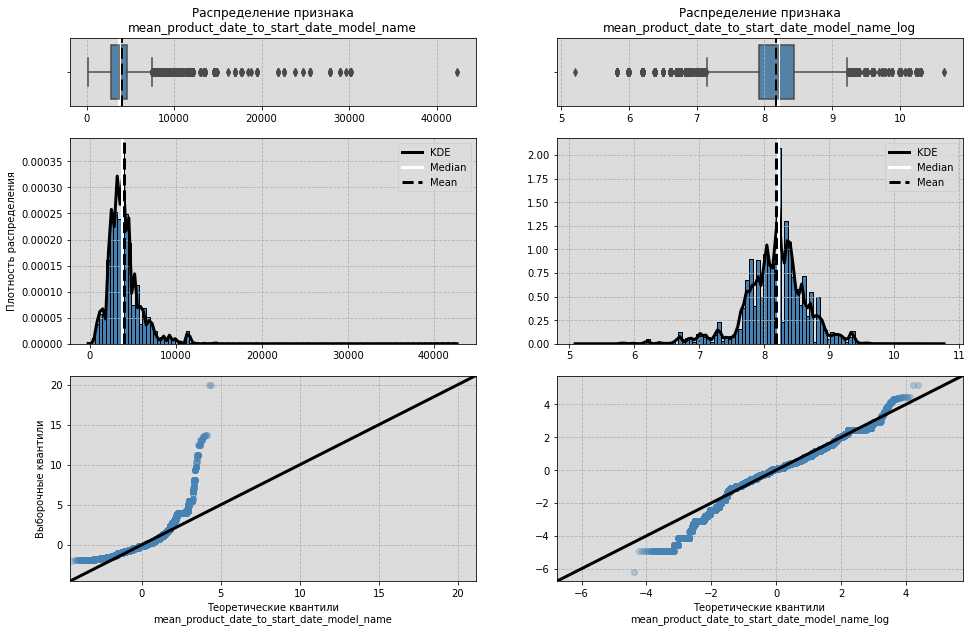

Left        Right
Границы выбросов mean_product_date_to_start_dat...   -88.432761  7464.892939
Кол-во выбросов mean_product_date_to_start_date...     0.000000  7149.000000
Границы выбросов mean_product_date_to_start_dat...     7.132332     9.226274
Кол-во выбросов mean_product_date_to_start_date...  6536.000000  2635.000000

---

### std_product_date_to_start_date_model_name

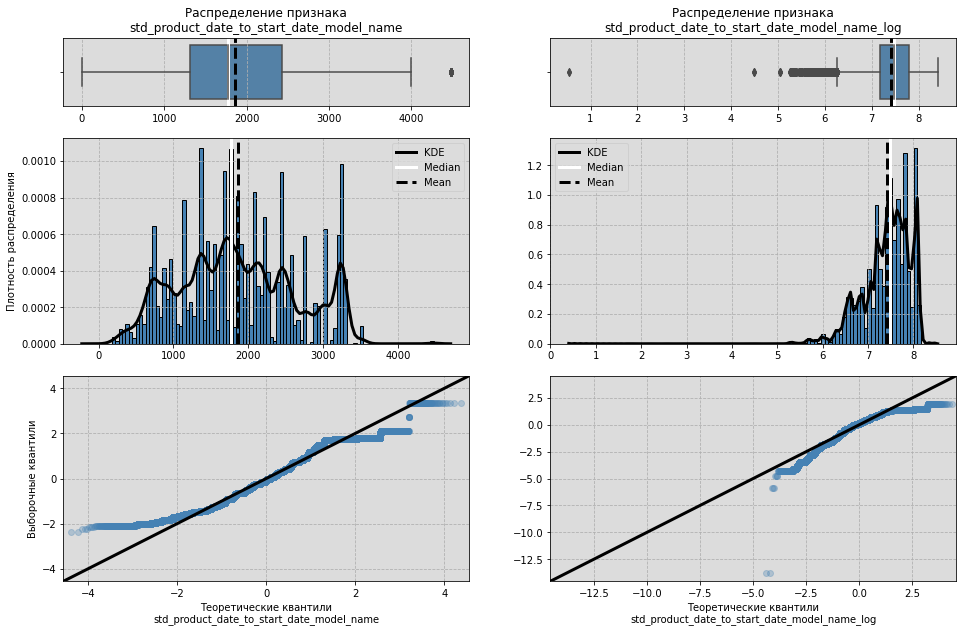

Left        Right
Границы выбросов std_product_date_to_start_date...  -361.410721  4095.112515
Кол-во выбросов std_product_date_to_start_date_...     0.000000   110.000000
Границы выбросов std_product_date_to_start_date...     6.255626     8.716308
Кол-во выбросов std_product_date_to_start_date_...  3517.000000     0.000000

---

### product_volume_fuel_rate

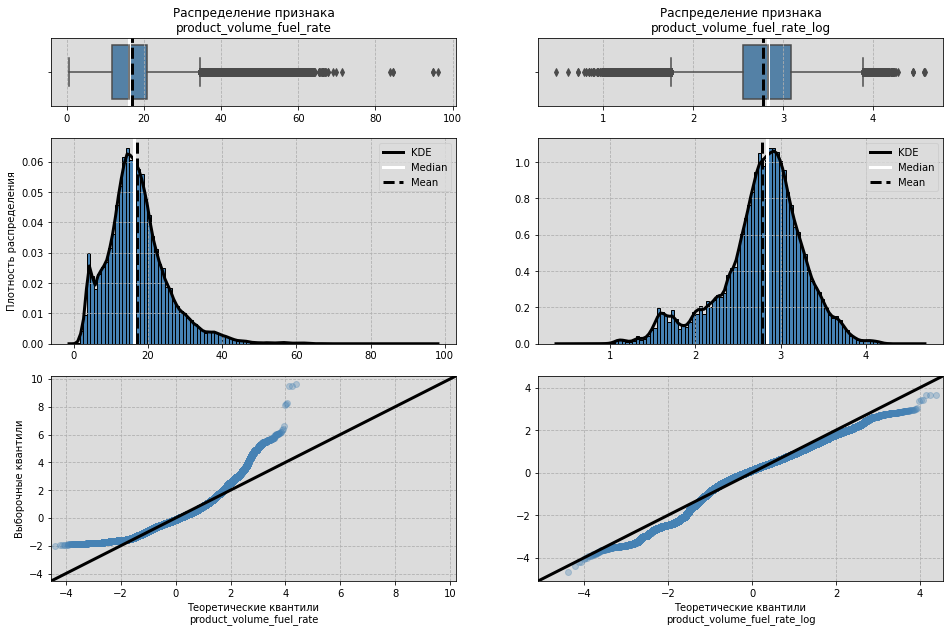

Left        Right
Границы выбросов product_volume_fuel_rate        -1.731922    34.471447
Кол-во выбросов product_volume_fuel_rate          0.000000  6036.000000
Границы выбросов product_volume_fuel_rate_log     1.752858     3.886312
Кол-во выбросов product_volume_fuel_rate_log   8681.000000   809.000000

---

### mileage_age

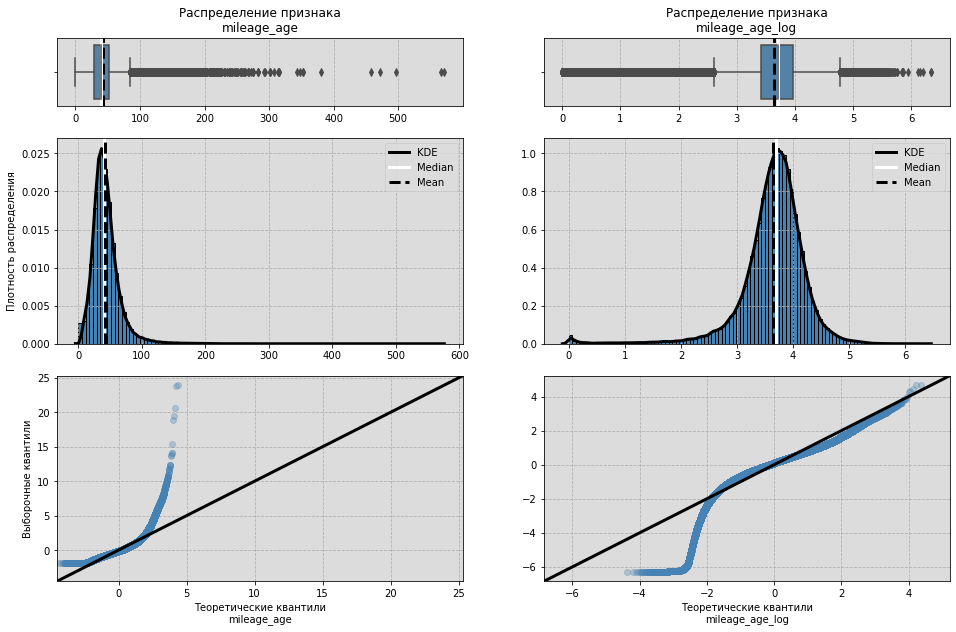

Left        Right
Границы выбросов mileage_age        -3.327199    84.426167
Кол-во выбросов mileage_age          0.000000  5989.000000
Границы выбросов mileage_age_log     2.609138     4.772386
Кол-во выбросов mileage_age_log   6046.000000  1713.000000

---

In [123]:
for col in new_num_lst:
    num_col_analyze_general(data[data[col] != 0], col)

Признаки, чье распределение улучшается после логарифмирования: 
* <code>acceleration</code>
* <code>clearance_min</code>
* <code>start_date_to_parsing_date</code>
* <code>model_date_to_product_date</code>
* <code>product_date_to_start_date</code>
* <code>words_count</code>
* <code>mileage_age</code>
* <code>product_volume_fuel_rate</code>  

Добавим их в список на логарифмирование, а также выделим признаки, которым может понадобится скалирование:

In [124]:
log_lst += ['acceleration',
           'clearance_min',
           'start_date_to_parsing_date',
           'model_date_to_product_date', 
           'product_date_to_start_date',
           'words_count',
           'mileage_age',
            'product_volume_fuel_rate']

In [125]:
psb_scal_lst += ['clearance_min', 
                 'product_date_to_start_date', 
                'start_date_to_parsing_date', 
                 'model_date_to_product_date', 
                 'words_count', 
                 'product_volume_fuel_rate', 
                 'mileage_age']

In [126]:
scal_lst += ['std_engine_power_model_name',
             'std_mileage_model_name', 
             'std_mileage_body', 
             'std_engine_power_body', 
             'std_engine_power_model_name',
             'std_product_date_to_start_date_model_name']

Оценим значимость новых признаков:

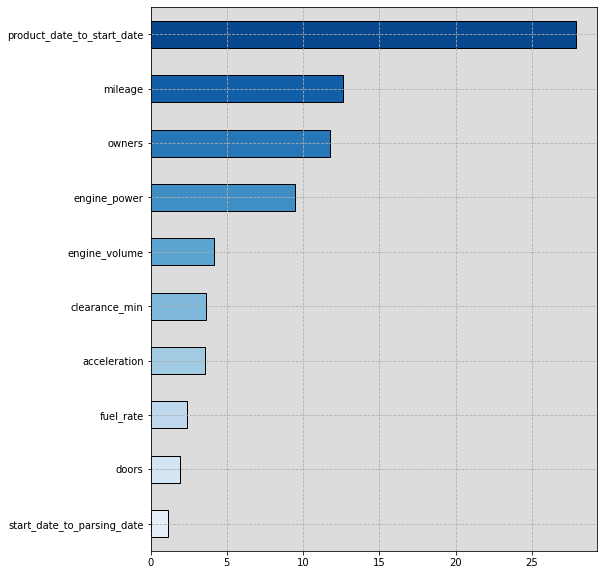

In [127]:
num_lst += new_num_lst
f_classifier(data[data['data'] != 'test'], num_lst, 'price')

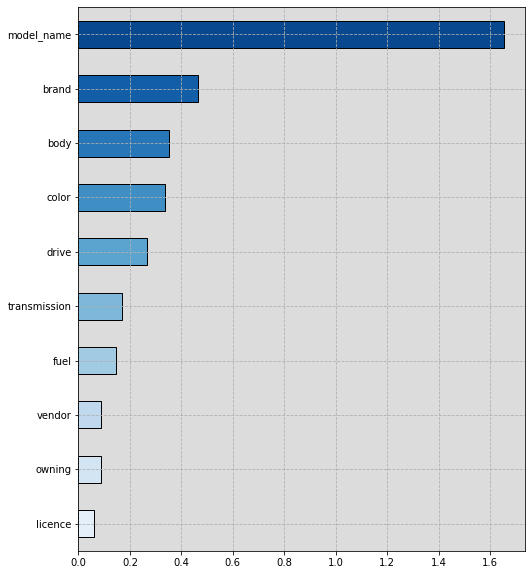

In [128]:
bin_lst += new_bin_lst
temp_data = data.copy()
for col in cat_lst+bin_lst:
    temp_data[col] = temp_data[col].astype('category').cat.codes
mutual_classifier(temp_data[temp_data['price'] != 0], cat_lst+bin_lst, 'price')

В числовых принаках сменился лидер, первые место занимает возрас автомобиля на момент размещения объявления.

Среди категориальных признаков распределение по важности не поменялось.

Посмотрим на матрицу корреляций:

In [129]:
corr_matrix(temp_data[temp_data['price'] != 0], num_lst+cat_lst+bin_lst, add_col='price', matrix_name='all cols')

Среди опциональных признаков самое высокое значение - 87, между <code>seats-heat</code> и <code>audiosystem</code>. Похоже эти опции часто продают в рамках одной комплектиции. Часто вместе с ними продают <code>climate-control</code>. Еще связки опций, которые часто продают вместе: (<code>cruise-control</code>, <code>multi-wheel</code>, <code>isofix</code>), (<code>usb</code>, <code>aux</code>) и (<code>airbag-driver</code>, <code>airbag-passenger</code>).

Добавим сильноскоррелированные признаки (80+) в отдельный список. В дальнейшем проверим, влияет ли их удаление на работу модели.

In [130]:
corr_lst = ['audiosystem', 
            'cruise-control', 
            'airbag-curtain', 
            'mean_engine_power_model_name', 
            'std_product_date_to_start_date_model_name', 
            'std_product_date_to_start_date_body', 
            'mean_product_date_to_start_date_body', 
            'std_engine_power_body', 
            'mean_mileage_model_name', 
            'std_mileage_body', 
            'mean_mileage_body']

### Итого по созданию новых признаков

* Из столбцов <code>equipment_dict</code> и <code>complectation_dict</code> выделены в отдельные признаки наличие опций в комплеткации. Всего уникальных опций в датасете - 266, которые были отфильтрованы до 47.
* Из столбца <code>super_gen</code> удалось выделить в отдельные признаки дополнительные технические характеристики: ускорение до 100, минимальный клиренс и расход топлива.
* Из временных признаков создано 3 новых числовых признака - разница в днях междну ними.
* Из текстов объявлений создан новый числовой признак - количество слов в объявлении.
* Созданы 9 бинарных признаков: 
    * флаг новой машины
    * флаг машины не старше 3х лет
    * флаг машины не старше 5и лет
    * флаг старой машины
    * флаг года сбора данных
    * флаг люксового бренда
    * флаг популярного цвета
    * флаг марки, чья цена выше среднего
    * флаг популярной модели
    * флаг популярной модели по марке
    * флаг модели, чья цена выше среднего
* Созданы 6 сруппированных и 2 вариационных числовых признака.
* Проведен анализ распредления для числовых признаков.
* Проведен корреалиационный анализ для всех признаков.
* Финальный датасет для обучения состоит 86 признаков:  
    * 19 числовых
    * 7 категориальных
    * 62 бинарных

[К содержанию](#0)

---

<a id="6"></a>
# [6. Обучение](#6)

<img align=center src="https://miro.medium.com/max/1838/0*Y4TX-vbl6pzynkgd.jpeg" width="800" />

Подготовим данные для модели. Для начала разберемся с целевой переменной. Учтем возможную инфляцию между 20м и 21м годом. Для этого вычислим на сколько процентов изменилась средняя цена за модель за год. Затем, с помощью полученных данных, приведем цены за 21й год к ценам за 20й:

In [131]:
# # Формируем словари со средней ценой за модель
# old_price_dict = temp_data[temp_data['data'] == 'train'].groupby('model_name')['price'].mean().to_dict()
# new_price_dict = temp_data[temp_data['data'] == 'parsed'].groupby('model_name')['price'].mean().to_dict()

# # Формируем новый словарь с процентами
# inf_dict = {}
# for car in old_price_dict:
#     if car in new_price_dict.keys():
#         pct = (new_price_dict[car]-old_price_dict[car])/old_price_dict[car]
#         inf_dict[car] = pct
        
# temp_data['pct'] = temp_data['model_name'].map(inf_dict)
# temp_data['pct'].fillna(0, inplace=True)
# temp_data['price'] = temp_data[['pct', 'price', 'data']].progress_apply(inflation, axis=1)
# temp_data.drop(['pct'], axis=1, inplace=True)

Логарифмируем и стандатизируем числовые отобранные признаки:

In [132]:
# for col in log_lst:
#     temp_data[col] = temp_data[col].apply(lambda x: np.log(x + 1))
# for col in psb_log_lst:
#     temp_data[col] = temp_data[col].apply(lambda x: np.log(x + 1))

In [133]:
scaler = RobustScaler()
temp_data[scal_lst] = scaler.fit_transform(temp_data[scal_lst].values)
temp_data[psb_scal_lst] = scaler.fit_transform(temp_data[psb_scal_lst].values)

Соберем датасет:

In [134]:
models_data = temp_data[num_lst+cat_lst+bin_lst+['price', 'data']]

Удалим сильноскоррелированные признаки:

In [135]:
# models_data.drop(corr_lst, axis=1, inplace=True)

Удалим признаки, ухудшающие модель. Отбор признаков проводился отдельно. Ноутбук с кодом и пояснениями тут: https://github.com/Chedered/SkillFactory/blob/main/DS/module-5/cleaning%20features.ipynb

In [136]:
# drop_lst = ['airbag-passenger', 'electro-mirrors', 'ptf', 'immo', 'electro-window-front', 'lock']
# models_data.drop(corr_lst, axis=1, inplace=True)

Итоговый датасет:

In [137]:
models_data.sample()

engine_volume  engine_power  mileage  doors  owners  acceleration  \
124136            2.0     -0.103774 -0.20116    4.0     2.0           7.6   

        clearance_min  fuel_rate  start_date_to_parsing_date  \
124136          -0.48        4.7                    0.013333   

        product_date_to_start_date  model_date_to_product_date  words_count  \
124136                     0.31553                    0.499316    -0.387097   

        mean_mileage_body  std_mileage_body  mean_mileage_model_name  \
124136      176279.669237               1.0            140413.276892   

        std_mileage_model_name  mean_engine_power_body  std_engine_power_body  \
124136                0.639427               181.24928                    0.0   

        mean_engine_power_model_name  std_engine_power_model_name  \
124136                    176.635535                     0.512182   

        mean_product_date_to_start_date_body  \
124136                           4603.674037   

        std_product_date_to_start_date_body  \
124136                          3088.640502   

        mean_product_date_to_start_date_model_name  \
124136                                 3749.298912   

        std_product_date_to_start_date_model_name  product_volume_fuel_rate  \
124136                                   1.123866                  1.416183   

        mileage_age  body  brand  color  fuel  model_name  transmission  \
124136    -0.558875    10      1     15     3          20             0   

        drive  vendor  owning  licence  wheel  airbag-driver  aux  isofix  \
124136      0       0       0        1      0              1    1       1   

        electro-window-front  airbag-passenger  computer  seat-transformation  \
124136                     1                 1         1                    1   

        wheel-power  alarm  lock  electro-mirrors  electro-window-back  ptf  \
124136            1      1     1                1                    1    1   

        rain-sensor  airbag-side  audiosystem-cd  condition  abs  \
124136            1            1               1          1    1   

        front-seats-heat  wheel-configuration2  wheel-configuration1  \
124136                 1                     1                     1   

        12v-socket  park-assist-r  cruise-control  esp  usb  light-sensor  \
124136           1              1               1    1    1             1   

        tyre-pressure  mirrors-heat  bluetooth  immo  multi-wheel  \
124136              1             1          1     1            1   

        front-centre-armrest  hcc  airbag-curtain  light-cleaner  \
124136                     1    1               1              1   

        wheel-leather  auto-mirrors  third-rear-headrest  climate-control-1  \
124136              1             1                    1                  1   

        park-assist-f  leather  servo  audiopreparation  seats-heat  \
124136              1        1      1                 1           1   

        climate-control  audiosystem  old_car  new_car  three_old  five_old  \
124136                1            1        0        0          0         0   

        old_adv  year  popular_color  price_brand  popular_model  \
124136        1     0              1            1              1   

        popular_model_in_brand  price_model     price   data  
124136                       0            0  700000.0  train

Разделим данные:

In [138]:
X = models_data[models_data['data'] != 'test'].drop(['price', 'data'], axis=1).reset_index(drop=True)
 
X_sub = models_data[models_data['data'] == 'test'].drop(['price', 'data'], axis=1).reset_index(drop=True)

y = models_data[models_data['data'] != 'test']['price'].values

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

[К содержанию](#0)

---

<a id="6.1"></a>
# [6.1 RandomForestRegressor](#6.1)

### Default

Для начала проверим, какой результат покажет __RandomForestRegressor__ с дефолтными параметрами, после добавления новых признаков и их обработки:

In [140]:
# rfr = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
# rfr.fit(X_train, y_train)
# y_pred = rfr.predict(X_test)
# MAPE = mape(y_test, y_pred)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Точность модели в ноутбуке - __15.26%__. Точность на ЛБ - __17.43%__. Точность в ноутбуке улучшилась почти в два раза.

In [141]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(rfr.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>price_date_to_start_date</code>
* <code>engine_volume</code>
* <code>engine_power</code>

### Log Target

Попробуем логарифмировать целевую переменную:

In [142]:
# rfr_log = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
# rfr_log.fit(X_train, np.log(y_train))
# y_pred = rfr_log.predict(X_test)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Точность модели в ноутбуке - __13.35%__. Точность на ЛБ - __15.73%__. Логарифмирование целевой переменной заметно улучшает результат.

Посмотрим, поменялись ли признаки, влияющие на модель:

In [143]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(rfr_log.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>price_date_to_start_date</code>
* <code>price_model</code>
* <code>engine_power</code>

### Hyperparameters

Попробуем подобрать оптимальные параметры для модели:

> ***Подбор параметров для моделей проводился в отдельном ноутбуке:*** https://github.com/Chedered/SkillFactory/blob/main/DS/module-5/hyperparameters.ipynb

In [144]:
# rfr_log_hp = RandomForestRegressor(n_jobs=-1, 
#                                     random_state=RANDOM_SEED, 
#                                     n_estimators=244, 
#                                     max_depth=34, 
#                                     min_samples_leaf=2)
# rfr_log_hp.fit(X_train, np.log(y_train))
# y_pred = rfr_log_hp.predict(X_test)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Точность модели в ноутбуке - __13.28%__. Точность на ЛБ - __15.85%__. Подобранные гиперпараметры улучшили результат в ноутбуке, но на ЛБ точность ухудшилась. Стоит попробовать кросс-валидацию с дефолтными параметрами и подобранными.

In [145]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(rfr_log_hp.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>price_date_to_start_date</code>
* <code>price_model</code>
* <code>engine_power</code>

### Cross-validation

Попробуем кросс-валидацию на 10 фолдах:

In [146]:
# cv_rfr_log = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
# MAPE, cv_rfr_log= kfold_validation(cv_rfr_log, X, y, cv=10, log_target=True)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

In [147]:
# cv_rfr_log_hp = RandomForestRegressor(n_jobs=-1, 
#                                     random_state=RANDOM_SEED, 
#                                     n_estimators=244, 
#                                     max_depth=34, 
#                                     min_samples_leaf=2)
# MAPE, cv_rfr_log_hp = kfold_validation(cv_rfr_log_hp, X, y, cv=10, log_target=True)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Ситуация с гиперпараметрами не улучшилась. Если в ноутбуке разница в точности __13.27__-__13.25__ в пользу модели с подобранными параметрами, то на ЛБ разница - __15.36__-__15.50__ в пользу дефолтных настроек. Кросс-валидация улучаешт результат, как в ноутбуке, так и на ЛБ.

[К содержанию](#0)

---

<a id="6.2"></a>
# [6.2 CatBoostRegressor](#6.2)

### Log Target

Попробуем __CatBoost__ c дефолтными настройками и логарифмированной целевой переменной:

In [148]:
# cbr_log = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# cbr_log.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True
#          )
# y_pred = cbr_log.predict(X_test)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Результат значительно улучшился по сравнению со случайным лесом: __12.62%__ в ноутбуке и __13.16%__ на ЛБ.

In [149]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(cbr_log.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>product_date_to_start_date</code>
* <code>engine_power</code>
* <code>mileage</code>

### Cat Features

__CatBoost__ умеет работать с категориальными признаками напрямую. Посмотрим, как изменится значение метрики, если не изменять категориальные признаки.

In [150]:
# str_lst = ['body', 'brand', 'color', 'fuel', 'model_name', 'transmission', 'drive']
# X_cat, X_sub_cat = X.copy(), X_sub.copy()
# X_cat[str_lst] = data[data['data'] != 'test'][str_lst].reset_index(drop=True)
# X_sub_cat[str_lst] = data[data['data'] == 'test'][str_lst].reset_index(drop=True)

In [151]:
# X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [152]:
# cbr_log_cat = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# cbr_log_cat.fit(X_cat_train, np.log(y_cat_train),
#          cat_features=str_lst,
#          eval_set=(X_cat_test, np.log(y_cat_test)),
#          verbose_eval=0,
#          use_best_model=True
#          )
# y_cat_pred = cbr_log_cat.predict(X_cat_test)
# MAPE = mape(y_cat_test, np.exp(y_cat_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

__CatBoost__ с категориальными признаками без кодировки показал результаты хуже, чем с кодированными, как в нотубуке - __12.67%__, так и на ЛБ - __13.24%__.

In [153]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(cbr_log_cat.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>product_date_to_start_date</code>
* <code>engine_power</code>
* <code>mileage</code>

В дальнейшем будем тестировать модель с кодироваными категориальными признаками.

### Hyperparameters

Проверим CatBoost с подобранными параметрами:

In [154]:
# cbr_log_hp=CatBoostRegressor(
#         learning_rate=0.019,
#         depth=10,
#         l2_leaf_reg=1,
#         min_child_samples=4,
#         bagging_temperature=10,
#         iterations = 5000,
#         random_seed = RANDOM_SEED,
#         eval_metric='MAPE',
#         custom_metric=['R2', 'MAE'],
#         silent=True
#     )
# cbr_log_hp.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )
# y_pred = cbr_log_hp.predict(X_test)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Подобранные параметры помогли улучшить результаты и в ноутбуке (__12.40%__), и на ЛБ (__12.29%__).

In [155]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(cbr_log_hp.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>product_date_to_start_date</code>
* <code>engine_power</code>
* <code>mean_engine_power_model_name</code>

### Cross-validation

Попробуем кросс-валидацию на 10 фолдах:

In [156]:
# cv_cbr_log = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# # kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# mape_values = []

# for train_index, test_index in tqdm(skf.split(X, y), leave=False, desc='kv'):
#     X_train = X.filter(items=train_index, axis=0)
#     X_test = X.filter(items=test_index, axis=0)
#     y_train, y_test = y[train_index], y[test_index]
    
#     cv_cbr_log.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True
#          )

#     y_pred = np.exp(cv_cbr_log.predict(X_test))

#     mape_value = mape(y_test, y_pred)
#     mape_values.append(mape_value)

# printmd(f"*Значение метрики* ***MAPE - {np.mean(mape_values) *100:0.2f}%***")

Обучение на подвыборках дало худший результат для __CatBoost__ и в ноутбуке (__12.04%__), и на ЛБ (__14.91%__).

In [157]:
# cv_cbr_log_hp=CatBoostRegressor(
#         learning_rate=0.019,
#         depth=10,
#         l2_leaf_reg=1,
#         min_child_samples=4,
#         bagging_temperature=10,
#         iterations = 5000,
#         random_seed = RANDOM_SEED,
#         eval_metric='MAPE',
#         custom_metric=['R2', 'MAE'],
#         silent=True
#     )

# # kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# mape_values = []

# for train_index, test_index in tqdm(skf.split(X, y), leave=False, desc='kv'):
#     X_train = X.filter(items=train_index, axis=0)
#     X_test = X.filter(items=test_index, axis=0)
#     y_train, y_test = y[train_index], y[test_index]
    
#     cv_cbr_log_hp.fit(X_train, np.log(y_train),
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True
#          )

#     y_pred = np.exp(cv_cbr_log_hp.predict(X_test))

#     mape_value = mape(y_test, y_pred)
#     mape_values.append(mape_value)

# printmd(f"*Значение метрики* ***MAPE - {np.mean(mape_values) *100:0.2f}%***")

То же самое и для модели с подоранными параметрами, но лучше, чем на дефолтных - __11.75%__ и __14.25%__

[К содержанию](#0)

---

<a id="6.3"></a>
# [6.3 ExtraTreesRegressor](#6.3)

В качестве следующей модели попробуем __ExtraTreesRegressor__.

### Log Target

In [158]:
# etr_log = ExtraTreesRegressor(n_jobs=-1, random_state=RANDOM_SEED)
# etr_log.fit(X_train, np.log(y_train))
# y_pred = etr_log.predict(X_test)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Модель дает результат хуже в ноутбуке (__13.18%__), чем с __CatBoost__, но лучше, чем с __RandomTreesRegressor__. Однако модель показала пока лучший результат на ЛБ - __11.74%__.

In [159]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(etr_log.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>product_date_to_start_date</code>
* <code>five_old</code>
* <code>price_model</code>

### Hyperparameters Log Target

In [160]:
# etr_log_hp = ExtraTreesRegressor(n_jobs=-1, 
#                                     random_state=RANDOM_SEED, 
#                                     n_estimators=359, 
#                                     max_depth=40, 
#                                     min_samples_leaf=2, 
#                                     min_samples_split=6)
# etr_log_hp.fit(X_train, np.log(y_train))
# y_pred = etr_log_hp.predict(X_test)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Подобранные параметры улучшают результат в ноутбуке - __12.96%__, но модель показывает себя хуже на ЛБ - __12.35%__

In [161]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(etr_log_hp.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>five_old</code>
* <code>product_date_to_start_date</code>
* <code>price_model</code>

### Cross-validation

> __ExtraTreesRegressor__ с дефолтными параметрами с кросс-валидацией показали лучший результат на ЛБ без обработки, поэтому были проведены различные тесты в поиске лучшего результата.

In [162]:
# cv_etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
# MAPE, cv_etr_log = kfold_validation(cv_etr_log, X, y, cv=40, log_target=True)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

| **Обработка** | **Ноутбук** | **ЛБ** |
| :--- | :---: | :---: |
| На всей выборке | 13.18% | 11.74% |
| KFold 10 | 13.06% | **11.33%** | 
| Учет инфляции | 13.11% | _11.44%_ |  
| Логарифмирование | 13.05% | _11.38%_ | 
| Скалирование | 13.05% | **11.30%** |
| Доп. скалирование | 13.05% | **11.30%** | 
| Корреляция | 13.07% | _11.71%_ | 
| Удаление признаков | 13.08% | _11.68%_ | 
| StrKFold | 13.09% | 11.76% | 
| KFold 5 | 13.12% | 11.74% | 
| KFold 20 | 13.00% | **11.14%** | 
| KFold 30 | 12.99% | **11.03%** | 
| KFold 40 | 12.98% | **11.02%** |
| KFold 35 | 12.98% | **11.01%** |

Лучший результат на ЛБ показала модель со скалированием числовых признаков на 35 фолдах (**11.01%**)

### Doubling Data Experiment

В целях эксперимента, чтобы проверить гипотезу, что с увеличением записей результат улучшится, лучшая модель была обучена на удвоенном наборе данных:

In [163]:
# double_data = models_data[models_data['data'] != 'test'].append(models_data[models_data['data'] != 'test'], sort=False).reset_index(drop=True)

In [164]:
# Temp_X = double_data.drop(['price', 'data'], axis=1).reset_index(drop=True)
# temp_y = double_data['price'].values

In [165]:
# dbl_kv_etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
# MAPE, dbl_kv_etr_log = kfold_validation(dbl_kv_etr_log, Temp_X, temp_y, cv=35, log_target=True)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Модель показала лучший результат на ЛБ - **10.93%**, но результат в ноутбуке показал, что модель переобучается (**1.23%**). Было принято решение не использовать этот результат в качестве публичного.

[К содержанию](#0)

---

<a id="6.4"></a>
# [6.4 LGBMRegressor](#6.4)

На очереди **lightGBM**.

### Log Target

In [166]:
# lgbmr_log = LGBMRegressor(objective='regression', 
#                           metric='mape', 
#                           n_estimators=2000, 
#                           random_state=RANDOM_SEED)
# lgbmr_log.fit(X_train, np.log(y_train),
#               eval_set=[(X_test, np.log(y_test))],
#               eval_metric='mape', 
#               verbose=False)
# y_pred=lgbmr_log.predict(X_test, num_iteration=lgbmr_log.best_iteration_)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

**LGBMRegressor** с дефолтными параметрами показал лучший результат на полной выборке в ноутбуке (**12.19%**), но хуже, чем лучшая модель, на ЛБ (**13.09%**)

In [167]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(lgbmr_log.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>product_date_to_start_date</code>
* <code>words_count</code>
* <code>mileage</code>

### Hyperparameters Log Target

In [168]:
# lgbmr_log_hp = LGBMRegressor(random_state=RANDOM_SEED, 
#                              objective='regression', 
#                              metric='mape', 
#                              n_estimators=2000, 
#                              learning_rate=0.018,
#                              max_depth=9,
#                              num_leaves=314,
#                              max_bin=265,
#                              min_data_in_leaf=3,
#                              bagging_fraction=1.0,
#                              feature_fraction=0.6, 
#                              bagging_freq=77)
# lgbmr_log_hp.fit(X_train, np.log(y_train),
#                  eval_set=[(X_test, np.log(y_test))],
#                  eval_metric='mape', 
#                  verbose=False)
# y_pred=lgbmr_log_hp.predict(X_test, num_iteration=lgbmr_log_hp.best_iteration_)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Подбор параметров заметно улучшил результаты, как в ноубуке - **11.76%**, так и на ЛБ **12.60%**. Модель показала лучший результат в нотбуке, не учитывая эксперимент с удвоением данных.

In [169]:
# plt.rcParams['figure.figsize'] = (8,10)
# feat_importances = pd.Series(lgbmr_log_hp.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh', 
#                                    edgecolor='k', 
#                                    linewidth=1, 
#                                    color=sns.color_palette('Blues_r', 10))

Топ-3 признака для модели по важности: 
* <code>words_count</code>
* <code>mileage</code>
* <code>product_date_to_start_date</code>

### Cross-validation

In [170]:
# cv_lgbmr_log = LGBMRegressor(objective='regression', 
#                           metric='mape', 
#                           n_estimators=2000, 
#                           random_state=RANDOM_SEED)

# # kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# mape_values = []

# for train_index, test_index in tqdm(skf.split(X, y), leave=False, desc='kv'):
#     X_train = X.filter(items=train_index, axis=0)
#     X_test = X.filter(items=test_index, axis=0)
#     y_train, y_test = y[train_index], y[test_index]
    
#     cv_lgbmr_log.fit(X_train, np.log(y_train),
#                   eval_set=[(X_test, np.log(y_test))],
#                   eval_metric='mape', 
#                   verbose=False)

#     y_pred=cv_lgbmr_log.predict(X_test, num_iteration=cv_lgbmr_log.best_iteration_)

#     mape_value = mape(y_test, np.exp(y_pred))
#     mape_values.append(mape_value)

# printmd(f"*Значение метрики* ***MAPE - {np.mean(mape_values) *100:0.2f}%***")

Кросс-валидация для модели с дефолтными параметрами ухудшила результат, как в ноутбуке (**12.74%**), так и на ЛБ (**12.96%**)

In [171]:
# cv_lgbmr_log_hp = LGBMRegressor(random_state=RANDOM_SEED, 
#                              objective='regression', 
#                              metric='mape', 
#                              n_estimators=2000, 
#                              learning_rate=0.021,
#                              max_depth=9,
#                              num_leaves=228,
#                              max_bin=200,
#                              min_data_in_leaf=2,
#                              bagging_fraction=0.9,
#                              feature_fraction=0.6, 
#                              bagging_freq=40)

# # kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# mape_values = []

# for train_index, test_index in tqdm(skf.split(X, y), leave=False, desc='kv'):
#     X_train = X.filter(items=train_index, axis=0)
#     X_test = X.filter(items=test_index, axis=0)
#     y_train, y_test = y[train_index], y[test_index]
    
#     cv_lgbmr_log_hp.fit(X_train, np.log(y_train),
#                   eval_set=[(X_test, np.log(y_test))],
#                   eval_metric='mape', 
#                   verbose=False)

#     y_pred=cv_lgbmr_log_hp.predict(X_test, num_iteration=cv_lgbmr_log_hp.best_iteration_)

#     mape_value = mape(y_test, np.exp(y_pred))
#     mape_values.append(mape_value)

# printmd(f"*Значение метрики* ***MAPE - {np.mean(mape_values) *100:0.2f}%***")

А кросс-валидация для модели с подобранными пармаметрами показала релутат на ЛБ лучше (**12.56%**), чем без нее. Результат в ноутбуке - **11.91%**. 

[К содержанию](#0)

---

<a id="6.5"></a>
# [6.5 StackingRegressor](#6.5)

Попробуем стакинг с помощью **StackingRegressor**

### Log Target

Объединим все предыдущие модели, которые показали лучший результат на ЛБ:

In [172]:
# estimators = [
#     ('cbr', CatBoostRegressor(learning_rate=0.019,
#                               depth=10,
#                               l2_leaf_reg=1,
#                               min_child_samples=4,
#                               bagging_temperature=6,
#                               iterations = 5000,
#                               random_seed = RANDOM_SEED,
#                               eval_metric='MAPE',
#                               custom_metric=['R2', 'MAE'],
#                               silent=True)),
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)),
#     ('lgbmr', LGBMRegressor(random_state=RANDOM_SEED, 
#                              objective='regression', 
#                              metric='mape', 
#                              n_estimators=2000, 
#                              learning_rate=0.018,
#                              max_depth=9,
#                              num_leaves=314,
#                              max_bin=265,
#                              min_data_in_leaf=3,
#                              bagging_fraction=1.0,
#                              feature_fraction=0.6, 
#                              bagging_freq=77))
# ]

# sr_log_comb = StackingRegressor(
#     estimators=estimators,
#     final_estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED), 
#     n_jobs=-1
# )

# sr_log_comb.fit(X_train, np.log(y_train))
# y_pred = np.exp(sr_log_comb.predict(X_test))
# MAPE = mape(y_test, y_pred)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Результат заметно хуже, чем у моделей по отдельности: в ноутбуке - **13.19%**, на ЛБ - **13.05%**.

Теперь попробуем объединить **ExtraTreesRegressor** с дефолтными парметрами и подобранными.

In [173]:
# estimators = [
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)),
#     ('etr_hp', ExtraTreesRegressor(n_jobs=-1, 
#                                     random_state=RANDOM_SEED, 
#                                     n_estimators=359, 
#                                     max_depth=40, 
#                                     min_samples_leaf=2, 
#                                     min_samples_split=6))
# ]

# sr_log_etr = StackingRegressor(
#     estimators=estimators,
#     final_estimator=LinearRegression(), 
#     n_jobs=-1
# )

# sr_log_etr.fit(X_train, np.log(y_train))
# y_pred = np.exp(sr_log_etr.predict(X_test))
# MAPE = mape(y_test, y_pred)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Такой вариант показал себя лучше, чем объединение всех моделей, но хуже, чем модели по отдельности: в ноутбуке - **12.60%**, на ЛБ - **12.20%**

### Cross-validation

In [174]:
# estimators = [
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)),
#     ('etr_hp', ExtraTreesRegressor(n_jobs=-1, 
#                                     random_state=RANDOM_SEED, 
#                                     n_estimators=359, 
#                                     max_depth=40, 
#                                     min_samples_leaf=2, 
#                                     min_samples_split=6))
# ]

# cv_sr_log_etr = StackingRegressor(
#     estimators=estimators,
#     final_estimator=LinearRegression(), 
#     n_jobs=-1
# )

# MAPE, cv_sr_log_etr = kfold_validation(cv_sr_log_etr, X, y, cv=3, log_target=True)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

К сожалению не удалось проверить крос-валидацию для стакинга на ЛБ, так как сохранение версии просто не прекращалось. Результат в ноутбуке - **12.87%**

[К содержанию](#0)

---

<a id="6.6"></a>
# [6.6 BaggingRegressor](#6.6)

Последним попробуем баггинг с **ExtraTreeRegressor** в качестве базы.

### Log Target

In [175]:
# br_log = BaggingRegressor(base_estimator=ExtraTreeRegressor(random_state=RANDOM_SEED),
#                           n_estimators=100, 
#                           random_state=RANDOM_SEED,  
#                           n_jobs=-1)
# br_log.fit(X_train, np.log(y_train))
# y_pred = br_log.predict(X_test)
# MAPE = mape(y_test, np.exp(y_pred))
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Баггинг показал результаты сильно хуже, чем остальные модели: в ноутбуке - **13.86%**, на ЛБ - **12.85%**

### Cross-validation

In [176]:
# cv_br_log = BaggingRegressor(base_estimator=ExtraTreeRegressor(random_state=RANDOM_SEED),
#                              n_estimators=100, 
#                              random_state=RANDOM_SEED,  
#                              n_jobs=-1)
# MAPE, cv_br_log = kfold_validation(cv_br_log, X, y, cv=10, log_target=True)
# printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

Кросс-валидация для баггинга улучшила результат на ЛБ - **12.60%**. Результат в ноутбуке - **13.95%**.

[К содержанию](#0)

---

<a id="6.7"></a>
# [6.7 Выбор модели и submission](#6.7)

В ходе выбора модели были проведены следуюшие тесты:
* логаририфирование целевой переменной
* округление предсказанний до тысяч
* улучшение распредления числовых признаков с помощью логарифмирования
* скалирование числовых признаков
* учет инфляции
* влияние данных о комплектации
* добавление данных из других регионов
* удаление сильноскоррелированных прзнаков
* удаление признаков, ухудшающих результат в ноутбуке
* изменение количества подвыборок

Лучший результат у ExtraTreesRegressor с дефолтными парметрами со скалированными числовыми признаками, логарифмированной целевой перменной, с кросс-валидацией на 35 фолдах.

In [177]:
final_model = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
MAPE, final_model = kfold_validation(final_model, X, y, cv=35, log_target=True)
printmd(f"*Значение метрики* ***MAPE - {(MAPE)*100:0.2f}%***")

*Значение метрики* ***MAPE - 13.00%***

In [178]:
predict_submission = np.exp(final_model.predict(X_sub))

In [179]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  6.069674e+05
1  1100549428  9.372275e+05
2  1100658222  8.390671e+05
3  1100937408  6.720571e+05
4  1101037972  6.451203e+05
5  1100912634  7.494728e+05
6  1101228730  6.310788e+05
7  1100165896  3.862709e+05
8  1100768262  1.865986e+06
9  1101218501  6.717016e+05

[К содержанию](#0)

---

<a id="7"></a>
# [7. Итоги](#7)

In [180]:
X.shape

(133389, 95)

В ходе работы было сделано:
1. Произведен парсинг данных с auto.ru. Всего было выгружено 85213 уникальных объявлений о продаже поддержанных автомобилей. После подгонки под тестовый датасет и объеденения с датасетом за 20й год, в итоговый датасет для обучения вошло 122474 объявления.
2. Отобраны признаки для дальнейшего анализа и обработки. Признаки были распределены по категориям.
3. Проанализированы отобранные числовые, категориальные, бинарные и временные признаки. В ходе анализа были заполнены пропуски и произведена очистка от выбросов, где это было необходимо.
4. На основе данных из столбцов со словарями были созданы новые признаки: наличие опций и дополнительные технические характеристики. Всего, на основе столбцов со словарями, было создано 49 новых признаков.
5. На основе существующих признаков было создано 20 признаков: 11 числовых и 9 бинарных.
6. Были проверены разные модели с дефолтными параметрами и подобраными, с кросс-валидацией и без, а также стакинг и баггинг.
7. Лучший результат у ExtraTreesRegressor с дефолтными парметрами со скалированными числовыми признаками, логарифмированной целевой перменной, с кросс-валидацией на 35 фолдах.